In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# read case
print(os.getcwd())
case = os.getcwd().split(os.sep)[-1]
print(case)

D:\Promotion\neurolib\GUI\current\gui\data\11110
11110


### Bistability

In [3]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

#####################################################
def getclosest(k_, found_solution, exc, inh, already_tried_):
    import numpy as np
    if len(found_solution) == 0:
        print("no solutions found")
        return -1
    
    start_ind = -1
    for j_ in found_solution:
        if j_ not in already_tried_ and j_ != k_:
            start_ind = j_
            break
            
    if start_ind == -1:
        return -1
        
    min_dist = np.sqrt((exc[k_] - exc[start_ind])**2 + (inh[k_] - inh[start_ind])**2)
    min_i = start_ind
        
    print(found_solution, already_tried_)
        
    if len(found_solution) == len(already_tried_):
        print("already tried all options")
        min_i = -1
        return min_i
    
    for i_ in found_solution:
        if i_ not in already_tried_:
            if i_ != k_ and i_ != min_i:
                dist_ = np.sqrt((exc[k_] - exc[i_])**2 + (inh[k_] - inh[i_])**2)
                if dist_ < min_dist:
                    min_dist = dist_
                    min_i = i_
                    
    if min_i == 0 and 0 in already_tried_:
        return -1
    
    return min_i

In [4]:
##### LOAD BOUNDARIES
data_file = 'bi.pickle'
with open(data_file,'rb') as f:
    load_array= pickle.load(f)
exc = load_array[0]
inh = load_array[1]
print(len(exc))
#plt.scatter(exc, inh)

147


In [5]:
bestControl_init = [None] * len(exc)
bestState_init = [None] * len(exc)
cost_init = [None] * len(exc)
runtime_init = [None] * len(exc)
grad_init = [None] * len(exc)
phi_init = [None] * len(exc)
costnode_init = [None] * len(exc)
weights_init = [None] * len(exc)

conv_init = [[False]*2] * len(exc)

In [6]:
bestControl_0 = [None] * len(exc)
bestState_0 = [None] * len(exc)
cost_0 = [None] * len(exc)
runtime_0 = [None] * len(exc)
grad_0 = [None] * len(exc)
phi_0 = [None] * len(exc)
costnode_0 = [None] * len(exc)
weights_0 = [None] * len(exc)

conv_0 = [[False]*2] * len(exc)

In [7]:
bestControl_1 = [None] * len(exc)
bestState_1 = [None] * len(exc)
cost_1 = [None] * len(exc)
runtime_1 = [None] * len(exc)
grad_1 = [None] * len(exc)
phi_1 = [None] * len(exc)
costnode_1 = [None] * len(exc)
weights_1 = [None] * len(exc)

conv_1 = [[False]*2] * len(exc)

In [8]:
initVars = [None] * len(exc)
target = [None] * len(exc)
cost_uncontrolled = [None] * len(exc)

cgv_list = [None, "HS", "FR", "PR", "CD", "LS", "DY", "WYL", "HZ", None]

In [9]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-32
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

c_var = [ [0], [1], [0,1]]
p_var = [ [0], [0], [0]]

### CURRENTS
cntrl_vars_0 = [0,1]
prec_vars = [0]

if case[0] == '0':    # low to high
    max_I = [3., -3.]
elif case[0] == '1':
    max_I = [-3., 3.]
    
if case[1] == '0':    # sparsity
    factor_ws = 1.
    factor_we = 0.
elif case[1] == '1':  # energy
    factor_ws = 0.
    factor_we = 1.
    
if case[3] == '0':
    cntrl_vars_init = [0]
elif case[3] == '1':
    cntrl_vars_init = [1]
elif case[3] == '2':
    cntrl_vars_init = [0,1]

if case[4] == '0':
    dur = 100
    trans_time = 0.8
elif case[4] == '1':
    dur = 400
    trans_time = 0.95
    
maxC = [5., -5., 0.18, 0.]

n_dur = int(np.around(dur/aln.params.dt + 1.,1))
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

In [10]:
init_file = 'control_init_' + case + '.pickle'
final_file = 'control_' + case + '.pickle'
case_1 = case[0] + case[1] + '0' + case[3] + case[4]
final_file_1 = 'control_' + case_1 + '.pickle'

In [11]:
if os.path.isfile(init_file) :
    print("file found")
    
    with open(init_file,'rb') as f:
        load_array = pickle.load(f)

    bestControl_init = load_array[0]
    bestState_init = load_array[1]
    cost_init = load_array[2]
    runtime_init = load_array[3]
    grad_init = load_array[4]
    phi_init = load_array[5]
    costnode_init = load_array[6]
    weights_init = load_array[7]

file found


In [12]:
# get initial parameters and target states

i_stepsize = 2
limit = 40
i_range = range(0, limit,i_stepsize)
i_range_0 = range(0, limit,i_stepsize)
i_range_1 = range(0, limit,i_stepsize)
data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = 3000.
    
    control0 = aln.getZeroControl()
    control0 = functions.step_control(aln, maxI_ = max_I[0])

    aln.run(control=control0)
    
    target_rates = np.zeros((2))
    target_rates[0] = aln.rates_exc[0,-1] 
    target_rates[1] = aln.rates_inh[0,-1]

    control0 = functions.step_control(aln, maxI_ = max_I[1])
    aln.run(control=control0)

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars[i] = init_state_vars
    
    aln.params.duration = dur

    target[i] = aln.getZeroTarget()
    target[i][:,0,:] = target_rates[0]
    target[i][:,1,:] = target_rates[1]

-------  0 0.4000000000000001 0.3500000000000001
-------  2 0.4000000000000001 0.3750000000000001
-------  4 0.4500000000000001 0.3750000000000001
-------  6 0.4250000000000001 0.40000000000000013
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000

In [13]:
# get uncontrolled cost

data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
        
    cost.setParams(1.0, 0.0, 0.0)

##### zero control as input for uncontrolled cost
    setinit(initVars[i], aln)
    control0 = aln.getZeroControl()

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = 0

    bestControl_init_, bestState_init_, cost_init_, runtime_init_, grad_init_, phi_init_, costnode_init_ = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
    
    cost_uncontrolled[i] = cost_init_[0]

-------  0 0.4000000000000001 0.3500000000000001
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5902.406479238383
Gradient descend method:  None
RUN  0 , total integrated cost =  5902.406479238383
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  2 0.4000000000000001 0.3750000000000001
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5538.707762167343
Gradient descend method:  None
RUN  0 , total integrated cost =  5538.707762167343
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  4 0.4500000000000001 0.3750000000000001
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13602.2666253313
Gradient descend method:  None
RUN  0 , total integrated cost =  13602.2666253313
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  6 0.4250000000000001 0.40000000000000013
set 

In [14]:
factor_iteration = 20.

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
        
##### zero control as input for uncontrolled cost
    setinit(initVars[i], aln)
    
    if not type(bestControl_init[i]) == type(None):
        continue
        
    control0 = aln.getZeroControl()

    ##### initial guess
    weight_ = 10
    cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

    setinit(initVars[i], aln)

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = int(100 * factor_iteration)

    weights_init[i] = cost.getParams()

    bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
    
    j = 1
    while cost_init[i][-j] == 0.:
        j += 1
    
    weight_ = 10 * cost_uncontrolled[i] / cost_init[i][-j]
    print("weight = ", weight_)
    cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

    setinit(initVars[i], aln)
    control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1]

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = int(500 * factor_iteration)

    weights_init[i] = cost.getParams()
    
    bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
        
    with open(init_file,'wb') as f:
        pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                 costnode_init, weights_init], f)

-------  0 0.4000000000000001 0.3500000000000001
-------  2 0.4000000000000001 0.3750000000000001
set cost params:  1.0 10.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5538.707762167343
Gradient descend method:  None
RUN  1 , total integrated cost =  2397.109306272492
RUN  2 , total integrated cost =  1419.4903519407326
RUN  3 , total integrated cost =  776.1826393820616
RUN  4 , total integrated cost =  702.639984666218
RUN  5 , total integrated cost =  684.526652730618
RUN  6 , total integrated cost =  662.859203708018
RUN  7 , total integrated cost =  652.4920448587128
RUN  8 , total integrated cost =  630.0914842559255
RUN  9 , total integrated cost =  618.3500357580169
RUN  10 , total integrated cost =  567.9727581130674
RUN  11 , total integrated cost =  567.9700047991153
RUN  12 , total integrated cost =  567.9697085760652
RUN  13 , total integrated cost =  567.9695946646355
RUN  14 , total integrated cost =  567.9695833626392
RUN  15 , total int

ERROR:root:Problem in initial value trasfer


RUN  17 , total integrated cost =  567.9695832205373
RUN  18 , total integrated cost =  567.969583220537
RUN  19 , total integrated cost =  567.9695832205367
RUN  20 , total integrated cost =  567.9695832205367
Control only changes marginally.
RUN  20 , total integrated cost =  567.9695832205367
Improved over  20  iterations in  19.296999199999988  seconds by  89.7454495234411  percent.
Problem in initial value trasfer:  Vmean_exc -64.45766889921032 -64.49446565369732
weight =  97.51768273859695
set cost params:  1.0 97.51768273859695 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5277.389039436126
Gradient descend method:  None
RUN  1 , total integrated cost =  4877.639148242375
RUN  2 , total integrated cost =  4874.08691187578
RUN  3 , total integrated cost =  4825.776168461783
RUN  4 , total integrated cost =  4813.390767502869
RUN  5 , total integrated cost =  4813.160647674001
RUN  6 , total integrated cost =  4813.155999305085
RUN  7 , total integrat

ERROR:root:Problem in initial value trasfer


RUN  40 , total integrated cost =  4813.15580578199
Control only changes marginally.
RUN  40 , total integrated cost =  4813.15580578199
Improved over  40  iterations in  1.7970631999999966  seconds by  8.796646034337812  percent.
Problem in initial value trasfer:  Vmean_exc -58.16882774054214 -58.180159581431354
-------  4 0.4500000000000001 0.3750000000000001
-------  6 0.4250000000000001 0.40000000000000013
set cost params:  1.0 10.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9439.076736893423
Gradient descend method:  None
RUN  1 , total integrated cost =  6850.632051834889
RUN  2 , total integrated cost =  6718.682284808091
RUN  3 , total integrated cost =  6706.842355559621
RUN  4 , total integrated cost =  6706.798220462468
RUN  5 , total integrated cost =  6706.793716588849
RUN  6 , total integrated cost =  6706.786522307875
RUN  7 , total integrated cost =  6706.780589349789
RUN  8 , total integrated cost =  6706.779953736948
RUN  9 , total int

ERROR:root:Problem in initial value trasfer


12 , total integrated cost =  6706.778123308564
RUN  13 , total integrated cost =  6706.778123308564
Control only changes marginally.
RUN  13 , total integrated cost =  6706.778123308564
Improved over  13  iterations in  0.6105367000000115  seconds by  28.94667232554049  percent.
Problem in initial value trasfer:  Vmean_exc -56.627306180233404 -56.627601281561226
weight =  14.073936193131392
set cost params:  1.0 14.073936193131392 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7058.808743502195
Gradient descend method:  None
RUN  1 , total integrated cost =  7025.946446498994
RUN 

ERROR:root:Problem in initial value trasfer


 2 , total integrated cost =  7025.946446498992
RUN  3 , total integrated cost =  7025.9464464989915
RUN  4 , total integrated cost =  7025.9464464989915
Control only changes marginally.
RUN  4 , total integrated cost =  7025.9464464989915
Improved over  4  iterations in  0.2750609999999938  seconds by  0.4655501827196247  percent.
Problem in initial value trasfer:  Vmean_exc -56.62880414943278 -56.6291200370225
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
set cost params:  1.0 10.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8796.175560697715
Gradient descend method:  None
RUN  1 , total integrated cost =  6619.985236126597
RUN  2 , total integrated cost =  6515.5680146949535
RUN  3 , total integrated cost =  6501.19689997276
RUN  4 , total integrated cost =  6501.026727897164
RUN  5 , total integ

ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  6501.023346363359
RUN  7 , total integrated cost =  6501.023346363357
RUN  8 , total integrated cost =  6501.023346363357
Control only changes marginally.
RUN  8 , total integrated cost =  6501.023346363357
Improved over  8  iterations in  0.40922950000000924  seconds by  26.092614892651213  percent.
Problem in initial value trasfer:  Vmean_exc -56.62592935349641 -56.626177768151486
weight =  13.53044758040787
set cost params:  1.0 13.53044758040787 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  6793.812427287663
Gradient descend method:  None
RUN  1 , total integrated cost =  6761.227171282688
RUN  2 , total integrated cost =  6761.154893265256
RUN  3 , total integrated cost =  6761.154721011969
RUN  4 , total integrated cost =  6761.154721011966
RUN  5 , total integrated cost =  6761.154721011961


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  6761.15472101196
RUN  7 , total integrated cost =  6761.15472101196
Control only changes marginally.
RUN  7 , total integrated cost =  6761.15472101196
Improved over  7  iterations in  0.33775440000000856  seconds by  0.4806977911920569  percent.
Problem in initial value trasfer:  Vmean_exc -56.627124921223356 -56.62735600296047
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
set cost params:  1.0 10.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3671.159244301901
Gradient descend method:  None
RUN  1 , total integrated cost =  614.285324144134
RUN  2 , total integrated cost =  446.0749175999656
RUN  3 , total integrated cost =  329.001332167337
RUN  4 , total integrated cost =  275.0099377223381
RUN  5 , total integrated cost =  234.08458699066486
RUN  6 , total integrated cost =  205.66812187024462
RUN  7 , total integrated cost =  183.37474886081804
RUN  8 , total in

ERROR:root:Problem in initial value trasfer


RUN  12 , total integrated cost =  135.17465663111545
RUN  13 , total integrated cost =  135.17465663111545
Control only changes marginally.
RUN  13 , total integrated cost =  135.17465663111545
Improved over  13  iterations in  0.5676438000000132  seconds by  96.31792990617545  percent.
Problem in initial value trasfer:  Vmean_exc -68.13623828983627 -68.18084767557544
weight =  271.586356185117
set cost params:  1.0 271.586356185117 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3405.870056150374
Gradient descend method:  None
RUN  1 , total integrated cost =  2740.4694479357822
RUN  2 , total integrated cost =  2733.8774624569746
RUN  3 , total integrated cost =  2709.005619729897
RUN  4 , total integrated cost =  2703.9226803928327
RUN  5 , total integrated cost =  2703.5696298490775
RUN  6 , total integrated cost =  2703.21050369248
RUN  7 , total integrated cost =  2699.833786566329
RUN  8 , total integrated cost =  2691.1229638725945
RUN  9 , total in

ERROR:root:Problem in initial value trasfer


RUN  14 , total integrated cost =  2690.9473243447364
Control only changes marginally.
RUN  14 , total integrated cost =  2690.9473243447364
Improved over  14  iterations in  0.7832819000000057  seconds by  20.99089865494483  percent.
Problem in initial value trasfer:  Vmean_exc -58.579037286720535 -58.59851889551943
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
set cost params:  1.0 10.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21565.177588309605
Gradient descend method:  None
RUN  1 , total integrated cost =  19312.706891646794
RUN  2 , total integrated cost =  19290.612526649264
RUN  3 , total integrated cost =  19290.05999988805
RUN  4 , total integrated cost =  19289.983916354355
RUN  5 , total integrated cost =  19289.978246099632
RUN  6 , total integrated cost =  19289.9734306871
RUN  7 , total integrated cost =  19289.96919711861
RUN  8 , total integrated cost =  19289.96827323675
RUN  9 , 

ERROR:root:Problem in initial value trasfer


RUN  20 , total integrated cost =  19289.651052686302
Control only changes marginally.
RUN  21 , total integrated cost =  19289.651052686302
Improved over  21  iterations in  0.9183517000000023  seconds by  10.551856233527417  percent.
Problem in initial value trasfer:  Vmean_exc -56.693011625176005 -56.693267484091834
weight =  11.17966184531182
set cost params:  1.0 11.17966184531182 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  19376.141107324478
Gradient descend method:  None
RUN  1 , total integrated cost =  19376.120315944343
RUN  2 , total integrated cost =  19376.11933154939
RUN  

ERROR:root:Problem in initial value trasfer


3 , total integrated cost =  19376.119310880676
RUN  4 , total integrated cost =  19376.119310880673
RUN  5 , total integrated cost =  19376.119310880673
Control only changes marginally.
RUN  5 , total integrated cost =  19376.119310880673
Improved over  5  iterations in  0.23662029999999845  seconds by  0.00011249114922406989  percent.
Problem in initial value trasfer:  Vmean_exc -56.69302353852659 -56.693278907503725
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
set cost params:  1.0 10.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12479.684613466703
Gradient descend method:  None
RUN  1 , total integrated cost =  10627.690473922416
RUN  2 , total integrated cost =  10591.016570958807
RUN  3 , total integrated cost =  10588.469906401217
RUN  4 , total integrated cost =  10588.053717454812
RUN  5 , total integrated cost =  10588.053717454808
RUN  6 , total integrated cost =  10588.053717454806
RUN  7

ERROR:root:Problem in initial value trasfer


RUN  8 , total integrated cost =  10588.0537174548
RUN  9 , total integrated cost =  10588.0537174548
Control only changes marginally.
RUN  9 , total integrated cost =  10588.0537174548
Improved over  9  iterations in  0.46842560000000333  seconds by  15.157681901437343  percent.
Problem in initial value trasfer:  Vmean_exc -56.65418480375538 -56.654554142248024
weight =  11.78657092841669
set cost params:  1.0 11.78657092841669 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  10705.83985806647
Gradient descend method:  None
RUN  1 , total integrated cost =  10704.159500550837
RUN 

ERROR:root:Problem in initial value trasfer


 2 , total integrated cost =  10704.159500550833
RUN  3 , total integrated cost =  10704.15950055083
RUN  4 , total integrated cost =  10704.15950055083
Control only changes marginally.
RUN  4 , total integrated cost =  10704.15950055083
Improved over  4  iterations in  0.2693734000000063  seconds by  0.01569570942511689  percent.
Problem in initial value trasfer:  Vmean_exc -56.6545171112436 -56.65487855602148
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
set cost params:  1.0 10.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25759.690310553517
Gradient descend method:  None
RUN  1 , total integrated cost =  23742.157488386663
RUN  2 , total integrated cost =  23725.972370865857
RUN  3 , total integrated cost =  23725.676640873113
RUN  4 , total integrated cost =  23725.63752165758
RUN  5 , total integ

ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  23725.393360080492
Control only changes marginally.
RUN  7 , total integrated cost =  23725.393360080492
Improved over  7  iterations in  0.4078579999999903  seconds by  7.897210432066387  percent.
Problem in initial value trasfer:  Vmean_exc -56.70083574753055 -56.70097944479056
weight =  10.857434445700639
set cost params:  1.0 10.857434445700639 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  23785.269123549486
Gradient descend method:  None
RUN  1 , total integrated cost =  23785.269123549475
RUN  2 , total integrated cost =  23785.269123549468


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  23785.269123549468
Control only changes marginally.
RUN  3 , total integrated cost =  23785.269123549468
Improved over  3  iterations in  0.24777890000000014  seconds by  7.105427357601002e-14  percent.
Problem in initial value trasfer:  Vmean_exc -56.70083574753055 -56.700979444790555
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
set cost params:  1.0 10.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16344.628194217961
Gradient descend method:  None
RUN  1 , total integrated cost =  14692.268261715959
RUN  2 , total integrated cost =  14676.090889979932
RUN  3 , total integrated cost =  14673.270077852545
RUN  4 , total integrated cost =  14673.26827878162
RUN  5 , total integrated cost =  14673.245723475964
RUN  6 , total integrated cost =  14673.24572347595


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  14673.24572347595
Control only changes marginally.
RUN  7 , total integrated cost =  14673.24572347595
Improved over  7  iterations in  0.33579480000000217  seconds by  10.225882478827359  percent.
Problem in initial value trasfer:  Vmean_exc -56.67732645897337 -56.677600958823
weight =  11.139068003248893
set cost params:  1.0 11.139068003248893 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  14744.521328187635
Gradient descend method:  None
RUN  1 , total integrated cost =  14744.044414705531
RUN  2 , total integrated cost =  14744.024598233154
RUN  3 , total integrated cost =  14744.022847073486
RUN  4 , total integrated cost =  14744.022739431744
RUN  5 , total integrated cost =  14744.022738079586


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  14744.02273793054
RUN  7 , total integrated cost =  14744.022737930529
RUN  8 , total integrated cost =  14744.022737930529
Control only changes marginally.
RUN  8 , total integrated cost =  14744.022737930529
Improved over  8  iterations in  0.3388523999999933  seconds by  0.0033815289490064515  percent.
Problem in initial value trasfer:  Vmean_exc -56.67739460463534 -56.67766893376843


--------- 0


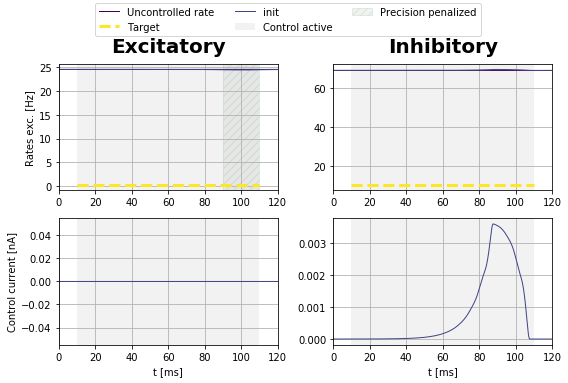

--------- 2


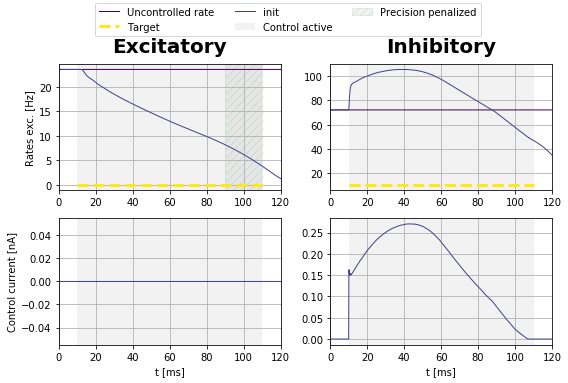

--------- 4


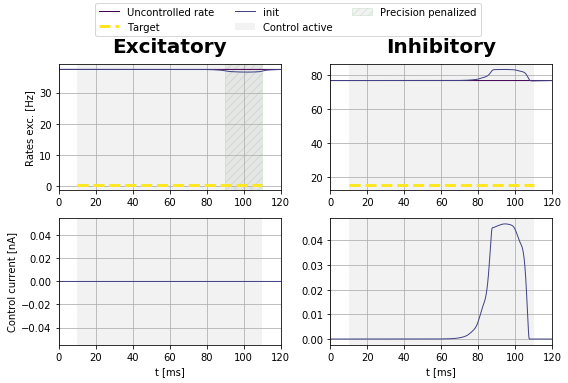

--------- 6


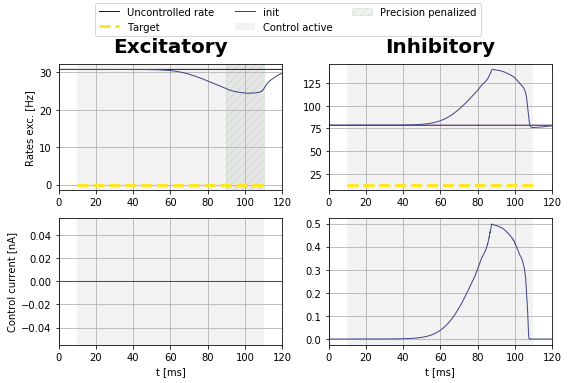

--------- 8


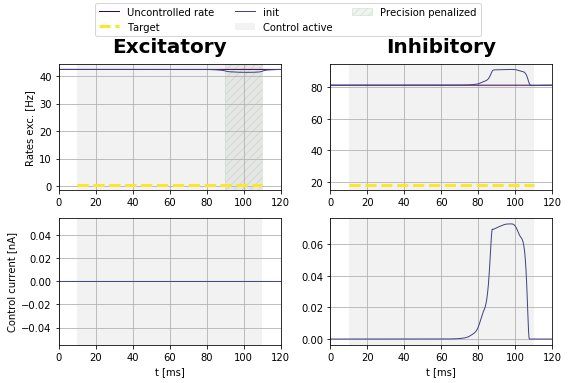

--------- 10


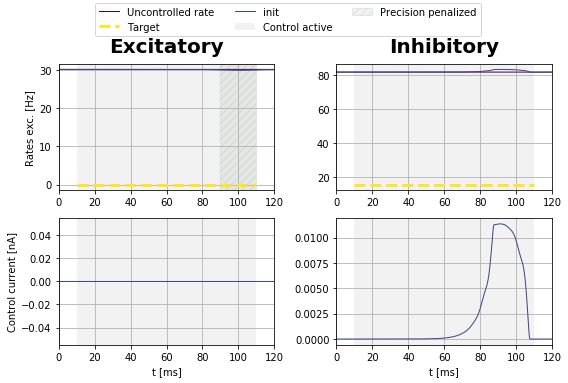

--------- 12


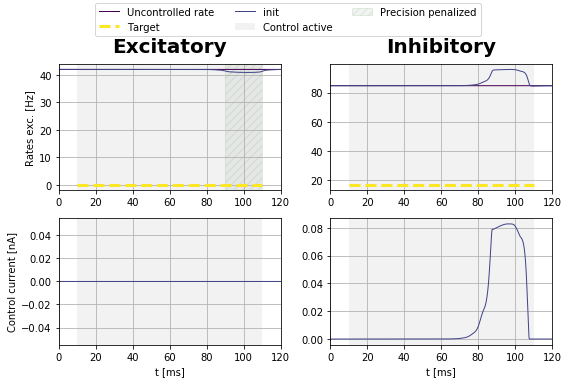

--------- 14


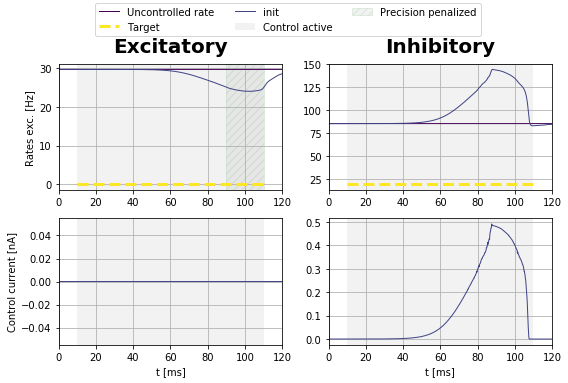

--------- 16


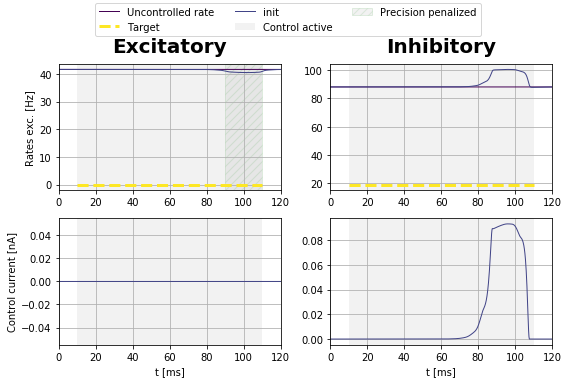

--------- 18


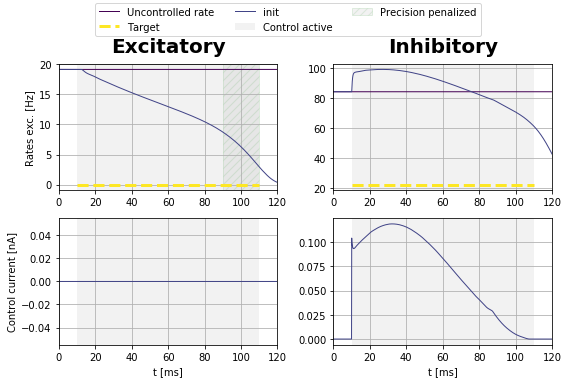

--------- 20


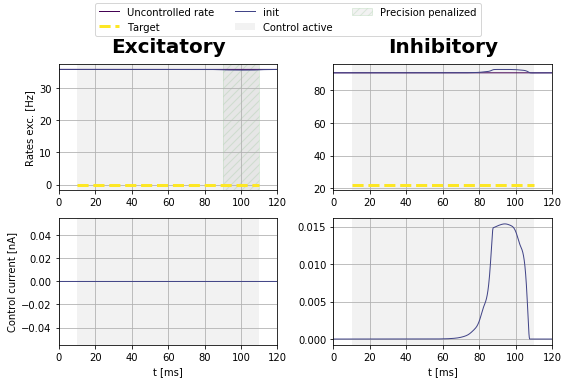

--------- 22


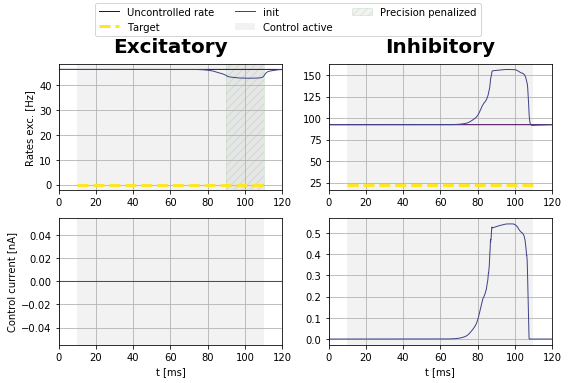

--------- 24


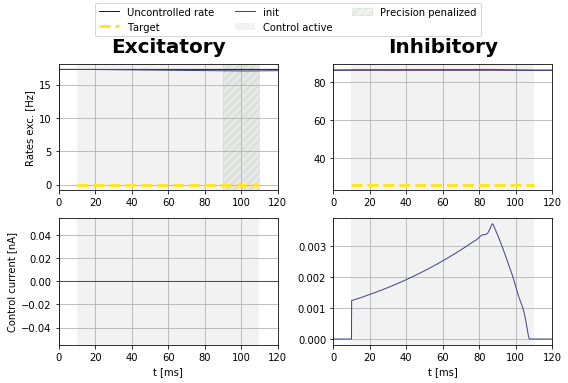

--------- 26


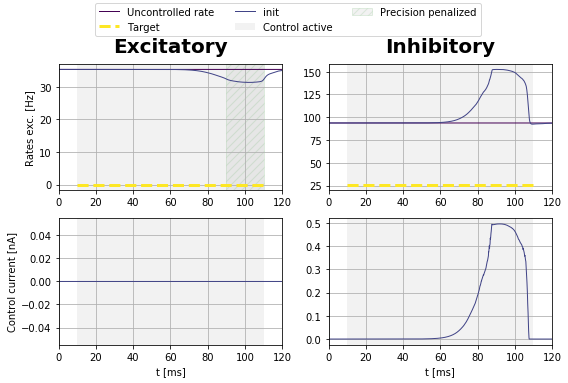

--------- 28


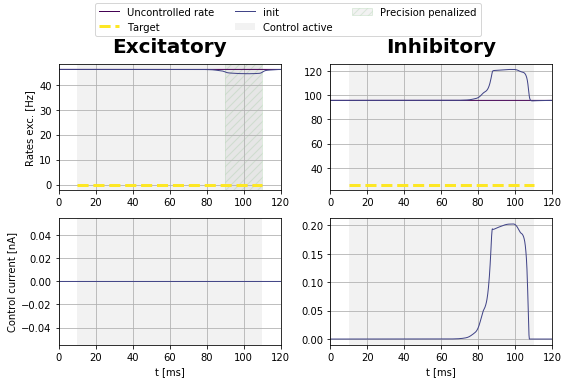

--------- 30


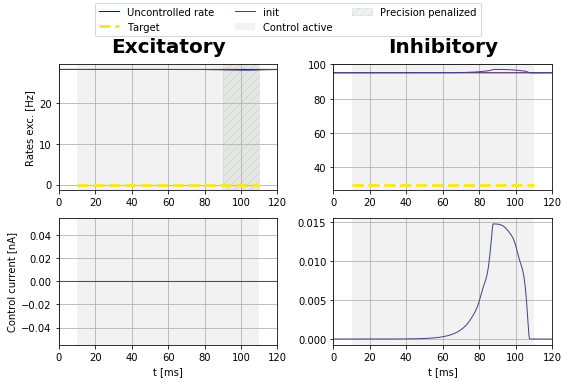

--------- 32


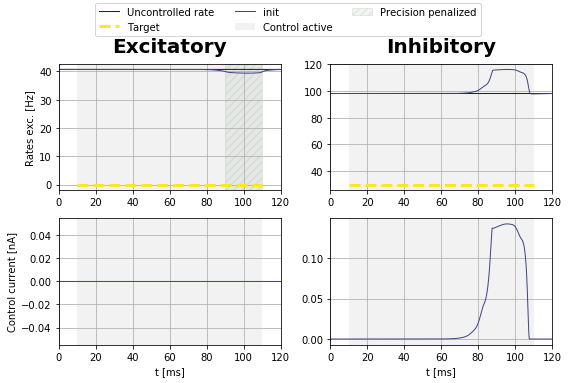

--------- 34


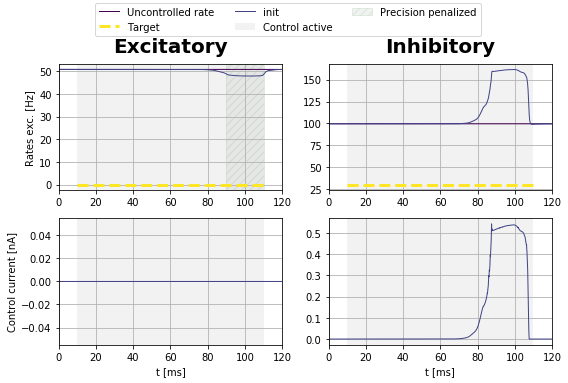

--------- 36


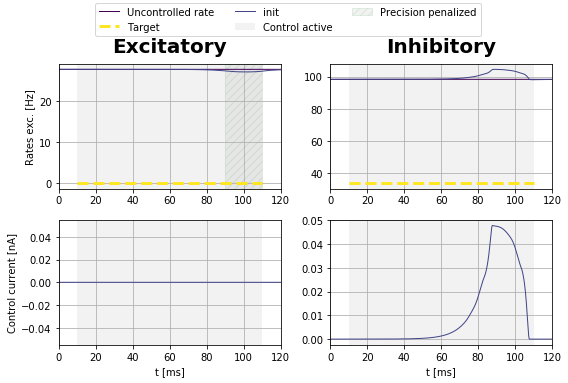

--------- 38


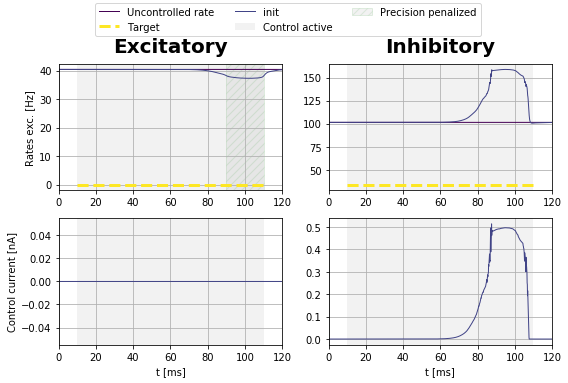

In [15]:

#plot initial guesses
for i in i_range:
    print("---------", i)
        
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    plotFunc.plot_control_current(aln, [bestControl_init[i]],
        [costnode_init[i]], [weights_init[i]], dur,
        dur_pre, dur_post, initVars[i], target[i], '', filename_ = '', transition_time_ = trans_time,
        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)
    plt.show()

In [16]:
found_solution = []
no_solution = []
factor_iteration = 20.
already_tried = [ [] for _ in range(len(exc)) ]

for k in range(len(i_range)**2):
    print('------------------------------------------------------------')
    print('--------------------', k)
    print('------------------------------------------------------------')
        
    print("found solution: ", found_solution)
    print("no solution: ", no_solution)
    
    if len(i_range) == len(found_solution) + len(no_solution):
        print("found solution for all parameters")
        break


    for i in i_range:
        print("------- ", i, exc[i], inh[i])        

        if np.abs(np.mean(bestState_init[i][0,0,-300:]) - target[i][0,0,-1]) < 0.1 * np.abs(
            np.mean(bestState_init[i][0,0,-100:]) - bestState_init[i][0,0,0]) and np.abs(
            np.mean(bestState_init[i][0,1,-100:]) - target[i][0,1,-1]) < 0.5 * np.abs(
            np.mean(bestState_init[i][0,1,-100:]) - bestState_init[i][0,1,0]) and np.amin(
            bestState_init[i][0,0,:]) > target[i][0,0,-1] - 5. and np.amin(
            bestState_init[i][0,1,:]) > target[i][0,1,-1] - 5.:
            # and np.amin(bestState_init[i][0,0,:]) > bestState_init[i][0,0,0] - 1.
            #and np.amin(bestState_init[i][0,1,:]) > bestState_init[i][0,1,0] - 1.:
            if i not in found_solution:
                print("found solution for ", i)
                found_solution.append(i)
            if i in no_solution:
                no_solution.pop(no_solution.index(i))
            continue

            
        closest_ = getclosest(i, found_solution, exc, inh, already_tried[i])
        print("closest index ", closest_)

        weight_ = 10
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        setinit(initVars[i], aln)
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.
            
        if closest_ != -1:
            control0 = bestControl_init[closest_][:,:,n_pre-1:-n_post+1]
            if closest_ not in already_tried[i]:
                already_tried[i].append(closest_)
                        
        if closest_ == -1:
            print("all options tried already")
            if i not in no_solution:
                no_solution.append(i)
                continue

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int(100 * factor_iteration)

        weights_init[i] = cost.getParams()
        
        print("precision vars = ", prec_vars)

        bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)

        j = 1
        while cost_init[i][-j] == 0.:
            j += 1

        weight_ = 10 * cost_uncontrolled[i] / cost_init[i][-j]
        print("weight = ", weight_)
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        setinit(initVars[i], aln)
        control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1]

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int(500 * factor_iteration)

        weights_init[i] = cost.getParams()

        bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        with open(init_file,'wb') as f:
            pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                         costnode_init, weights_init], f)

------------------------------------------------------------
-------------------- 0
------------------------------------------------------------
found solution:  []
no solution:  []
-------  0 0.4000000000000001 0.3500000000000001
no solutions found
closest index  -1
set cost params:  1.0 10.0 0.0
all options tried already
-------  2 0.4000000000000001 0.3750000000000001
no solutions found
closest index  -1
set cost params:  1.0 10.0 0.0
all options tried already
-------  4 0.4500000000000001 0.3750000000000001
no solutions found
closest index  -1
set cost params:  1.0 10.0 0.0
all options tried already
-------  6 0.4250000000000001 0.40000000000000013
no solutions found
closest index  -1
set cost params:  1.0 10.0 0.0
all options tried already
-------  8 0.47500000000000014 0.40000000000000013
no solutions found
closest index  -1
set cost params:  1.0 10.0 0.0
all options tried already
-------  10 0.4250000000000001 0.42500000000000016
no solutions found
closest index  -1
set cost par

In [23]:
factor_iteration = 20
full_converge = False
conv_init = [[False]*2] * len(exc)

for i in range(len(conv_init)):
    if i not in i_range:
        conv_init[i] = [True, True]
        
counter = 0

while full_converge == False:
    
    print("------------------------------------------------")
    print('-------------------------', counter)
    
    if counter > 20:
        break
        
    print(conv_init[::i_stepsize])
    full_converge = True
    
    for conv in conv_init[::i_stepsize]:
        if not conv[0]:
            full_converge = False
            break
        if not conv[1]:
            full_converge = False
            break
    
    if full_converge:
        print("full convergence")
        break

    for i in i_range:        

        print("------- ", i, exc[i], inh[i])
        
        if conv_init[i] == [True, True]:
            continue
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.
        
        j = 1
        while cost_init[i][-j] == 0.:
            j += 1
                       
        weight_ = (factor_we * weights_init[i][1] * cost_uncontrolled[i] / cost_init[i][-j]
                   + factor_ws * weights_init[i][2] * cost_uncontrolled[i] / cost_init[i][-j]) - 1
        print("weight = ", weight_)
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        setinit(initVars[i], aln)
        control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1]

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int( 500 * factor_iteration )

        weights_init[i] = cost.getParams()

        bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        with open(init_file,'wb') as f:
            pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                         costnode_init, weights_init], f)
            
        if j == cost_init[i].shape[0]-1:
            print("converged for ", i)
            if conv_init[i][0]:
                conv_init[i] = [True, True]
            else:
                conv_init[i] = [True, False]
            continue
    
        print("no convergence")
            
    counter += 1

------------------------------------------------
------------------------- 0
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
weight =  8399.564617623033
set cost params:  1.0 8399.564617623033 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5875.262077210273
Gradient descend method:  None
RUN  1 , total integrated cost =  5875.261556800743
RUN  2 , total integrated cost =  5875.2615568007395
RUN  3 , total integrated cost =  587

ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  5875.261556800737
RUN  5 , total integrated cost =  5875.261556800737
Control only changes marginally.
RUN  5 , total integrated cost =  5875.261556800737
Improved over  5  iterations in  0.678943899999922  seconds by  8.857639528514483e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.62743704175566 -56.62744035629551
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  314.13073241482886
set cost params:  1.0 314.13073241482886 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13145.60007871334
Gradient descend method:  None
RUN  1 , total integrated cost =  13145.304511050788
RUN  2 , total integrated cost =  13145.304119124314
RUN  3 , total integrated cost =  13145.304119124306
RUN  4 , total integrated cost =  13145.304119124305


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  13145.3041191243
RUN  6 , total integrated cost =  13145.3041191243
Control only changes marginally.
RUN  6 , total integrated cost =  13145.3041191243
Improved over  6  iterations in  0.6123157000001811  seconds by  0.0022513965681980608  percent.
Problem in initial value trasfer:  Vmean_exc -56.67314655952453 -56.67324589821743
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  167.60079881078056
set cost params:  1.0 167.60079881078056 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16881.474558474256
Gradient descend method:  None
RUN  1 , total integrated cost =  16881.05162487901
RUN  2 , total integrated cost =  16881.051624879008


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16881.051624879008
Control only changes marginally.
RUN  3 , total integrated cost =  16881.051624879008
Improved over  3  iterations in  0.34975530000019717  seconds by  0.0025053119251055023  percent.
Problem in initial value trasfer:  Vmean_exc -56.6880469917771 -56.688157756946666
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  132.9785493390067
set cost params:  1.0 132.9785493390067 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16877.083721991
Gradient descend method:  None
RUN  1 , total integrated cost =  16876.672668452917
RUN  2 , total integrated cost =  16876.67266845291
RUN  3 , total integrated cost =  16876.672668452902


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16876.672668452902
Control only changes marginally.
RUN  4 , total integrated cost =  16876.672668452902
Improved over  4  iterations in  0.595594599999913  seconds by  0.002435572074347192  percent.
Problem in initial value trasfer:  Vmean_exc -56.68677826296244 -56.686893904755046
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  105.831497129254
set cost params:  1.0 105.831497129254 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16629.53445941403
Gradient descend method:  None
RUN  1 , total integrated cost =  16629.180618173992
RUN  2 , total integrated cost =  16629.180618173985
RUN  3 , total integrated cost =  16629.18061817398


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16629.18061817398
Control only changes marginally.
RUN  4 , total integrated cost =  16629.18061817398
Improved over  4  iterations in  0.5686875999999756  seconds by  0.0021277880082095635  percent.
Problem in initial value trasfer:  Vmean_exc -56.68553986570929 -56.68566315631459
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  1156.084244644424
set cost params:  1.0 1156.084244644424 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12662.174782638445
Gradient descend method:  None
RUN  1 , total integrated cost =  12662.172989475233
RUN  2 , total integrated cost =  12662.172989475217
RUN  3 , total integrated cost =  12662.17298947521


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  12662.172989475204
RUN  5 , total integrated cost =  12662.172989475204
Control only changes marginally.
RUN  5 , total integrated cost =  12662.172989475204
Improved over  5  iterations in  0.5823894999998629  seconds by  1.4161573915316694e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66852047434785 -56.668538013788115
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  4295.067187142992
set cost params:  1.0 4295.067187142992 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2929.097508900872
Gradient descend method:  None
RUN  1 , total integrated cost =  2929.0797432422796
RUN  2 , total integrated cost =  2929.079743242274


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  2929.0797432422733
RUN  4 , total integrated cost =  2929.0797432422733
Control only changes marginally.
RUN  4 , total integrated cost =  2929.0797432422733
Improved over  4  iterations in  0.5605349000002207  seconds by  0.0006065232906991014  percent.
Problem in initial value trasfer:  Vmean_exc -56.65617915344621 -56.65617261774308
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  32.62499350149398
set cost params:  1.0 32.62499350149398 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20083.309576502026
Gradient descend method:  None
RUN  1 , total integrated cost =  20082.98725776966
RUN  2 , total integrated cost =  20082.983390432135
RUN  3 , total integrated cost =  20082.98339043212
RUN  4 , total integrated cost =  20082.98339043212


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  4 , total integrated cost =  20082.98339043212
Improved over  4  iterations in  0.4795395000001008  seconds by  0.0016241649249337797  percent.
Problem in initial value trasfer:  Vmean_exc -56.69487090918338 -56.69502059594128
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  49.762955739498466
set cost params:  1.0 49.762955739498466 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15758.75436962023
Gradient descend method:  None
RUN  1 , total integrated cost =  15758.415951117238
RUN  2 , total integrated cost =  15758.41595111723
RUN  3 , total integrated cost =  15758.415951117227
RUN  4 , total integrated cost =  15758.415951117224
RUN  5 , total integrated cost =  15758.415951117222


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  15758.415951117222
Control only changes marginally.
RUN  6 , total integrated cost =  15758.415951117222
Improved over  6  iterations in  0.6785482999998749  seconds by  0.002147495259279708  percent.
Problem in initial value trasfer:  Vmean_exc -56.68198270550435 -56.682129751274296
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  190.4823480481463
set cost params:  1.0 190.4823480481463 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7497.788587747628
Gradient descend method:  None
RUN  1 , total integrated cost =  7497.668227131916
RUN  2 , total integrated cost =  7497.668227131914
RUN  3 , total integrated cost =  7497.668227131914
Control only changes marginally.
RUN  3 , total integrated cost =  7497.668227131914
Improved over  3  iterations in  0.4703458000003593  seconds by  0.0016052815347507021  percent.


ERROR:root:Problem in initial value trasfer


Problem in initial value trasfer:  Vmean_exc -56.63373974361251 -56.63378524372622
no convergence
------------------------------------------------
------------------------- 1
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
weight =  8437.372341815577
set cost params:  1.0 8437.372341815577 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5875.381841259775
Gradient descend method:  None
RUN  1 , total integrated cost =  5875.38135

ERROR:root:Problem in initial value trasfer


RUN  9 , total integrated cost =  5875.381350166518
Control only changes marginally.
RUN  9 , total integrated cost =  5875.381350166518
Improved over  9  iterations in  0.6363589000002321  seconds by  8.358490902082849e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.62743781577131 -56.627441116312085
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  324.0506750392132
set cost params:  1.0 324.0506750392132 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13156.674072183538
Gradient descend method:  None
RUN  1 , total integrated cost =  13156.391130751375
RUN  2 , total integrated cost =  13156.39112588426
RUN  3 , total integrated cost =  13156.391125873537
RUN  4 , total integrated cost =  13156.391125873535


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  13156.391125873532
RUN  6 , total integrated cost =  13156.391125873532
Control only changes marginally.
RUN  6 , total integrated cost =  13156.391125873532
Improved over  6  iterations in  0.47428020000006654  seconds by  0.002150591467525942  percent.
Problem in initial value trasfer:  Vmean_exc -56.67321830383802 -56.673315364076
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  173.25374085392923
set cost params:  1.0 173.25374085392923 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16897.207475718114
Gradient descend method:  None
RUN  1 , total integrated cost =  16896.842613594166
RUN  2 , total integrated cost =  16896.84261359416


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16896.842613594155
RUN  4 , total integrated cost =  16896.842613594155
Control only changes marginally.
RUN  4 , total integrated cost =  16896.842613594155
Improved over  4  iterations in  0.4745582000000468  seconds by  0.002159304278436025  percent.
Problem in initial value trasfer:  Vmean_exc -56.68810882222281 -56.688217237522935
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  137.45102966455823
set cost params:  1.0 137.45102966455823 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16892.98680277203
Gradient descend method:  None
RUN  1 , total integrated cost =  16892.617339609515
RUN  2 , total integrated cost =  16892.617337846437
RUN  3 , total integrated cost =  16892.617337839554
RUN  4 , total integrated cost =  16892.617337839532
RUN  5 , total integrated cost =  16892.617337839525
RUN  6 , total integrated cost =  16892.61733783952


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  16892.61733783952
Control only changes marginally.
RUN  7 , total integrated cost =  16892.61733783952
Improved over  7  iterations in  0.4362476000001152  seconds by  0.0021870906360135223  percent.
Problem in initial value trasfer:  Vmean_exc -56.68684153636049 -56.68695276853517
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  109.36101142293579
set cost params:  1.0 109.36101142293579 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16645.447583253215
Gradient descend method:  None
RUN  1 , total integrated cost =  16645.065433404532
RUN  2 , total integrated cost =  16645.065433262964
RUN  3 , total integrated cost =  16645.065433262953
RUN  4 , total integrated cost =  16645.065433262946


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  16645.065433262946
Control only changes marginally.
RUN  5 , total integrated cost =  16645.065433262946
Improved over  5  iterations in  0.5110259999996742  seconds by  0.00229582285702179  percent.
Problem in initial value trasfer:  Vmean_exc -56.68560730932671 -56.68572811941966
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  1162.018049654281
set cost params:  1.0 1162.018049654281 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12662.542460712239
Gradient descend method:  None
RUN  1 , total integrated cost =  12662.540762170855
RUN  2 , total integrated cost =  12662.540759768295
RUN  3 , total integrated cost =  12662.540759767538
RUN  4 , total integrated cost =  12662.540759767528
RUN  5 , total integrated cost =  12662.540759767524


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  12662.540759767524
Control only changes marginally.
RUN  6 , total integrated cost =  12662.540759767524
Improved over  6  iterations in  0.741534799999954  seconds by  1.3432884600206307e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66852303221786 -56.66854048972214
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  4370.17370697535
set cost params:  1.0 4370.17370697535 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2930.018674106412
Gradient descend method:  None
RUN  1 , total integrated cost =  2930.0030733102817
RUN  2 , total integrated cost =  2930.003072942118
RUN  3 , total integrated cost =  2930.0030729420937
RUN  4 , total integrated cost =  2930.003072942089
RUN  5 , total integrated cost =  2930.003072942086


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  2930.0030729420855
RUN  7 , total integrated cost =  2930.0030729420855
Control only changes marginally.
RUN  7 , total integrated cost =  2930.0030729420855
Improved over  7  iterations in  0.8709696999999323  seconds by  0.0005324595527156362  percent.
Problem in initial value trasfer:  Vmean_exc -56.65609533104063 -56.656088896622585
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  33.6233176610368
set cost params:  1.0 33.6233176610368 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20103.090622566095
Gradient descend method:  None
RUN  1 , total integrated cost =  20102.7208550879


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  20102.7208550879
Control only changes marginally.
RUN  2 , total integrated cost =  20102.7208550879
Improved over  2  iterations in  0.26428820000000997  seconds by  0.0018393563713061667  percent.
Problem in initial value trasfer:  Vmean_exc -56.69492666288805 -56.69507404420151
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  51.320202770763224
set cost params:  1.0 51.320202770763224 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15774.239388445385
Gradient descend method:  None
RUN  1 , total integrated cost =  15773.92717148454
RUN  2 , total integrated cost =  15773.927171484534
RUN  3 , total integrated cost =  15773.927171484527
RUN  4 , total integrated cost =  15773.927171484522
RUN  5 , total integrated cost =  15773.92717148452


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  15773.92717148452
Control only changes marginally.
RUN  6 , total integrated cost =  15773.92717148452
Improved over  6  iterations in  0.7394426999999268  seconds by  0.0019792837751282377  percent.
Problem in initial value trasfer:  Vmean_exc -56.68205114298517 -56.68219577501734
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  195.68128849813743
set cost params:  1.0 195.68128849813743 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7503.277068127002
Gradient descend method:  None
RUN  1 , total integrated cost =  7503.158527920435
RUN  2 , total integrated cost =  7503.158527920432
RUN  3 , total integrated cost =  7503.158527920431
RUN  4 , total integrated cost =  7503.1585279204255


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  7503.1585279204255
Control only changes marginally.
RUN  5 , total integrated cost =  7503.1585279204255
Improved over  5  iterations in  0.8544001000000208  seconds by  0.0015798457860540793  percent.
Problem in initial value trasfer:  Vmean_exc -56.633792581258504 -56.633837084760344
no convergence
------------------------------------------------
------------------------- 2
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  4 , total integrated cost =  5875.5000950870035
Improved over  4  iterations in  0.8858359999999266  seconds by  8.928877932135038e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.627438646129974 -56.627441931651944
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  334.0328855253843
set cost params:  1.0 334.0328855253843 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13167.270024278027
Gradient descend method:  None
RUN  1 , total integrated cost =  13167.003714872026
RUN  2 , total integrated cost =  13167.003714872022


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  13167.003714872022
Control only changes marginally.
RUN  3 , total integrated cost =  13167.003714872022
Improved over  3  iterations in  0.5118969000000106  seconds by  0.0020225104027815632  percent.
Problem in initial value trasfer:  Vmean_exc -56.673289601632014 -56.673384399728185
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  178.96273541491516
set cost params:  1.0 178.96273541491516 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16912.38122189405
Gradient descend method:  None
RUN  1 , total integrated cost =  16912.000758748178
RUN  2 , total integrated cost =  16912.000758748167
RUN  3 , total integrated cost =  16912.000758748163
RUN  4 , total integrated cost =  16912.000758748163
Control only changes marginally.
RUN  4 , total integrated cost =  16912.000758748163
Improved over  4  iterations in  0.6313129999998637  seconds by  0.0022496131141735987  percent.


ERROR:root:Problem in initial value trasfer


Problem in initial value trasfer:  Vmean_exc -56.688170961357876 -56.68827701312178
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  141.9724895199678
set cost params:  1.0 141.9724895199678 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16908.34717153689
Gradient descend method:  None
RUN  1 , total integrated cost =  16907.977762639748
RUN  2 , total integrated cost =  16907.97776263974


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16907.97776263974
Control only changes marginally.
RUN  3 , total integrated cost =  16907.97776263974
Improved over  3  iterations in  0.5324828000002526  seconds by  0.00218477236954584  percent.
Problem in initial value trasfer:  Vmean_exc -56.68690395715133 -56.6870128261879
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  112.93275364147915
set cost params:  1.0 112.93275364147915 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16660.755351684842
Gradient descend method:  None
RUN  1 , total integrated cost =  16660.388607918052


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  16660.388607918052
Control only changes marginally.
RUN  2 , total integrated cost =  16660.388607918052
Improved over  2  iterations in  0.2741458000000421  seconds by  0.002201243335292702  percent.
Problem in initial value trasfer:  Vmean_exc -56.68567626516447 -56.68579450913986
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  1167.9534916123011
set cost params:  1.0 1167.9534916123011 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12662.906846858708
Gradient descend method:  None
RUN  1 , total integrated cost =  12662.905072274028
RUN  2 , total integrated cost =  12662.90507227402
RUN  3 , total integrated cost =  12662.905072274016


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  12662.905072274016
Control only changes marginally.
RUN  4 , total integrated cost =  12662.905072274016
Improved over  4  iterations in  0.5844757999998365  seconds by  1.401403891065911e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.668525744011085 -56.66854311463327
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  4445.2095057417555
set cost params:  1.0 4445.2095057417555 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2930.9090801137754
Gradient descend method:  None
RUN  1 , total integrated cost =  2930.8931830527854
RUN  2 , total integrated cost =  2930.8931829092203
RUN  3 , total integrated cost =  2930.893182909183
RUN  4 , total integrated cost =  2930.893182909179
RUN  5 , total integrated cost =  2930.893182909178


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  2930.8931829091775
RUN  7 , total integrated cost =  2930.8931829091775
Control only changes marginally.
RUN  7 , total integrated cost =  2930.8931829091775
Improved over  7  iterations in  0.8269162999999935  seconds by  0.0005423984218992928  percent.
Problem in initial value trasfer:  Vmean_exc -56.65601157990119 -56.656005247249006
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  34.64775604819163
set cost params:  1.0 34.64775604819163 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20122.52136691941
Gradient descend method:  None
RUN  1 , total integrated cost =  20122.23144653356
RUN  2 , total integrated cost =  20122.230760113365
RUN  3 , total integrated cost =  20122.230760113358
RUN  4 , total integrated cost =  20122.23076011335


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  20122.23076011335
Control only changes marginally.
RUN  5 , total integrated cost =  20122.23076011335
Improved over  5  iterations in  0.6350115999998707  seconds by  0.0014441868429884153  percent.
Problem in initial value trasfer:  Vmean_exc -56.69497192989648 -56.695117411714286
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  52.904415656909904
set cost params:  1.0 52.904415656909904 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15789.378578022
Gradient descend method:  None
RUN  1 , total integrated cost =  15789.058029796897
RUN  2 , total integrated cost =  15789.057997624599
RUN  3 , total integrated cost =  15789.057997624595
RUN  4 , total integrated cost =  15789.057997624594
RUN  5 , total integrated cost =  15789.057997624588


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  15789.057997624588
Control only changes marginally.
RUN  6 , total integrated cost =  15789.057997624588
Improved over  6  iterations in  0.6352613999997629  seconds by  0.0020303547465658767  percent.
Problem in initial value trasfer:  Vmean_exc -56.68212019717075 -56.682262404817656
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  200.90157405519506
set cost params:  1.0 200.90157405519506 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7508.531795053429
Gradient descend method:  None
RUN  1 , total integrated cost =  7508.423949407836
RUN  2 , total integrated cost =  7508.423896000462
RUN  3 , total integrated cost =  7508.423896000459
RUN  4 , total integrated cost =  7508.423896000456


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  7508.423896000456
Control only changes marginally.
RUN  5 , total integrated cost =  7508.423896000456
Improved over  5  iterations in  0.7811919999999191  seconds by  0.001437019325720712  percent.
Problem in initial value trasfer:  Vmean_exc -56.6338396659231 -56.633883281375155
no convergence
------------------------------------------------
------------------------- 3
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
weig

ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  5875.617803438702
RUN  6 , total integrated cost =  5875.617803438702
Control only changes marginally.
RUN  6 , total integrated cost =  5875.617803438702
Improved over  6  iterations in  0.8047424999999748  seconds by  8.112677988947326e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.62743940413393 -56.62744267594498
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  344.07504280666996
set cost params:  1.0 344.07504280666996 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13177.39726706534
Gradient descend method:  None
RUN  1 , total integrated cost =  13177.179059220754
RUN  2 , total integrated cost =  13177.179059220747
RUN  3 , total integrated cost =  13177.179059220744


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  13177.179059220742
RUN  5 , total integrated cost =  13177.179059220742
Control only changes marginally.
RUN  5 , total integrated cost =  13177.179059220742
Improved over  5  iterations in  0.7217697999999473  seconds by  0.0016559252193530938  percent.
Problem in initial value trasfer:  Vmean_exc -56.67335366809582 -56.67344641507148
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  184.7261875093992
set cost params:  1.0 184.7261875093992 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16926.917103560874
Gradient descend method:  None
RUN  1 , total integrated cost =  16926.57030538923
RUN  2 , total integrated cost =  16926.570305389207


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16926.570305389207
Control only changes marginally.
RUN  3 , total integrated cost =  16926.570305389207
Improved over  3  iterations in  0.342040999999881  seconds by  0.0020487970109854814  percent.
Problem in initial value trasfer:  Vmean_exc -56.688234203967525 -56.688337837274204
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  146.54141899657182
set cost params:  1.0 146.54141899657182 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16923.114036276656
Gradient descend method:  None
RUN  1 , total integrated cost =  16922.7698496407
RUN  2 , total integrated cost =  16922.769731254895
RUN  3 , total integrated cost =  16922.769731134606
RUN  4 , total integrated cost =  16922.769731134296
RUN  5 , total integrated cost =  16922.769731134285
RUN  6 , total integrated cost =  16922.769731134267


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  16922.769731134267
Control only changes marginally.
RUN  7 , total integrated cost =  16922.769731134267
Improved over  7  iterations in  0.6498854000001302  seconds by  0.002034525925026287  percent.
Problem in initial value trasfer:  Vmean_exc -56.68696164321414 -56.687068335445716
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  116.54559889180995
set cost params:  1.0 116.54559889180995 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16675.49471121791
Gradient descend method:  None
RUN  1 , total integrated cost =  16675.178938567355
RUN  2 , total integrated cost =  16675.178395618565


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16675.178395618554
RUN  4 , total integrated cost =  16675.178395618554
Control only changes marginally.
RUN  4 , total integrated cost =  16675.178395618554
Improved over  4  iterations in  0.3393768999999338  seconds by  0.0018968888469856893  percent.
Problem in initial value trasfer:  Vmean_exc -56.685736902344686 -56.68585289920906
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  1173.8905562937066
set cost params:  1.0 1173.8905562937066 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12663.267582232924
Gradient descend method:  None
RUN  1 , total integrated cost =  12663.265964446095
RUN  2 , total integrated cost =  12663.265964325485
RUN  3 , total integrated cost =  12663.265964325481
RUN  4 , total integrated cost =  12663.265964325474
RUN  5 , total integrated cost =  12663.265964325468


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  12663.265964325468
Control only changes marginally.
RUN  6 , total integrated cost =  12663.265964325468
Improved over  6  iterations in  0.5207049999999072  seconds by  1.2776382121160168e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66852822589329 -56.668545517031674
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  4520.177342563413
set cost params:  1.0 4520.177342563413 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2931.7669015361757
Gradient descend method:  None
RUN  1 , total integrated cost =  2931.751863442893


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  2931.7518634428925
RUN  3 , total integrated cost =  2931.7518634428925
Control only changes marginally.
RUN  3 , total integrated cost =  2931.7518634428925
Improved over  3  iterations in  0.3699750999999196  seconds by  0.0005129361845064295  percent.
Problem in initial value trasfer:  Vmean_exc -56.65592845440465 -56.65592222330988
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  35.698259161487854
set cost params:  1.0 35.698259161487854 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20141.869896755343
Gradient descend method:  None
RUN  1 , total integrated cost =  20141.485385566542
RUN  2 , total integrated cost =  20141.484776273785


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  20141.484776273785
Control only changes marginally.
RUN  3 , total integrated cost =  20141.484776273785
Improved over  3  iterations in  0.36783029999969585  seconds by  0.0019120393664167068  percent.
Problem in initial value trasfer:  Vmean_exc -56.695025319810824 -56.69516861534996
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  54.5151492877485
set cost params:  1.0 54.5151492877485 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15804.109234355532
Gradient descend method:  None
RUN  1 , total integrated cost =  15803.805829745508
RUN  2 , total integrated cost =  15803.80554990235


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  15803.805549902349
RUN  4 , total integrated cost =  15803.805549902349
Control only changes marginally.
RUN  4 , total integrated cost =  15803.805549902349
Improved over  4  iterations in  0.37343860000009954  seconds by  0.0019215537470671507  percent.
Problem in initial value trasfer:  Vmean_exc -56.68218826323909 -56.682328017926906
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  206.14243827614115
set cost params:  1.0 206.14243827614115 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7513.5926193623445
Gradient descend method:  None
RUN  1 , total integrated cost =  7513.478123352731
RUN  2 , total integrated cost =  7513.4780334825755
RUN  3 , total integrated cost =  7513.478033390974
RUN  4 , total integrated cost =  7513.478033390557
RUN  5 , total integrated cost =  7513.478033390556
RUN  6 , total integrated cost =  7513.4780333905555
RUN  7 , total integrated cost =  7513.478033390552

ERROR:root:Problem in initial value trasfer


RUN  9 , total integrated cost =  7513.478033390549
RUN  10 , total integrated cost =  7513.478033390549
Control only changes marginally.
RUN  10 , total integrated cost =  7513.478033390549
Improved over  10  iterations in  0.6256849999999758  seconds by  0.0015250490358056368  percent.
Problem in initial value trasfer:  Vmean_exc -56.633887671343565 -56.633930378661475
no convergence
------------------------------------------------
------------------------- 4
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, Tr

ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  5875.7344904310385
RUN  7 , total integrated cost =  5875.7344904310385
Control only changes marginally.
RUN  7 , total integrated cost =  5875.7344904310385
Improved over  7  iterations in  0.4357202999999572  seconds by  8.727140752284868e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.62744018912876 -56.62744344674007
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  354.174688781635
set cost params:  1.0 354.174688781635 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13187.151741950487
Gradient descend method:  None
RUN  1 , total integrated cost =  13186.93088365761


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  13186.930883657606
RUN  3 , total integrated cost =  13186.930883657606
Control only changes marginally.
RUN  3 , total integrated cost =  13186.930883657606
Improved over  3  iterations in  0.2585319999998319  seconds by  0.0016747990559480286  percent.
Problem in initial value trasfer:  Vmean_exc -56.67341811755011 -56.673508804145186
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  190.54244275506056
set cost params:  1.0 190.54244275506056 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16940.865072786277
Gradient descend method:  None
RUN  1 , total integrated cost =  16940.55938545614
RUN  2 , total integrated cost =  16940.55938545613


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16940.55938545613
Control only changes marginally.
RUN  3 , total integrated cost =  16940.55938545613
Improved over  3  iterations in  0.25990479999973104  seconds by  0.0018044375469230545  percent.
Problem in initial value trasfer:  Vmean_exc -56.688290071198054 -56.68839156547417
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  151.1564523273136
set cost params:  1.0 151.1564523273136 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16937.36565646381
Gradient descend method:  None
RUN  1 , total integrated cost =  16937.03284217799
RUN  2 , total integrated cost =  16937.032841981163


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16937.032841980625
RUN  4 , total integrated cost =  16937.03284198062
RUN  5 , total integrated cost =  16937.03284198062
Control only changes marginally.
RUN  5 , total integrated cost =  16937.03284198062
Improved over  5  iterations in  0.30038839999997435  seconds by  0.0019649719439343016  percent.
Problem in initial value trasfer:  Vmean_exc -56.68701867036929 -56.687123205233476
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  120.19842376215173
set cost params:  1.0 120.19842376215173 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16689.782203550698
Gradient descend method:  None
RUN  1 , total integrated cost =  16689.45249916356
RUN  2 , total integrated cost =  16689.451765605965
RUN  3 , total integrated cost =  16689.45176499164
RUN  4 , total integrated cost =  16689.451764991634


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  16689.45176499163
RUN  6 , total integrated cost =  16689.451764991627
RUN  7 , total integrated cost =  16689.451764991627
Control only changes marginally.
RUN  7 , total integrated cost =  16689.451764991627
Improved over  7  iterations in  0.3826420999998845  seconds by  0.0019798853875983013  percent.
Problem in initial value trasfer:  Vmean_exc -56.685798481808135 -56.685912179092234
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  1179.8292306320093
set cost params:  1.0 1179.8292306320093 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12663.625221783284
Gradient descend method:  None
RUN  1 , total integrated cost =  12663.623512564162
RUN  2 , total integrated cost =  12663.623510275349


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  12663.623510275342
RUN  4 , total integrated cost =  12663.62351027534
RUN  5 , total integrated cost =  12663.62351027534
Control only changes marginally.
RUN  5 , total integrated cost =  12663.62351027534
Improved over  5  iterations in  0.3749407999998766  seconds by  1.3515150001808252e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.6685307856755 -56.66854799485736
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  4595.079826546158
set cost params:  1.0 4595.079826546158 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2932.5941245402973
Gradient descend method:  None
RUN  1 , total integrated cost =  2932.5807540465853
RUN  2 , total integrated cost =  2932.5807439807236
RUN  3 , total integrated cost =  2932.5807439635423


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  2932.580743963531
RUN  5 , total integrated cost =  2932.580743963529
RUN  6 , total integrated cost =  2932.580743963529
Control only changes marginally.
RUN  6 , total integrated cost =  2932.580743963529
Improved over  6  iterations in  0.3664568999997755  seconds by  0.0004562710078488408  percent.
Problem in initial value trasfer:  Vmean_exc -56.65585315369691 -56.6558470150784
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  36.77478761444529
set cost params:  1.0 36.77478761444529 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20160.79397762317
Gradient descend method:  None
RUN  1 , total integrated cost =  20160.495440986848
RUN  2 , total integrated cost =  20160.492950602245
RUN  3 , total integrated cost =  20160.49295056319
RUN  4 , total integrated cost =  20160.492950563017
RUN  5 , total integrated cost =  20160.49295056299


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  20160.492950562984
RUN  7 , total integrated cost =  20160.492950562977
RUN  8 , total integrated cost =  20160.492950562977
Control only changes marginally.
RUN  8 , total integrated cost =  20160.492950562977
Improved over  8  iterations in  0.43371179999985543  seconds by  0.0014931309775079171  percent.
Problem in initial value trasfer:  Vmean_exc -56.69507223731032 -56.69521353858123
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  56.15198757325872
set cost params:  1.0 56.15198757325872 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15818.482759589955
Gradient descend method:  None
RUN  1 , total integrated cost =  15818.183975708569
RUN  2 , total integrated cost =  15818.183975708554
RUN  3 , total integrated cost =  15818.18397570855


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  15818.18397570855
Control only changes marginally.
RUN  4 , total integrated cost =  15818.18397570855
Improved over  4  iterations in  0.28301120000014635  seconds by  0.0018888276830750783  percent.
Problem in initial value trasfer:  Vmean_exc -56.68225602073056 -56.682393357340246
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  211.40313151511504
set cost params:  1.0 211.40313151511504 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7518.440585591531
Gradient descend method:  None
RUN  1 , total integrated cost =  7518.334262268952
RUN  2 , total integrated cost =  7518.33426226895
RUN  3 , total integrated cost =  7518.334262268949
RUN  4 , total integrated cost =  7518.334262268948
RUN  5 , total integrated cost =  7518.334262268945


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  7518.334262268945
Control only changes marginally.
RUN  6 , total integrated cost =  7518.334262268945
Improved over  6  iterations in  0.433792799999992  seconds by  0.0014141672249081694  percent.
Problem in initial value trasfer:  Vmean_exc -56.633934325123896 -56.6339761487813
no convergence
------------------------------------------------
------------------------- 5
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
weig

ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  5875.850167927753
RUN  7 , total integrated cost =  5875.850167927753
Control only changes marginally.
RUN  7 , total integrated cost =  5875.850167927753
Improved over  7  iterations in  0.4770266000000447  seconds by  8.61192734191718e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.62744096644583 -56.627444209995474
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  364.3297792530252
set cost params:  1.0 364.3297792530252 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13196.484966620936
Gradient descend method:  None
RUN  1 , total integrated cost =  13196.28281903806
RUN  2 , total integrated cost =  13196.28280443102
RUN  3 , total integrated cost =  13196.282804413588
RUN 

ERROR:root:Problem in initial value trasfer


 4 , total integrated cost =  13196.282804413586
RUN  5 , total integrated cost =  13196.282804413586
Control only changes marginally.
RUN  5 , total integrated cost =  13196.282804413586
Improved over  5  iterations in  0.4907220000000052  seconds by  0.0015319398147397578  percent.
Problem in initial value trasfer:  Vmean_exc -56.673475560305576 -56.67356440528279
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  196.41016239544126
set cost params:  1.0 196.41016239544126 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16954.323353249743
Gradient descend method:  None
RUN  1 , total integrated cost =  16954.017889475992
RUN  2 , total integrated cost =  16954.017889475985
RUN  3 , total integrated cost =  16954.017889475985


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  3 , total integrated cost =  16954.017889475985
Improved over  3  iterations in  0.2516497999999956  seconds by  0.001801686610519937  percent.
Problem in initial value trasfer:  Vmean_exc -56.68834585381918 -56.68844520669429
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  155.8161498563536
set cost params:  1.0 155.8161498563536 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16951.09464573731
Gradient descend method:  None
RUN  1 , total integrated cost =  16950.784125653747
RUN  2 , total integrated cost =  16950.783237916537
RUN  3 , total integrated cost =  16950.783237916534


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16950.783237916534
Control only changes marginally.
RUN  4 , total integrated cost =  16950.783237916534
Improved over  4  iterations in  0.3374183000000812  seconds by  0.0018370956406386085  percent.
Problem in initial value trasfer:  Vmean_exc -56.687073541982706 -56.68717598701635
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  123.89017795050593
set cost params:  1.0 123.89017795050593 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16703.535108821827
Gradient descend method:  None
RUN  1 , total integrated cost =  16703.2119050625
RUN  2 , total integrated cost =  16703.211905062493
RUN  3 , total integrated cost =  16703.21190506249
RUN  4 , total integrated cost =  16703.211905062486
RUN  5 , total integrated cost =  16703.211905062482
RUN  6 , total integrated cost =  16703.211905062482


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  6 , total integrated cost =  16703.211905062482
Improved over  6  iterations in  0.40930329999991955  seconds by  0.001934942257662442  percent.
Problem in initial value trasfer:  Vmean_exc -56.685858375371915 -56.685969852820016
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  1185.7694991903406
set cost params:  1.0 1185.7694991903406 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12663.9794229011
Gradient descend method:  None
RUN  1 , total integrated cost =  12663.977716983934
RUN  2 , total integrated cost =  12663.977715928371
RUN  3 , total integrated cost =  12663.977715928368
RUN  4 , total integrated cost =  12663.977715928362
RUN  5 , total integrated cost =  12663.97771592836
RUN  6 , total integrated cost =  12663.977715928359


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  12663.977715928359
Control only changes marginally.
RUN  7 , total integrated cost =  12663.977715928359
Improved over  7  iterations in  0.41094599999996717  seconds by  1.3478960170232313e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.668533316558324 -56.668550444702795
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  4669.919480242588
set cost params:  1.0 4669.919480242588 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2933.394954261308
Gradient descend method:  None
RUN  1 , total integrated cost =  2933.3814239249664
RUN  2 , total integrated cost =  2933.3814166009397
RUN  3 , total integrated cost =  2933.3814166001644
RUN  4 , total integrated cost =  2933.3814166001634
RUN  5 , total integrated cost =  2933.3814166001616
RUN  6 , total integrated cost =  2933.3814166001607
RUN  7 , total integrated cost =  2933.381416600159
RUN  8 , total integrated cost =  2933.3814166001

ERROR:root:Problem in initial value trasfer


RUN  12 , total integrated cost =  2933.38141660015
RUN  13 , total integrated cost =  2933.38141660015
Control only changes marginally.
RUN  13 , total integrated cost =  2933.38141660015
Improved over  13  iterations in  0.6705053000000589  seconds by  0.0004615014810269713  percent.
Problem in initial value trasfer:  Vmean_exc -56.655778137166074 -56.65577209112867
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  37.87724682058145
set cost params:  1.0 37.87724682058145 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20179.594625976173
Gradient descend method:  None
RUN  1 , total integrated cost =  20179.224070640827


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  20179.224070640816
RUN  3 , total integrated cost =  20179.224070640816
Control only changes marginally.
RUN  3 , total integrated cost =  20179.224070640816
Improved over  3  iterations in  0.2698012999999264  seconds by  0.0018362873101551713  percent.
Problem in initial value trasfer:  Vmean_exc -56.6951265832872 -56.69526575715236
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  57.81448805965324
set cost params:  1.0 57.81448805965324 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15832.489749763128
Gradient descend method:  None
RUN  1 , total integrated cost =  15832.207719972546
RUN  2 , total integrated cost =  15832.207351969475
RUN  3 , total integrated cost =  15832.207350983716
RUN  4 , total integrated cost =  15832.20735098371


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  15832.207350983706
RUN  6 , total integrated cost =  15832.207350983706
Control only changes marginally.
RUN  6 , total integrated cost =  15832.207350983706
Improved over  6  iterations in  0.41141379999999117  seconds by  0.001783666270341655  percent.
Problem in initial value trasfer:  Vmean_exc -56.68231980808767 -56.68245482707962
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  216.68289954577267
set cost params:  1.0 216.68289954577267 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7523.099627397278
Gradient descend method:  None
RUN  1 , total integrated cost =  7523.002643538421
RUN  2 , total integrated cost =  7523.002635986786
RUN  3 , total integrated cost =  7523.002635986785
RUN  4 , total integrated cost =  7523.002635986783


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  7523.002635986782
RUN  6 , total integrated cost =  7523.002635986781
RUN  7 , total integrated cost =  7523.002635986781
Control only changes marginally.
RUN  7 , total integrated cost =  7523.002635986781
Improved over  7  iterations in  0.4160146999997778  seconds by  0.0012892479868753526  percent.
Problem in initial value trasfer:  Vmean_exc -56.63397788287608 -56.63401888049362
no convergence
------------------------------------------------
------------------------- 6
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [Tru

ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  5875.964850576467
RUN  5 , total integrated cost =  5875.964850576467
Control only changes marginally.
RUN  5 , total integrated cost =  5875.964850576467
Improved over  5  iterations in  0.3385033999998086  seconds by  8.490731474353197e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.62744173732918 -56.62744496693276
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  374.53838989342313
set cost params:  1.0 374.53838989342313 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13205.471249258499
Gradient descend method:  None
RUN  1 , total integrated cost =  13205.270339839235
RUN  2 , total integrated cost =  13205.27033983923
RUN  3 , total integrated cost =  13205.270339839228
RUN  4 , total integrated cost =  13205.270339839226
RUN  5 , total integrated cost =  13205.270339839222
RUN  6 , total integrated cost =  13205.270339839219


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  13205.270339839219
Control only changes marginally.
RUN  7 , total integrated cost =  13205.270339839219
Improved over  7  iterations in  0.5449108000002525  seconds by  0.0015214104478928903  percent.
Problem in initial value trasfer:  Vmean_exc -56.67353334657684 -56.67362033918019
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  202.32783748474563
set cost params:  1.0 202.32783748474563 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16967.244712243264
Gradient descend method:  None
RUN  1 , total integrated cost =  16966.97850230114
RUN  2 , total integrated cost =  16966.978490537727
RUN  3 , total integrated cost =  16966.978490333724
RUN  4 , total integrated cost =  16966.978490325353
RUN  5 , total integrated cost =  16966.978490325022
RUN  6 , total integrated cost =  16966.978490325004
RUN  7 , total integrated cost =  16966.978490324997


ERROR:root:Problem in initial value trasfer


RUN  8 , total integrated cost =  16966.978490324993
RUN  9 , total integrated cost =  16966.97849032499
RUN  10 , total integrated cost =  16966.97849032499
Control only changes marginally.
RUN  10 , total integrated cost =  16966.97849032499
Improved over  10  iterations in  0.5101259999996728  seconds by  0.001569034470776387  percent.
Problem in initial value trasfer:  Vmean_exc -56.68839499098937 -56.6884924613594
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  160.51918880909957
set cost params:  1.0 160.51918880909957 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16964.340125366878
Gradient descend method:  None
RUN  1 , total integrated cost =  16964.03716361979
RUN  2 , total integrated cost =  16964.03709039065
RUN  3 , total integrated cost =  16964.037090390644


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16964.03709039064
RUN  5 , total integrated cost =  16964.03709039064
Control only changes marginally.
RUN  5 , total integrated cost =  16964.03709039064
Improved over  5  iterations in  0.3705469000001358  seconds by  0.0017863057095013346  percent.
Problem in initial value trasfer:  Vmean_exc -56.68712699757563 -56.687227394795975
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  127.61998911902111
set cost params:  1.0 127.61998911902111 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16716.80405513781
Gradient descend method:  None
RUN  1 , total integrated cost =  16716.49330415721
RUN  2 , total integrated cost =  16716.4933041572
RUN  3 , total integrated cost =  16716.493304157193


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16716.493304157193
Control only changes marginally.
RUN  4 , total integrated cost =  16716.493304157193
Improved over  4  iterations in  0.32217510000009497  seconds by  0.001858913818651331  percent.
Problem in initial value trasfer:  Vmean_exc -56.68591826244986 -56.686027485058766
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  1191.7113504683812
set cost params:  1.0 1191.7113504683812 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12664.330337381678
Gradient descend method:  None
RUN  1 , total integrated cost =  12664.328668071323
RUN  2 , total integrated cost =  12664.328667676598
RUN  3 , total integrated cost =  12664.328667676593
RUN  4 , total integrated cost =  12664.32866767659


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  12664.328667676587
RUN  6 , total integrated cost =  12664.328667676587
Control only changes marginally.
RUN  6 , total integrated cost =  12664.328667676587
Improved over  6  iterations in  0.4586543000000347  seconds by  1.3184314099135008e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66853582272798 -56.66855287063603
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  4744.698625487248
set cost params:  1.0 4744.698625487248 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2934.168167754534
Gradient descend method:  None
RUN  1 , total integrated cost =  2934.1553123307863
RUN  2 , total integrated cost =  2934.15531233078
RUN  3 , total integrated cost =  2934.1553123307754


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  2934.1553123307754
Control only changes marginally.
RUN  4 , total integrated cost =  2934.1553123307754
Improved over  4  iterations in  0.3536995000004026  seconds by  0.00043812839017220995  percent.
Problem in initial value trasfer:  Vmean_exc -56.65570515870669 -56.65569920316634
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  39.00556577330783
set cost params:  1.0 39.00556577330783 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20197.978090603177
Gradient descend method:  None
RUN  1 , total integrated cost =  20197.69276578513
RUN  2 , total integrated cost =  20197.691805392937
RUN  3 , total integrated cost =  20197.691731248946
RUN  4 , total integrated cost =  20197.69173112741
RUN  5 , total integrated cost =  20197.69173112598
RUN  6 , total integrated cost =  20197.691731125917
RUN  7 , total integrated cost =  20197.691731125913


ERROR:root:Problem in initial value trasfer


RUN  8 , total integrated cost =  20197.691731125913
Control only changes marginally.
RUN  8 , total integrated cost =  20197.691731125913
Improved over  8  iterations in  0.4218556000000717  seconds by  0.0014177630849019351  percent.
Problem in initial value trasfer:  Vmean_exc -56.69517250250985 -56.69530984580496
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  59.502180298948545
set cost params:  1.0 59.502180298948545 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15846.157218737364
Gradient descend method:  None
RUN  1 , total integrated cost =  15845.879766052676
RUN  2 , total integrated cost =  15845.879659402672
RUN  3 , total integrated cost =  15845.879657721272
RUN  4 , total integrated cost =  15845.87965772126
RUN  5 , total integrated cost =  15845.879657721258
RUN  6 , total integrated cost =  15845.879657721258


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  6 , total integrated cost =  15845.879657721258
Improved over  6  iterations in  0.4192440000001625  seconds by  0.0017515982725342383  percent.
Problem in initial value trasfer:  Vmean_exc -56.682381578942994 -56.682514366812356
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  221.98104798512367
set cost params:  1.0 221.98104798512367 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7527.587959375908
Gradient descend method:  None
RUN  1 , total integrated cost =  7527.492009097451
RUN  2 , total integrated cost =  7527.4920090974465
RUN  3 , total integrated cost =  7527.492009097446
RUN  4 , total integrated cost =  7527.492009097446
Control only changes marginally.
RUN  4 , total integrated cost =  7527.492009097446
Improved over  4  iterations in  0.318129300000237  seconds by  0.0012746483864560787  percent.


ERROR:root:Problem in initial value trasfer


Problem in initial value trasfer:  Vmean_exc -56.63402129761012 -56.63406147001949
no convergence
------------------------------------------------
------------------------- 7
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
weight =  8664.257185256824
set cost params:  1.0 8664.257185256824 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5876.079042740061
Gradient descend method:  None
RUN  1 , total integrated cost =  5876.07854

ERROR:root:Problem in initial value trasfer


Problem in initial value trasfer:  Vmean_exc -56.62744250220641 -56.627445717971796
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  384.79831458525524
set cost params:  1.0 384.79831458525524 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13214.095792742455
Gradient descend method:  None
RUN  1 , total integrated cost =  13213.902896963265
RUN  2 , total integrated cost =  13213.902896963264
RUN  3 , total integrated cost =  13213.902896963262
RUN  4 , total integrated cost =  13213.90289696326


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  13213.902896963258
RUN  6 , total integrated cost =  13213.902896963256
State only changes marginally.
RUN  7 , total integrated cost =  13213.902896963256
Control only changes marginally.
RUN  7 , total integrated cost =  13213.902896963256
Improved over  7  iterations in  0.5596154999998362  seconds by  0.0014597728230825169  percent.
Problem in initial value trasfer:  Vmean_exc -56.6735913567644 -56.673676482749194
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  208.29394036956674
set cost params:  1.0 208.29394036956674 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16979.747339316404
Gradient descend method:  None
RUN  1 , total integrated cost =  16979.472293986513
RUN  2 , total integrated cost =  16979.472293986506


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16979.4722939865
RUN  4 , total integrated cost =  16979.472293986495
RUN  5 , total integrated cost =  16979.472293986495
Control only changes marginally.
RUN  5 , total integrated cost =  16979.472293986495
Improved over  5  iterations in  0.3780710999999428  seconds by  0.0016198434783092353  percent.
Problem in initial value trasfer:  Vmean_exc -56.68844456520449 -56.68854011362069
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  165.26436160608426
set cost params:  1.0 165.26436160608426 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16977.11319917709
Gradient descend method:  None
RUN  1 , total integrated cost =  16976.84100470741
RUN  2 , total integrated cost =  16976.841004707407


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16976.841004707407
Control only changes marginally.
RUN  3 , total integrated cost =  16976.841004707407
Improved over  3  iterations in  0.25060220000023037  seconds by  0.0016033024371608917  percent.
Problem in initial value trasfer:  Vmean_exc -56.687179310248695 -56.68727771320483
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  131.3869287703172
set cost params:  1.0 131.3869287703172 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16729.5887478262
Gradient descend method:  None
RUN  1 , total integrated cost =  16729.325291565543


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  16729.32529156554
RUN  3 , total integrated cost =  16729.32529156554
Control only changes marginally.
RUN  3 , total integrated cost =  16729.32529156554
Improved over  3  iterations in  0.21788649999962217  seconds by  0.0015747922117697044  percent.
Problem in initial value trasfer:  Vmean_exc -56.685972925876015 -56.68608009036832
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  1197.6547692907627
set cost params:  1.0 1197.6547692907627 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12664.678044760403
Gradient descend method:  None
RUN  1 , total integrated cost =  12664.67640229854
RUN  2 , total integrated cost =  12664.676402268318
RUN  3 , total integrated cost =  12664.676402268306
RUN  4 , total integrated cost =  12664.676402268304
RUN  5 , total integrated cost =  12664.676402268302
RUN  6 , total integrated cost =  12664.676402268298
RUN  7 , total integrated cost =  12664.67640226829

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  7 , total integrated cost =  12664.676402268298
Improved over  7  iterations in  0.46653199999991557  seconds by  1.2969079037361553e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66853829884896 -56.668555267525505
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  4819.4194764988915
set cost params:  1.0 4819.4194764988915 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2934.9157990870353
Gradient descend method:  None
RUN  1 , total integrated cost =  2934.90380120195


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  2934.90380120195
Control only changes marginally.
RUN  2 , total integrated cost =  2934.90380120195
Improved over  2  iterations in  0.1841976999999133  seconds by  0.00040879827247408684  percent.
Problem in initial value trasfer:  Vmean_exc -56.655632545840035 -56.655626680769714
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  40.15961632676624
set cost params:  1.0 40.15961632676624 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20216.20147021585
Gradient descend method:  None
RUN  1 , total integrated cost =  20215.86821048619
RUN  2 , total integrated cost =  20215.868210486187


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  20215.868210486187
Control only changes marginally.
RUN  3 , total integrated cost =  20215.868210486187
Improved over  3  iterations in  0.30068560000017897  seconds by  0.001648478474820081  percent.
Problem in initial value trasfer:  Vmean_exc -56.69522336459785 -56.695358622880995
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  61.214603326073586
set cost params:  1.0 61.214603326073586 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15859.4735162868
Gradient descend method:  None
RUN  1 , total integrated cost =  15859.204578004845
RUN  2 , total integrated cost =  15859.204578004827
RUN  3 , total integrated cost =  15859.204578004825


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  15859.204578004823
RUN  5 , total integrated cost =  15859.204578004823
Control only changes marginally.
RUN  5 , total integrated cost =  15859.204578004823
Improved over  5  iterations in  0.6376983999998629  seconds by  0.0016957579436791548  percent.
Problem in initial value trasfer:  Vmean_exc -56.68244343957319 -56.68257400605196
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  227.29695661042422
set cost params:  1.0 227.29695661042422 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7531.900404526494
Gradient descend method:  None
RUN  1 , total integrated cost =  7531.812785262877
RUN  2 , total integrated cost =  7531.81277721975
RUN  3 , total integrated cost =  7531.812777218393
RUN  4 , total integrated cost =  7531.812777218391
RUN  5 , total integrated cost =  7531.812777218388
RUN  6 , total integrated cost =  7531.812777218387
RUN  7 , total integrated cost =  7531.812777218386


ERROR:root:Problem in initial value trasfer


RUN  8 , total integrated cost =  7531.812777218386
Control only changes marginally.
RUN  8 , total integrated cost =  7531.812777218386
Improved over  8  iterations in  0.7382834000000003  seconds by  0.0011634156507795979  percent.
Problem in initial value trasfer:  Vmean_exc -56.63406163647081 -56.6341010426549
no convergence
------------------------------------------------
------------------------- 8
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
weig

ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  5876.191277862507
RUN  6 , total integrated cost =  5876.191277862507
Control only changes marginally.
RUN  6 , total integrated cost =  5876.191277862507
Improved over  6  iterations in  0.8878783000000112  seconds by  8.27516690549146e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.62744325916959 -56.6274464612391
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  395.10774445524567
set cost params:  1.0 395.10774445524567 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13222.369785303736
Gradient descend method:  None
RUN  1 , total integrated cost =  13222.196274031648


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  13222.196274031648
Control only changes marginally.
RUN  2 , total integrated cost =  13222.196274031648
Improved over  2  iterations in  0.23255029999972976  seconds by  0.00131225547995939  percent.
Problem in initial value trasfer:  Vmean_exc -56.67364523852089 -56.673728628156155
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  214.3069114732949
set cost params:  1.0 214.3069114732949 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16991.781494739767
Gradient descend method:  None
RUN  1 , total integrated cost =  16991.51213045497
RUN  2 , total integrated cost =  16991.512130454958
RUN  3 , total integrated cost =  16991.51213045495


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16991.51213045495
Control only changes marginally.
RUN  4 , total integrated cost =  16991.51213045495
Improved over  4  iterations in  0.49765309999975216  seconds by  0.0015852621745438  percent.
Problem in initial value trasfer:  Vmean_exc -56.68849428110087 -56.68858791343874
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  170.0502664971652
set cost params:  1.0 170.0502664971652 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16989.44267013678
Gradient descend method:  None
RUN  1 , total integrated cost =  16989.185967000412
RUN  2 , total integrated cost =  16989.185857095705
RUN  3 , total integrated cost =  16989.18585709569
RUN  

ERROR:root:Problem in initial value trasfer


4 , total integrated cost =  16989.18585709569
Control only changes marginally.
RUN  4 , total integrated cost =  16989.18585709569
Improved over  4  iterations in  0.3894348999997419  seconds by  0.0015116036828146662  percent.
Problem in initial value trasfer:  Vmean_exc -56.687226970189734 -56.68732354015401
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  135.1900306638109
set cost params:  1.0 135.1900306638109 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16741.978216412248
Gradient descend method:  None
RUN  1 , total integrated cost =  16741.731693334033
RUN  2 , total integrated cost =  16741.73157300112
RUN  3 , total integrated cost =  16741.731573001118


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16741.731573001118
Control only changes marginally.
RUN  4 , total integrated cost =  16741.731573001118
Improved over  4  iterations in  0.4522988000003352  seconds by  0.0014732035124040976  percent.
Problem in initial value trasfer:  Vmean_exc -56.68602388964356 -56.686129151884145
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  1203.5997413495784
set cost params:  1.0 1203.5997413495784 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12665.022587294217
Gradient descend method:  None
RUN  1 , total integrated cost =  12665.020960174354
RUN  2 , total integrated cost =  12665.020960174339
RUN  3 , total integrated cost =  12665.020960174337


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  12665.020960174337
Control only changes marginally.
RUN  4 , total integrated cost =  12665.020960174337
Improved over  4  iterations in  0.44095740000011574  seconds by  1.2847350788547374e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66854076460101 -56.66855765437929
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  4894.084088464393
set cost params:  1.0 4894.084088464393 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2935.638605478793
Gradient descend method:  None
RUN  1 , total integrated cost =  2935.628070164225
RUN  2 , total integrated cost =  2935.6280651293064
RUN  3 , total integrated cost =  2935.6280651207053
RUN  4 , total integrated cost =  2935.6280651207035
RUN  5 , total integrated cost =  2935.6280651207007
RUN  6 , total integrated cost =  2935.6280651207003
RUN  

ERROR:root:Problem in initial value trasfer


7 , total integrated cost =  2935.6280651207003
Control only changes marginally.
RUN  7 , total integrated cost =  2935.6280651207003
Improved over  7  iterations in  0.6731550999998035  seconds by  0.00035904821776000517  percent.
Problem in initial value trasfer:  Vmean_exc -56.65556817744417 -56.65556239292391
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  41.33929603955361
set cost params:  1.0 41.33929603955361 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20234.066373887166
Gradient descend method:  None
RUN  1 , total integrated cost =  20233.779281749088
RUN  2 , total integrated cost =  20233.777267387137
RUN  3 , total integrated cost =  20233.77725532786
RUN  4 , total integrated cost =  20233.777255327845


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  20233.77725532784
RUN  6 , total integrated cost =  20233.77725532784
Control only changes marginally.
RUN  6 , total integrated cost =  20233.77725532784
Improved over  6  iterations in  0.48930639999980485  seconds by  0.0014288702724627456  percent.
Problem in initial value trasfer:  Vmean_exc -56.69526563842723 -56.69539923330166
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  62.951310479731305
set cost params:  1.0 62.951310479731305 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15872.437581204009
Gradient descend method:  None
RUN  1 , total integrated cost =  15872.184756055936
RUN  2 , total integrated cost =  15872.184583379725
RUN  

ERROR:root:Problem in initial value trasfer


3 , total integrated cost =  15872.18458337972
RUN  4 , total integrated cost =  15872.184583379716
RUN  5 , total integrated cost =  15872.184583379716
Control only changes marginally.
RUN  5 , total integrated cost =  15872.184583379716
Improved over  5  iterations in  0.4089387000003626  seconds by  0.0015939443642452034  percent.
Problem in initial value trasfer:  Vmean_exc -56.68250229810666 -56.682630695022574
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  232.63001270905994
set cost params:  1.0 232.63001270905994 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7536.059841532182
Gradient descend method:  None
RUN  1 , total integrated cost =  7535.975100319406
RUN  2 , total integrated cost =  7535.975100319398
RUN  3 , total integrated cost =  7535.975100319394


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  7535.975100319394
Control only changes marginally.
RUN  4 , total integrated cost =  7535.975100319394
Improved over  4  iterations in  0.5330755999998473  seconds by  0.001124476378493  percent.
Problem in initial value trasfer:  Vmean_exc -56.63410178160431 -56.634140423784885
no convergence
------------------------------------------------
------------------------- 9
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
weight

ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  5876.303048541863
Control only changes marginally.
RUN  4 , total integrated cost =  5876.303048541863
Improved over  4  iterations in  0.441417100000308  seconds by  8.18127352886222e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.627444013552676 -56.62744720197219
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  405.4650663497368
set cost params:  1.0 405.4650663497368 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13230.33509229988
Gradient descend method:  None
RUN  1 , total integrated cost =  13230.174250563008
RUN  2 , total integrated cost =  13230.174250563003
RUN  3 , total integrated cost =  13230.174250562999


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  13230.174250562999
Control only changes marginally.
RUN  4 , total integrated cost =  13230.174250562999
Improved over  4  iterations in  0.4806496999999581  seconds by  0.0012157041810212377  percent.
Problem in initial value trasfer:  Vmean_exc -56.6736957288014 -56.67377749110694
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  220.36536488827238
set cost params:  1.0 220.36536488827238 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17003.361325075577
Gradient descend method:  None
RUN  1 , total integrated cost =  17003.125974420655


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  17003.125974420647
RUN  3 , total integrated cost =  17003.125974420647
Control only changes marginally.
RUN  3 , total integrated cost =  17003.125974420647
Improved over  3  iterations in  0.35885640000014973  seconds by  0.0013841419377627062  percent.
Problem in initial value trasfer:  Vmean_exc -56.68854067401675 -56.68863250055279
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  174.8758363165042
set cost params:  1.0 174.8758363165042 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17001.368982495827
Gradient descend method:  None
RUN  1 , total integrated cost =  17001.109667726014
RUN  2 , total integrated cost =  17001.109557028147
RUN  3 , total integrated cost =  17001.10955702814
RUN  4 , total integrated cost =  17001.109557028136


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  17001.109557028136
Control only changes marginally.
RUN  5 , total integrated cost =  17001.109557028136
Improved over  5  iterations in  0.5339824000002409  seconds by  0.00152590928388463  percent.
Problem in initial value trasfer:  Vmean_exc -56.687274520340395 -56.68736926636535
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  139.02831881929092
set cost params:  1.0 139.02831881929092 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16753.980728843257
Gradient descend method:  None
RUN  1 , total integrated cost =  16753.73066861006
RUN  2 , total integrated cost =  16753.730668610053


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16753.730668610046
RUN  4 , total integrated cost =  16753.730668610046
Control only changes marginally.
RUN  4 , total integrated cost =  16753.730668610046
Improved over  4  iterations in  0.5375951999999415  seconds by  0.0014925422038913894  percent.
Problem in initial value trasfer:  Vmean_exc -56.686074871031586 -56.686178210104885
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  1209.5462527885354
set cost params:  1.0 1209.5462527885354 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12665.363980434977
Gradient descend method:  None
RUN  1 , total integrated cost =  12665.362400081327
RUN  2 , total integrated cost =  12665.36240008132


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  12665.36240008132
Control only changes marginally.
RUN  3 , total integrated cost =  12665.36240008132
Improved over  3  iterations in  0.34710249999989173  seconds by  1.2477759497642182e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66854323081502 -56.668560041667526
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  4968.6945290921085
set cost params:  1.0 4968.6945290921085 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2936.340421657599
Gradient descend method:  None
RUN  1 , total integrated cost =  2936.3293653575897
RUN  2 , total integrated cost =  2936.3293653575774
RUN  3 , total integrated cost =  2936.3293653575765


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  2936.3293653575765
Control only changes marginally.
RUN  4 , total integrated cost =  2936.3293653575765
Improved over  4  iterations in  0.5254657000000407  seconds by  0.0003765333181746655  percent.
Problem in initial value trasfer:  Vmean_exc -56.65550052735529 -56.65549482785063
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  42.54442776125815
set cost params:  1.0 42.54442776125815 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20251.72079246925
Gradient descend method:  None
RUN  1 , total integrated cost =  20251.364961230443
RUN  2 , total integrated cost =  20251.364082606873
RUN  3 , total integrated cost =  20251.36402791569
RUN  4 , total integrated cost =  20251.364027915683
RUN  5 , total integrated cost =  20251.364027915675


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  20251.364027915675
Control only changes marginally.
RUN  6 , total integrated cost =  20251.364027915675
Improved over  6  iterations in  0.4967416999998022  seconds by  0.0017616505640631885  percent.
Problem in initial value trasfer:  Vmean_exc -56.6953118751681 -56.695443640901644
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  64.71187814971611
set cost params:  1.0 64.71187814971611 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15885.085985875705
Gradient descend method:  None
RUN  1 , total integrated cost =  15884.837646881078


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  15884.837646881067
RUN  3 , total integrated cost =  15884.837646881067
Control only changes marginally.
RUN  3 , total integrated cost =  15884.837646881067
Improved over  3  iterations in  0.32851080000000366  seconds by  0.0015633468704976394  percent.
Problem in initial value trasfer:  Vmean_exc -56.682561028862075 -56.68268729410289
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  237.9795931127806
set cost params:  1.0 237.9795931127806 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7540.0641331083525
Gradient descend method:  None
RUN  1 , total integrated cost =  7539.9857944796095
RUN  2 , total integrated cost =  7539.985730607862
RUN  3 , total integrated cost =  7539.9857306078575


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  7539.985730607856
RUN  5 , total integrated cost =  7539.985730607856
Control only changes marginally.
RUN  5 , total integrated cost =  7539.985730607856
Improved over  5  iterations in  0.5718195999997988  seconds by  0.0010398121171562025  percent.
Problem in initial value trasfer:  Vmean_exc -56.634139593125866 -56.634177515641476
no convergence
------------------------------------------------
------------------------- 10
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True

ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  5876.413872515069
Control only changes marginally.
RUN  4 , total integrated cost =  5876.413872515069
Improved over  4  iterations in  0.4650903000001563  seconds by  8.02462251670022e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.62744476773254 -56.62744794250475
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  415.8685789994088
set cost params:  1.0 415.8685789994088 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13238.01209352765
Gradient descend method:  None
RUN  1 , total integrated cost =  13237.859484946839
RUN  2 , total integrated cost =  13237.85938835169
RUN  3 , total integrated cost =  13237.859388301618
RUN  4 , total integrated cost =  13237.859388301367
RUN  5 , total integrated cost =  13237.859388301356


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  13237.859388301353
RUN  7 , total integrated cost =  13237.859388301353
Control only changes marginally.
RUN  7 , total integrated cost =  13237.859388301353
Improved over  7  iterations in  0.4302168999997775  seconds by  0.0011535359328718187  percent.
Problem in initial value trasfer:  Vmean_exc -56.67374392706349 -56.673824133899444
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  226.4678844375599
set cost params:  1.0 226.4678844375599 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17014.557986022937
Gradient descend method:  None
RUN  1 , total integrated cost =  17014.331869088473
RUN  2 , total integrated cost =  17014.331792950157
RUN  3 , total integrated cost =  17014.33179293914
RUN  4 , total integrated cost =  17014.331792939127
RUN  5 , total integrated cost =  17014.331792939127


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  5 , total integrated cost =  17014.331792939127
Improved over  5  iterations in  0.49638009999989663  seconds by  0.0013294091095161775  percent.
Problem in initial value trasfer:  Vmean_exc -56.68858468344081 -56.68867479374552
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  179.73986958662914
set cost params:  1.0 179.73986958662914 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17012.870773007468
Gradient descend method:  None
RUN  1 , total integrated cost =  17012.626690614547
RUN  2 , total integrated cost =  17012.626690614532
RUN  3 , total integrated cost =  17012.62669061453


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  17012.62669061453
Control only changes marginally.
RUN  4 , total integrated cost =  17012.62669061453
Improved over  4  iterations in  0.46176450000029945  seconds by  0.0014346925700863267  percent.
Problem in initial value trasfer:  Vmean_exc -56.68732236817948 -56.687415268921725
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  142.90083839862422
set cost params:  1.0 142.90083839862422 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16765.580101392945
Gradient descend method:  None
RUN  1 , total integrated cost =  16765.33595369128


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  16765.335953691272
RUN  3 , total integrated cost =  16765.335953691272
Control only changes marginally.
RUN  3 , total integrated cost =  16765.335953691272
Improved over  3  iterations in  0.40247469999985697  seconds by  0.0014562436861496053  percent.
Problem in initial value trasfer:  Vmean_exc -56.68612612733405 -56.68622752700506
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  1215.49428838378
set cost params:  1.0 1215.49428838378 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12665.702268815001
Gradient descend method:  None
RUN  1 , total integrated cost =  12665.700778784276
RUN  2 , total integrated cost =  12665.70077551885
RUN  3 , total integrated cost =  12665.700775518842
RUN  4 , total integrated cost =  12665.70077551884
RUN  5 , total integrated cost =  12665.700775518839


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  12665.700775518835
RUN  7 , total integrated cost =  12665.700775518832
RUN  8 , total integrated cost =  12665.700775518832
Control only changes marginally.
RUN  8 , total integrated cost =  12665.700775518832
Improved over  8  iterations in  0.5790658000000803  seconds by  1.1790077948603539e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66854556736844 -56.66856230344285
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  5043.2526175382445
set cost params:  1.0 5043.2526175382445 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2937.0185418586225
Gradient descend method:  None
RUN  1 , total integrated cost =  2937.0087431040847
RUN  2 , total integrated cost =  2937.0087431040834
RUN  3 , total integrated cost =  2937.0087431040824


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  2937.008743104082
RUN  5 , total integrated cost =  2937.008743104082
Control only changes marginally.
RUN  5 , total integrated cost =  2937.008743104082
Improved over  5  iterations in  0.6416893000000528  seconds by  0.0003336293047198069  percent.
Problem in initial value trasfer:  Vmean_exc -56.65543790800413 -56.65543228752217
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  43.774926517604634
set cost params:  1.0 43.774926517604634 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20268.991803092336
Gradient descend method:  None
RUN  1 , total integrated cost =  20268.646288371405
RUN  2 , total integrated cost =  20268.646288371398
RUN  3 , total integrated cost =  20268.64628837139


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  20268.64628837139
Control only changes marginally.
RUN  4 , total integrated cost =  20268.64628837139
Improved over  4  iterations in  0.4395008000001326  seconds by  0.0017046468038586227  percent.
Problem in initial value trasfer:  Vmean_exc -56.69535624075375 -56.69548617375961
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  66.49584432496934
set cost params:  1.0 66.49584432496934 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15897.409464343584
Gradient descend method:  None
RUN  1 , total integrated cost =  15897.170136005749
RUN  2 , total integrated cost =  15897.170136005741
RUN  3 , total integrated cost =  15897.170136005738


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  15897.170136005738
Control only changes marginally.
RUN  4 , total integrated cost =  15897.170136005738
Improved over  4  iterations in  0.43330680000008215  seconds by  0.0015054549509017079  percent.
Problem in initial value trasfer:  Vmean_exc -56.68261740812885 -56.682741610441596
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  243.34514905002646
set cost params:  1.0 243.34514905002646 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7543.928718379652
Gradient descend method:  None
RUN  1 , total integrated cost =  7543.852135287029
RUN  2 , total integrated cost =  7543.852134847042


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  7543.852134846241
RUN  4 , total integrated cost =  7543.852134846241
Control only changes marginally.
RUN  4 , total integrated cost =  7543.852134846241
Improved over  4  iterations in  0.286174100000153  seconds by  0.0010151677762451072  percent.
Problem in initial value trasfer:  Vmean_exc -56.63417646788258 -56.634213688207694
no convergence
------------------------------------------------
------------------------- 11
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]

ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  5876.523763635455
RUN  3 , total integrated cost =  5876.523763635455
Control only changes marginally.
RUN  3 , total integrated cost =  5876.523763635455
Improved over  3  iterations in  0.32945550000022195  seconds by  7.70524228244085e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.62744552145697 -56.627448682589254
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  426.3164661083072
set cost params:  1.0 426.3164661083072 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13245.415136825417
Gradient descend method:  None
RUN  1 , total integrated cost =  13245.257114195998
RUN  2 , total integrated cost =  13245.256986294731
RUN  3 , total integrated cost =  13245.256986294717
RUN  4 , total integrated cost =  13245.256986294715


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  13245.256986294715
Control only changes marginally.
RUN  5 , total integrated cost =  13245.256986294715
Improved over  5  iterations in  0.432167699999809  seconds by  0.0011940020684022556  percent.
Problem in initial value trasfer:  Vmean_exc -56.67379295129945 -56.673871570389586
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  232.6131307007124
set cost params:  1.0 232.6131307007124 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17025.376250315105
Gradient descend method:  None
RUN  1 , total integrated cost =  17025.145176083202
RUN  2 , total integrated cost =  17025.145176083195
RUN  3 , total integrated cost =  17025.145176083195


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  3 , total integrated cost =  17025.145176083195
Improved over  3  iterations in  0.43172560000039084  seconds by  0.0013572342162291307  percent.
Problem in initial value trasfer:  Vmean_exc -56.688627791256465 -56.68871622375402
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  184.64124657554888
set cost params:  1.0 184.64124657554888 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17023.97450370367
Gradient descend method:  None
RUN  1 , total integrated cost =  17023.755759838954


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  17023.755759838954
Control only changes marginally.
RUN  2 , total integrated cost =  17023.755759838954
Improved over  2  iterations in  0.18111059999955614  seconds by  0.0012849165432413656  percent.
Problem in initial value trasfer:  Vmean_exc -56.687366489852145 -56.68745768433828
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  146.8066925242003
set cost params:  1.0 146.8066925242003 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16776.78373201209
Gradient descend method:  None
RUN  1 , total integrated cost =  16776.568274445955
RUN  2 , total integrated cost =  16776.568273215435
RUN  3 , total integrated cost =  16776.568273215285


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16776.568273215285
Control only changes marginally.
RUN  4 , total integrated cost =  16776.568273215285
Improved over  4  iterations in  0.4189784000000145  seconds by  0.0012842675941016068  percent.
Problem in initial value trasfer:  Vmean_exc -56.68617225580831 -56.686271890783324
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  1221.4438319274877
set cost params:  1.0 1221.4438319274877 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12666.037675820093
Gradient descend method:  None
RUN 

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  12666.036140086138
RUN  2 , total integrated cost =  12666.036140086138
Control only changes marginally.
RUN  2 , total integrated cost =  12666.036140086138
Improved over  2  iterations in  0.25957659999994576  seconds by  1.212481751622363e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66854803569354 -56.66856469279706
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  5117.76017190838
set cost params:  1.0 5117.76017190838 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2937.676778810506
Gradient descend method:  None
RUN  1 , total integrated cost =  2937.667252017445
RUN  2 , total integrated cost =  2937.66724521403
RUN  3 , total integrated cost =  2937.667245213991
RUN  4 , total integrated cost =  2937.6672452139874


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  2937.667245213986
RUN  6 , total integrated cost =  2937.667245213986
Control only changes marginally.
RUN  6 , total integrated cost =  2937.667245213986
Improved over  6  iterations in  0.5949100000002545  seconds by  0.000324528436507876  percent.
Problem in initial value trasfer:  Vmean_exc -56.6553782922978 -56.65537274733934
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  45.03065528498371
set cost params:  1.0 45.03065528498371 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20285.978376649746
Gradient descend method:  None
RUN  1 , total integrated cost =  20285.654447740235
RUN  2 , total integrated cost =  20285.654447740224


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  20285.65444774022
RUN  4 , total integrated cost =  20285.65444774022
Control only changes marginally.
RUN  4 , total integrated cost =  20285.65444774022
Improved over  4  iterations in  0.469348699999955  seconds by  0.0015968118643883145  percent.
Problem in initial value trasfer:  Vmean_exc -56.69540049968619 -56.69552861714138
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  68.30275392973813
set cost params:  1.0 68.30275392973813 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15909.403183419663
Gradient descend method:  None
RUN  1 , total integrated cost =  15909.177928597217
RUN  2 , total integrated cost =  15909.177719755942
RUN  3 , total integrated cost =  15909.177719755924
RUN  4 , total integrated cost =  15909.177719755922


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  15909.177719755922
Control only changes marginally.
RUN  5 , total integrated cost =  15909.177719755922
Improved over  5  iterations in  0.527534199999991  seconds by  0.0014171723548770387  percent.
Problem in initial value trasfer:  Vmean_exc -56.6826730598985 -56.68279521871893
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  248.72616837874102
set cost params:  1.0 248.72616837874102 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7547.654726613188
Gradient descend method:  None
RUN  1 , total integrated cost =  7547.582099698316
RUN  2 , total integrated cost =  7547.582099698312
RUN  3 , total integrated cost =  7547.582099698311


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  7547.58209969831
RUN  5 , total integrated cost =  7547.58209969831
Control only changes marginally.
RUN  5 , total integrated cost =  7547.58209969831
Improved over  5  iterations in  0.5203785999997308  seconds by  0.0009622447966819436  percent.
Problem in initial value trasfer:  Vmean_exc -56.63421329985811 -56.634249818317166
no convergence
------------------------------------------------
------------------------- 12
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-

ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  5876.632731037364
Control only changes marginally.
RUN  4 , total integrated cost =  5876.632731037364
Improved over  4  iterations in  0.4417668000000958  seconds by  7.308788610771444e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.62744622857627 -56.627449376911095
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  436.80730300472715
set cost params:  1.0 436.80730300472715 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13252.529429723
Gradient descend method:  None
RUN  1 , total integrated cost =  13252.38169151347
RUN  2 , total integrated cost =  13252.381691513461
RUN  3 , total integrated cost =  13252.381691513454


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  13252.381691513454
Control only changes marginally.
RUN  4 , total integrated cost =  13252.381691513454
Improved over  4  iterations in  0.5527542999998332  seconds by  0.0011147925407613002  percent.
Problem in initial value trasfer:  Vmean_exc -56.67384043513603 -56.673917513885364
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  238.79986075172172
set cost params:  1.0 238.79986075172172 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17035.808042694716
Gradient descend method:  None
RUN  1 , total integrated cost =  17035.595076315538


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  17035.595076315527
RUN  3 , total integrated cost =  17035.595076315527
Control only changes marginally.
RUN  3 , total integrated cost =  17035.595076315527
Improved over  3  iterations in  0.34833009999965725  seconds by  0.0012501102305009226  percent.
Problem in initial value trasfer:  Vmean_exc -56.688671787658826 -56.68875849500042
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  189.57887979024912
set cost params:  1.0 189.57887979024912 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17034.723998561116
Gradient descend method:  None
RUN  1 , total integrated cost =  17034.510523624445
RUN  2 , total integrated cost =  17034.51047975129
RUN  3 , total integrated cost =  17034.510479748908
RUN  4 , total integrated cost =  17034.510479748904
RUN  5 , total integrated cost =  17034.510479748893


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  17034.510479748893
Control only changes marginally.
RUN  6 , total integrated cost =  17034.510479748893
Improved over  6  iterations in  0.5132457999998223  seconds by  0.001253432766162632  percent.
Problem in initial value trasfer:  Vmean_exc -56.687409213206124 -56.68749873983559
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  150.74497148238746
set cost params:  1.0 150.74497148238746 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16787.664232860723
Gradient descend method:  None
RUN  1 , total integrated cost =  16787.44336669699
RUN  2 , total integrated cost =  16787.44336669698
RUN  3 , total integrated cost =  16787.443366696978
RUN  4 , total integrated cost =  16787.443366696974
RUN  5 , total integrated cost =  16787.44336669697
RUN  6 , total integrated cost =  16787.443366696967


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  16787.443366696967
Control only changes marginally.
RUN  7 , total integrated cost =  16787.443366696967
Improved over  7  iterations in  0.6674491999997372  seconds by  0.0013156455876952577  percent.
Problem in initial value trasfer:  Vmean_exc -56.68621935505798 -56.68631719748126
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  1227.3948661188717
set cost params:  1.0 1227.3948661188717 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12666.369912392707
Gradient descend method:  None
RUN  1 , total integrated cost =  12666.368532547735


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  12666.368532462799
RUN  3 , total integrated cost =  12666.368532462799
Control only changes marginally.
RUN  3 , total integrated cost =  12666.368532462799
Improved over  3  iterations in  0.3164142999999058  seconds by  1.0894438716491095e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.668550269119315 -56.66856685474205
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  5192.218889593173
set cost params:  1.0 5192.218889593173 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2938.3154480295866
Gradient descend method:  None
RUN  1 , total integrated cost =  2938.305846619848
RUN  2 , total integrated cost =  2938.3058419844583
RUN  3 , total integrated cost =  2938.3058419844533
RUN  4 , total integrated cost =  2938.305841984452


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  2938.3058419844474
RUN  6 , total integrated cost =  2938.305841984447
RUN  7 , total integrated cost =  2938.305841984447
Control only changes marginally.
RUN  7 , total integrated cost =  2938.305841984447
Improved over  7  iterations in  0.635753399999885  seconds by  0.00032692354886876274  percent.
Problem in initial value trasfer:  Vmean_exc -56.65531891470823 -56.65531344525545
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  46.31139123925729
set cost params:  1.0 46.31139123925729 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20302.66930541193
Gradient descend method:  None
RUN  1 , total integrated cost =  20302.36508554806
RUN  2 , total integrated cost =  20302.36508554805


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  20302.36508554805
Control only changes marginally.
RUN  3 , total integrated cost =  20302.36508554805
Improved over  3  iterations in  0.31765180000002147  seconds by  0.0014984229871828347  percent.
Problem in initial value trasfer:  Vmean_exc -56.695444046389724 -56.69557033926244
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  70.13220827457269
set cost params:  1.0 70.13220827457269 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15921.10060345987
Gradient descend method:  None
RUN  1 , total integrated cost =  15920.872755858185
RUN  2 , total integrated cost =  15920.872706248158
RUN  3 , total integrated cost =  15920.87270233108
RUN  4 , total integrated cost =  15920.872702317023
RUN  5 , total integrated cost =  15920.872702317005
RUN  6 , total integrated cost =  15920.872702317001
RUN  7 , total integrated cost =  15920.872702316998
RUN  8 , total integrated cost =  15920.872702316994

ERROR:root:Problem in initial value trasfer


RUN  9 , total integrated cost =  15920.872702316994
Control only changes marginally.
RUN  9 , total integrated cost =  15920.872702316994
Improved over  9  iterations in  0.6453881999996156  seconds by  0.001431440881844992  percent.
Problem in initial value trasfer:  Vmean_exc -56.68272824094409 -56.68284838218884
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  254.12214729498254
set cost params:  1.0 254.12214729498254 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7551.24648772611
Gradient descend method:  None
RUN  1 , total integrated cost =  7551.183151705526
RUN  2 , total integrated cost =  7551.183151705523
RUN  3 , total integrated cost =  7551.183151705522
RUN  

ERROR:root:Problem in initial value trasfer


4 , total integrated cost =  7551.183151705521
RUN  5 , total integrated cost =  7551.183151705521
Control only changes marginally.
RUN  5 , total integrated cost =  7551.183151705521
Improved over  5  iterations in  0.5160866000001079  seconds by  0.0008387492143526742  percent.
Problem in initial value trasfer:  Vmean_exc -56.63424661698695 -56.63428249919923
no convergence
------------------------------------------------
------------------------- 13
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
----

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  6 , total integrated cost =  5876.740788528859
Improved over  6  iterations in  0.5940061000001151  seconds by  7.741337654465497e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.62744698259764 -56.62745011728512
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  447.33974282275864
set cost params:  1.0 447.33974282275864 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13259.383557339592
Gradient descend method:  None
RUN  1 , total integrated cost =  13259.250681746369
RUN  2 , total integrated cost =  13259.250681746364
RUN  3 , total integrated cost =  13259.25068174636


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  13259.25068174636
Control only changes marginally.
RUN  4 , total integrated cost =  13259.25068174636
Improved over  4  iterations in  0.4576774999995905  seconds by  0.0010021249680107758  percent.
Problem in initial value trasfer:  Vmean_exc -56.67388412818261 -56.673959790109
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  245.02672447855767
set cost params:  1.0 245.02672447855767 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17045.877519769296
Gradient descend method:  None
RUN  1 , total integrated cost =  17045.684100562103
RUN  2 , total integrated cost =  17045.6841005621
RUN  3 , total integrated cost =  17045.68410056209
RUN  4 , total integrated cost =  17045.68410056209


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  4 , total integrated cost =  17045.68410056209
Improved over  4  iterations in  0.3554927999998654  seconds by  0.00113469785864595  percent.
Problem in initial value trasfer:  Vmean_exc -56.688711824308314 -56.68879697022401
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  194.55175642154703
set cost params:  1.0 194.55175642154703 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17045.123036365443
Gradient descend method:  None
RUN  1 , total integrated cost =  17044.91078442736
RUN  2 , total integrated cost =  17044.910784427357
RUN  3 , total integrated cost =  17044.91078442735


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  17044.91078442735
Control only changes marginally.
RUN  4 , total integrated cost =  17044.91078442735
Improved over  4  iterations in  0.44633040000007895  seconds by  0.0012452355881578114  percent.
Problem in initial value trasfer:  Vmean_exc -56.68745114126423 -56.68753903531969
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  154.71478697643076
set cost params:  1.0 154.71478697643076 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16798.182665880482
Gradient descend method:  None
RUN  1 , total integrated cost =  16797.974865382675
RUN  2 , total integrated cost =  16797.973939071657
RUN  3 , total integrated cost =  16797.973939071646


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16797.973939071646
Control only changes marginally.
RUN  4 , total integrated cost =  16797.973939071646
Improved over  4  iterations in  0.40903039999966495  seconds by  0.001242555894222619  percent.
Problem in initial value trasfer:  Vmean_exc -56.686264035950984 -56.68636018073231
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  1233.3473739151777
set cost params:  1.0 1233.3473739151777 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12666.699495339099
Gradient descend method:  None
RUN  1 , total integrated cost =  12666.698043352917
RUN  2 , total integrated cost =  12666.698042878132
RUN  3 , total integrated cost =  12666.698042877118
RUN  4 , total integrated cost =  12666.698042877115


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  12666.698042877113
RUN  6 , total integrated cost =  12666.698042877113
Control only changes marginally.
RUN  6 , total integrated cost =  12666.698042877113
Improved over  6  iterations in  0.5276226000000861  seconds by  1.1466775433177645e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.668552537165304 -56.668569050168124
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  5266.630372985965
set cost params:  1.0 5266.630372985965 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2938.934595269028
Gradient descend method:  None
RUN  1 , total integrated cost =  2938.925432008228
RUN  2 , total integrated cost =  2938.9254320082177
RUN  3 , total integrated cost =  2938.9254320082164
RUN  4 , total integrated cost =  2938.92543200821


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  2938.92543200821
Control only changes marginally.
RUN  5 , total integrated cost =  2938.92543200821
Improved over  5  iterations in  0.5451443000001746  seconds by  0.00031178852474056384  percent.
Problem in initial value trasfer:  Vmean_exc -56.65526106994909 -56.65525567432721
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  47.6169455718563
set cost params:  1.0 47.6169455718563 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20319.08853453717
Gradient descend method:  None
RUN  1 , total integrated cost =  20318.79743293254
RUN  2 , total integrated cost =  20318.79714900602
RUN  3 , total integrated cost =  20318.7971452593
RUN  4 , total integrated cost =  20318.79714408544
RUN  5 , total integrated cost =  20318.797143782245
RUN  6 , total integrated cost =  20318.797143764335
RUN  7 , total integrated cost =  20318.797143760195
RUN  8 , total integrated cost =  20318.79714375896
RUN  9 , t

ERROR:root:Problem in initial value trasfer


RUN  15 , total integrated cost =  20318.797143758427
Control only changes marginally.
RUN  15 , total integrated cost =  20318.797143758427
Improved over  15  iterations in  1.0714508000000933  seconds by  0.0014340740641500815  percent.
Problem in initial value trasfer:  Vmean_exc -56.695485164612194 -56.69560976092593
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  71.98379704842255
set cost params:  1.0 71.98379704842255 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15932.484550966205
Gradient descend method:  None
RUN  1 , total integrated cost =  15932.273170063514
RUN  2 , total integrated cost =  15932.27317006351
RUN  3 , total integrated cost =  15932.273170063507


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  15932.273170063507
Control only changes marginally.
RUN  4 , total integrated cost =  15932.273170063507
Improved over  4  iterations in  0.4485484000001634  seconds by  0.0013267290611338467  percent.
Problem in initial value trasfer:  Vmean_exc -56.68278230160735 -56.68290045776372
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  259.53257992837734
set cost params:  1.0 259.53257992837734 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7554.7253393940955
Gradient descend method:  None
RUN  1 , total integrated cost =  7554.6620587440675
RUN  2 , total integrated cost =  7554.662058744064
RUN  3 , total integrated cost =  7554.662058744063


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  7554.66205874406
RUN  5 , total integrated cost =  7554.66205874406
Control only changes marginally.
RUN  5 , total integrated cost =  7554.66205874406
Improved over  5  iterations in  0.6208400000000438  seconds by  0.0008376300552583871  percent.
Problem in initial value trasfer:  Vmean_exc -56.6342800845242 -56.63431532759358
no convergence
------------------------------------------------
------------------------- 14
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
---

ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  5876.847945889379
Control only changes marginally.
RUN  4 , total integrated cost =  5876.847945889379
Improved over  4  iterations in  0.4887402999997903  seconds by  7.070001473152843e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.62744767478904 -56.62745079694746
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  457.91239256522374
set cost params:  1.0 457.91239256522374 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13266.008298533025
Gradient descend method:  None
RUN  1 , total integrated cost =  13265.884331966925
RUN  2 , total integrated cost =  13265.88411734366
RUN  3 , total integrated cost =  13265.884116949712
RUN  4 , total integrated cost =  13265.88411694971
RUN  5 , total integrated cost =  13265.884116949708
RUN 

ERROR:root:Problem in initial value trasfer


 6 , total integrated cost =  13265.884116949705
RUN  7 , total integrated cost =  13265.884116949705
Control only changes marginally.
RUN  7 , total integrated cost =  13265.884116949705
Improved over  7  iterations in  0.6588136000000304  seconds by  0.0009360885394187335  percent.
Problem in initial value trasfer:  Vmean_exc -56.67392595657189 -56.674000260546805
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  251.29261768206837
set cost params:  1.0 251.29261768206837 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17055.626465255875
Gradient descend method:  None
RUN  1 , total integrated cost =  17055.43677101455
RUN  2 , total integrated cost =  17055.43654659348


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  17055.43654659347
RUN  4 , total integrated cost =  17055.43654659347
Control only changes marginally.
RUN  4 , total integrated cost =  17055.43654659347
Improved over  4  iterations in  0.5052590000000237  seconds by  0.0011135249871330188  percent.
Problem in initial value trasfer:  Vmean_exc -56.68874934438345 -56.68883302207496
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  199.55885877151067
set cost params:  1.0 199.55885877151067 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17055.170867976678
Gradient descend method:  None
RUN  1 , total integrated cost =  17054.973170188896
RUN  2 , total integrated cost =  17054.972975984543
RUN  3 , total integrated cost =  17054.97295982583
RUN  4 , total integrated cost =  17054.972959748702
RUN  5 , total integrated cost =  17054.972959748688


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  17054.972959748688
Control only changes marginally.
RUN  6 , total integrated cost =  17054.972959748688
Improved over  6  iterations in  0.552139299999908  seconds by  0.0011604001479810222  percent.
Problem in initial value trasfer:  Vmean_exc -56.68749196142536 -56.68757826523179
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  158.7152932156091
set cost params:  1.0 158.7152932156091 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16808.374995005746
Gradient descend method:  None
RUN  1 , total integrated cost =  16808.171288367448
RUN  2 , total integrated cost =  16808.17084001828
RUN  3 , total integrated cost =  16808.170840018272
RUN  4 , total integrated cost =  16808.17084001827
RUN  5 , total integrated cost =  16808.17084001827


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  5 , total integrated cost =  16808.17084001827
Improved over  5  iterations in  0.6036407999999938  seconds by  0.0012146027652164548  percent.
Problem in initial value trasfer:  Vmean_exc -56.68630865274744 -56.68640308910125
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  1239.3013334167476
set cost params:  1.0 1239.3013334167476 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12667.026164397883
Gradient descend method:  None
RUN  1 , total integrated cost =  12667.024726477694
RUN  2 , total integrated cost =  12667.02472592726
RUN  3 , total integrated cost =  12667.024725927255
RUN  4 , total integrated cost =  12667.024725927251
RUN  5 , total integrated cost =  12667.024725927251
Control only changes marginally.
RUN  5 , total integrated cost =  12667.024725927251
Improved over  

ERROR:root:Problem in initial value trasfer


5  iterations in  0.7845220999997764  seconds by  1.135602479962472e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66855480958079 -56.668571249843204
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  5340.996156823209
set cost params:  1.0 5340.996156823209 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2939.535520317823
Gradient descend method:  None
RUN  1 , total integrated cost =  2939.5268782337776
RUN  2 , total integrated cost =  2939.526878233777
RUN  3 , total integrated cost =  2939.526878233776


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  2939.526878233776
Control only changes marginally.
RUN  4 , total integrated cost =  2939.526878233776
Improved over  4  iterations in  0.5641297000001941  seconds by  0.00029399488411741004  percent.
Problem in initial value trasfer:  Vmean_exc -56.6552034492179 -56.65519812740756
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  48.947069788940176
set cost params:  1.0 48.947069788940176 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20335.241240613712
Gradient descend method:  None
RUN  1 , total integrated cost =  20334.95508173939
RUN  2 , total integrated cost =  20334.95488501321
RUN  3 , total integrated cost =  20334.954853196166
RUN  4 , total integrated cost =  20334.954853072653
RUN  5 , total integrated cost =  20334.954853072642
RUN  6 , total integrated cost =  20334.95485307264
RUN  

ERROR:root:Problem in initial value trasfer


7 , total integrated cost =  20334.95485307264
Control only changes marginally.
RUN  7 , total integrated cost =  20334.95485307264
Improved over  7  iterations in  0.6203032000003077  seconds by  0.0014083311709214286  percent.
Problem in initial value trasfer:  Vmean_exc -56.695525588796464 -56.695648528448814
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  73.85706882901496
set cost params:  1.0 73.85706882901496 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15943.57573373294
Gradient descend method:  None
RUN  1 , total integrated cost =  15943.384376991911


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  15943.384062622114
RUN  3 , total integrated cost =  15943.384062622114
Control only changes marginally.
RUN  3 , total integrated cost =  15943.384062622114
Improved over  3  iterations in  0.32456150000007256  seconds by  0.0012021839644233978  percent.
Problem in initial value trasfer:  Vmean_exc -56.682831279549994 -56.68294763347309
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  264.9569659295391
set cost params:  1.0 264.9569659295391 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7558.08304925985
Gradient descend method:  None
RUN  1 , total integrated cost =  7558.022966266482
RUN  2 , total integrated cost =  7558.022966266478
RUN  3 , total integrated cost =  7558.022966266473
RUN  4 , total integrated cost =  7558.02296626647


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  7558.02296626647
Control only changes marginally.
RUN  5 , total integrated cost =  7558.02296626647
Improved over  5  iterations in  0.5808405000002494  seconds by  0.0007949501611506093  percent.
Problem in initial value trasfer:  Vmean_exc -56.63431354195117 -56.63434814566242
no convergence
------------------------------------------------
------------------------- 15
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
weig

ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  5876.954215050972
Control only changes marginally.
RUN  7 , total integrated cost =  5876.954215050972
Improved over  7  iterations in  0.7270245999998224  seconds by  7.573892375489777e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.627448389534194 -56.62745149875422
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  468.52365932077305
set cost params:  1.0 468.52365932077305 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13272.410991836472
Gradient descend method:  None
RUN  1 , total integrated cost =  13272.284313833761
RUN  2 , total integrated cost =  13272.284126055807
RUN  3 , total integrated cost =  13272.284125670005
RUN  4 , total integrated cost =  13272.284125670001
RUN  5 , total integrated cost =  13272.28412567
RUN  6 , total integrated cost =  13272.284125669998


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  13272.284125669998
Control only changes marginally.
RUN  7 , total integrated cost =  13272.284125669998
Improved over  7  iterations in  0.6319699999999102  seconds by  0.0009558637579374363  percent.
Problem in initial value trasfer:  Vmean_exc -56.67396820678808 -56.674041133636905
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  257.5963641400538
set cost params:  1.0 257.5963641400538 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17065.0602662258
Gradient descend method:  None
RUN  1 , total integrated cost =  17064.86963258543
RUN  2 , total integrated cost =  17064.869632585425


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  17064.869632585425
Control only changes marginally.
RUN  3 , total integrated cost =  17064.869632585425
Improved over  3  iterations in  0.4731910999998945  seconds by  0.0011170991335518465  percent.
Problem in initial value trasfer:  Vmean_exc -56.6887896283548 -56.68887171646379
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  204.59919154999136
set cost params:  1.0 204.59919154999136 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17064.89594653092
Gradient descend method:  None
RUN  1 , total integrated cost =  17064.70303966145


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  17064.703039661446
RUN  3 , total integrated cost =  17064.703039661446
Control only changes marginally.
RUN  3 , total integrated cost =  17064.703039661446
Improved over  3  iterations in  0.41738809999969817  seconds by  0.0011304309740722829  percent.
Problem in initial value trasfer:  Vmean_exc -56.687531476710106 -56.68761623026662
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  162.74570021721792
set cost params:  1.0 162.74570021721792 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16818.24302501918
Gradient descend method:  None
RUN  1 , total integrated cost =  16818.055298435578
RUN  2 , total integrated cost =  16818.055298435564


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16818.055298435564
Control only changes marginally.
RUN  3 , total integrated cost =  16818.055298435564
Improved over  3  iterations in  0.700522600000113  seconds by  0.0011162080565441101  percent.
Problem in initial value trasfer:  Vmean_exc -56.686350539099024 -56.68644337334622
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  1245.2567211799135
set cost params:  1.0 1245.2567211799135 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12667.35001360055
Gradient descend method:  None
RUN  1 , total integrated cost =  12667.348600591064
RUN  2 , total integrated cost =  12667.34860059064
RUN  3 , total integrated cost =  12667.348600590632
RUN  4 , total integrated cost =  12667.34860059063
RUN  5 , total integrated cost =  12667.348600590629
RUN  6 , total integrated cost =  12667.348600590627


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  12667.348600590625
RUN  8 , total integrated cost =  12667.348600590625
Control only changes marginally.
RUN  8 , total integrated cost =  12667.348600590625
Improved over  8  iterations in  1.1371368999998595  seconds by  1.1154739738117314e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66855704154517 -56.668573410336116
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  5415.317678859747
set cost params:  1.0 5415.317678859747 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2940.1186582143037
Gradient descend method:  None
RUN  1 , total integrated cost =  2940.1109433823976
RUN  2 , total integrated cost =  2940.110943382391
RUN  3 , total integrated cost =  2940.1109433823885
RUN  

ERROR:root:Problem in initial value trasfer


4 , total integrated cost =  2940.110943382386
RUN  5 , total integrated cost =  2940.110943382386
Control only changes marginally.
RUN  5 , total integrated cost =  2940.110943382386
Improved over  5  iterations in  1.0275870000000396  seconds by  0.0002623986585064131  percent.
Problem in initial value trasfer:  Vmean_exc -56.65515064626968 -56.65514539233256
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  50.30148787417806
set cost params:  1.0 50.30148787417806 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20351.088359786587
Gradient descend method:  None
RUN  1 , total integrated cost =  20350.802602177348
RUN  2 , total integrated cost =  20350.802201049293
RUN  3 , total integrated cost =  20350.80216298157
RUN  4 , total integrated cost =  20350.802162922537
RUN  5 , total integrated cost =  20350.802162922533


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  20350.802162922533
Control only changes marginally.
RUN  6 , total integrated cost =  20350.802162922533
Improved over  6  iterations in  0.8353771000001871  seconds by  0.0014062975846513837  percent.
Problem in initial value trasfer:  Vmean_exc -56.69556743255309 -56.695688581480766
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  75.75158802127844
set cost params:  1.0 75.75158802127844 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15954.404932782403
Gradient descend method:  None
RUN  1 , total integrated cost =  15954.201845421187
RUN  2 , total integrated cost =  15954.201454387572
RUN  3 , total integrated cost =  15954.201453334088
RUN  4 , total integrated cost =  15954.201453332158
RUN  5 , total integrated cost =  15954.201453332156
RUN  6 , total integrated cost =  15954.201453332153


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  15954.201453332153
Control only changes marginally.
RUN  7 , total integrated cost =  15954.201453332153
Improved over  7  iterations in  0.8691517000002023  seconds by  0.0012753810067351878  percent.
Problem in initial value trasfer:  Vmean_exc -56.68288223263442 -56.68299668139543
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  270.394887657756
set cost params:  1.0 270.394887657756 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7561.324422084744
Gradient descend method:  None
RUN  1 , total integrated cost =  7561.271641237348
RUN  2 , total integrated cost =  7561.2716412373475
RUN  3 , total integrated cost =  7561.27164123734


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  7561.27164123734
Control only changes marginally.
RUN  4 , total integrated cost =  7561.27164123734
Improved over  4  iterations in  0.5132279999997991  seconds by  0.0006980370693838722  percent.
Problem in initial value trasfer:  Vmean_exc -56.63434342480708 -56.63437745757591
no convergence
------------------------------------------------
------------------------- 16
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
weig

ERROR:root:Problem in initial value trasfer


Problem in initial value trasfer:  Vmean_exc -56.62744909740764 -56.62745219381261
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  479.1723406471551
set cost params:  1.0 479.1723406471551 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13278.582144632062
Gradient descend method:  None
RUN  1 , total integrated cost =  13278.461423130777
RUN  2 , total integrated cost =  13278.461417114626
RUN  3 , total integrated cost =  13278.461417110788


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  13278.461417110777
RUN  5 , total integrated cost =  13278.461417110777
Control only changes marginally.
RUN  5 , total integrated cost =  13278.461417110777
Improved over  5  iterations in  0.6908733000000211  seconds by  0.0009091898515265484  percent.
Problem in initial value trasfer:  Vmean_exc -56.6740088306526 -56.67408043366842
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  263.9367948912016
set cost params:  1.0 263.9367948912016 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17074.1518588111
Gradient descend method:  None
RUN  1 , total integrated cost =  17073.98682640026
RUN  2 , total integrated cost =  17073.986826400258
RUN  3 , total integrated cost =  17073.986826400247


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  17073.986826400247
Control only changes marginally.
RUN  4 , total integrated cost =  17073.986826400247
Improved over  4  iterations in  0.6068725000000086  seconds by  0.0009665628619046629  percent.
Problem in initial value trasfer:  Vmean_exc -56.6888264298175 -56.6889070651259
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  209.6718962662963
set cost params:  1.0 209.6718962662963 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17074.303915137247
Gradient descend method:  None
RUN  1 , total integrated cost =  17074.12683262495
RUN  2 , total integrated cost =  17074.126746364942
RUN  3 , total integrated cost =  17074.126746364927


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  17074.126746364927
Control only changes marginally.
RUN  4 , total integrated cost =  17074.126746364927
Improved over  4  iterations in  0.6260519000002205  seconds by  0.0010376339392763612  percent.
Problem in initial value trasfer:  Vmean_exc -56.687568891805746 -56.687652181901896
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  166.80516712681106
set cost params:  1.0 166.80516712681106 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16827.816326330107
Gradient descend method:  None
RUN  1 , total integrated cost =  16827.630909535073
RUN  2 , total integrated cost =  16827.630909535066


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16827.630909535066
Control only changes marginally.
RUN  3 , total integrated cost =  16827.630909535066
Improved over  3  iterations in  0.5946891000003234  seconds by  0.0011018470337660347  percent.
Problem in initial value trasfer:  Vmean_exc -56.68639327120665 -56.68648446056606
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  1251.213515631292
set cost params:  1.0 1251.213515631292 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12667.671120789362
Gradient descend method:  None
RUN  1 , total integrated cost =  12667.669789813737
RUN  2 , total integrated cost =  12667.669789813719
RUN 

ERROR:root:Problem in initial value trasfer


 3 , total integrated cost =  12667.669789813719
Control only changes marginally.
RUN  3 , total integrated cost =  12667.669789813719
Improved over  3  iterations in  0.5580399000000398  seconds by  1.0506869259074847e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66855927618542 -56.66857557338625
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  5489.596375577
set cost params:  1.0 5489.596375577 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2940.686168225004
Gradient descend method:  None
RUN  1 , total integrated cost =  2940.678416710572
RUN  2 , total integrated cost =  2940.678416710569
RUN  3 , total integrated cost =  2940.6784167105666
RUN  4 , total integrated cost =  2940.678416710566


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  2940.6784167105657
RUN  6 , total integrated cost =  2940.6784167105657
Control only changes marginally.
RUN  6 , total integrated cost =  2940.6784167105657
Improved over  6  iterations in  0.9663743999999497  seconds by  0.00026359543299747656  percent.
Problem in initial value trasfer:  Vmean_exc -56.655097841689106 -56.65509265585292
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  51.68000099211558
set cost params:  1.0 51.68000099211558 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20366.607297741783
Gradient descend method:  None
RUN  1 , total integrated cost =  20366.34857667654
RUN  2 , total integrated cost =  20366.34851428956
RUN  3 , total integrated cost =  20366.348514289537
RUN  4 , total integrated cost =  20366.348514289533


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  20366.348514289533
Control only changes marginally.
RUN  5 , total integrated cost =  20366.348514289533
Improved over  5  iterations in  1.0840342999999848  seconds by  0.0012706262190249618  percent.
Problem in initial value trasfer:  Vmean_exc -56.695606904543716 -56.695723612162105
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  77.66698039462848
set cost params:  1.0 77.66698039462848 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15964.931574333801
Gradient descend method:  None
RUN  1 , total integrated cost =  15964.73878399542
RUN  2 , total integrated cost =  15964.738783995414
RUN  3 , total integrated cost =  15964.73878399541
RUN  4 , total integrated cost =  15964.73878399541


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  4 , total integrated cost =  15964.73878399541
Improved over  4  iterations in  0.6646705000002839  seconds by  0.0012075863745053539  percent.
Problem in initial value trasfer:  Vmean_exc -56.68293179915282 -56.68304440172545
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  275.8459428977105
set cost params:  1.0 275.8459428977105 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7564.468416265909
Gradient descend method:  None
RUN  1 , total integrated cost =  7564.414279645258
RUN  2 , total integrated cost =  7564.414279645251
RUN  3 , total integrated cost =  7564.41427964525
RUN  4 , total integrated cost =  7564.414279645249


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  7564.414279645249
Control only changes marginally.
RUN  5 , total integrated cost =  7564.414279645249
Improved over  5  iterations in  0.8334991000001537  seconds by  0.0007156698617905022  percent.
Problem in initial value trasfer:  Vmean_exc -56.63437352090042 -56.634406978762094
no convergence
------------------------------------------------
------------------------- 17
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
w

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  6 , total integrated cost =  5877.164132897582
Improved over  6  iterations in  0.8847981999997501  seconds by  7.3904057700246995e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.62744980072411 -56.62745288439571
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  489.8573163881569
set cost params:  1.0 489.8573163881569 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13284.541797450185
Gradient descend method:  None
RUN  1 , total integrated cost =  13284.4274779105
RUN  2 , total integrated cost =  13284.427477910494
RUN  3 , total integrated cost =  13284.42747791049
RUN  4 , total integrated cost =  13284.427477910489
RUN  5 , total integrated cost =  13284.427477910489


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  5 , total integrated cost =  13284.427477910489
Improved over  5  iterations in  0.8671340000000782  seconds by  0.0008605455983285992  percent.
Problem in initial value trasfer:  Vmean_exc -56.67404917911096 -56.674119464596615
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  270.31294818065794
set cost params:  1.0 270.31294818065794 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17082.968158576412
Gradient descend method:  None
RUN  1 , total integrated cost =  17082.809447185937
RUN  2 , total integrated cost =  17082.8094223144
RUN  3 , total integrated cost =  17082.809422283608
RUN  4 , total integrated cost =  17082.809422283604
RUN  5 , total integrated cost =  17082.8094222836
RUN  6 , total integrated cost =  17082.809422283597
RUN 

ERROR:root:Problem in initial value trasfer


 7 , total integrated cost =  17082.809422283597
Control only changes marginally.
RUN  7 , total integrated cost =  17082.809422283597
Improved over  7  iterations in  1.1430290999996942  seconds by  0.0009292079183325086  percent.
Problem in initial value trasfer:  Vmean_exc -56.68885976955706 -56.68893908989973
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  214.77600502033076
set cost params:  1.0 214.77600502033076 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17083.426642985105
Gradient descend method:  None
RUN  1 , total integrated cost =  17083.248703770507
RUN  2 , total integrated cost =  17083.248604485492
RUN  3 , total integrated cost =  17083.248604084874
RUN  4 , total integrated cost =  17083.24860408482
RUN  5 , total integrated cost =  17083.248604084816
RUN  6 , total integrated cost =  17083.248604084813


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  17083.248604084813
Control only changes marginally.
RUN  7 , total integrated cost =  17083.248604084813
Improved over  7  iterations in  1.3699718999996549  seconds by  0.0010421732361720615  percent.
Problem in initial value trasfer:  Vmean_exc -56.68760657650233 -56.68768838889281
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  170.89296562800024
set cost params:  1.0 170.89296562800024 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16837.08124507857
Gradient descend method:  None
RUN  1 , total integrated cost =  16836.916537166835
RUN  2 , total integrated cost =  16836.916537166828


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16836.916537166828
Control only changes marginally.
RUN  3 , total integrated cost =  16836.916537166828
Improved over  3  iterations in  0.7143033000002106  seconds by  0.000978245037515535  percent.
Problem in initial value trasfer:  Vmean_exc -56.68643348893066 -56.68652312586336
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  1257.1716867202201
set cost params:  1.0 1257.1716867202201 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12667.98955381582
Gradient descend method:  None
RUN  1 , total integrated cost =  12667.98818741153
RUN  2 , total integrated cost =  12667.98818740324
RUN  3 , total integrated cost =  12667.988187403236
RUN  4 , total integrated cost =  12667.988187403234
RUN  5 , total integrated cost =  12667.988187403233


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  12667.988187403233
Control only changes marginally.
RUN  6 , total integrated cost =  12667.988187403233
Improved over  6  iterations in  0.8284871999999268  seconds by  1.0786341292146062e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66856151811858 -56.66857774350794
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  5563.83355218879
set cost params:  1.0 5563.83355218879 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2941.237326974788
Gradient descend method:  None
RUN  1 , total integrated cost =  2941.22999726544
RUN  2 , total integrated cost =  2941.2299898496326
RUN  3 , total integrated cost =  2941.2299898495517
RUN  4 , total integrated cost =  2941.2299898495444
RUN  5 , total integrated cost =  2941.229989849542
RUN  6 , total integrated cost =  2941.2299898495407
RUN  7 , total integrated cost =  2941.2299898495403


ERROR:root:Problem in initial value trasfer


RUN  8 , total integrated cost =  2941.2299898495385
RUN  9 , total integrated cost =  2941.229989849538
RUN  10 , total integrated cost =  2941.229989849538
Control only changes marginally.
RUN  10 , total integrated cost =  2941.229989849538
Improved over  10  iterations in  0.7621928999997181  seconds by  0.0002494570969417964  percent.
Problem in initial value trasfer:  Vmean_exc -56.65504802529388 -56.65504290391065
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  53.082382776865934
set cost params:  1.0 53.082382776865934 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20381.884825589284
Gradient descend method:  None
RUN  1 , total integrated cost =  20381.611840775022
RUN  2 , total integrated cost =  20381.61162279794
RUN  3 , total integrated cost =  20381.611622543776
RUN  4 , total integrated cost =  20381.611622543627
RUN  5 , total integrated cost =  20381.611622543616


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  20381.611622543613
RUN  7 , total integrated cost =  20381.611622543613
Control only changes marginally.
RUN  7 , total integrated cost =  20381.611622543613
Improved over  7  iterations in  0.5059187000001657  seconds by  0.0013404209081215868  percent.
Problem in initial value trasfer:  Vmean_exc -56.69564744967985 -56.6957590238424
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  79.60285291705581
set cost params:  1.0 79.60285291705581 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15975.192528658095
Gradient descend method:  None
RUN  1 , total integrated cost =  15975.010035106761
RUN  2 , total integrated cost =  15975.010035106749


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  15975.010035106749
Control only changes marginally.
RUN  3 , total integrated cost =  15975.010035106749
Improved over  3  iterations in  0.34396079999987705  seconds by  0.0011423558809724454  percent.
Problem in initial value trasfer:  Vmean_exc -56.68298095529266 -56.68309173617315
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  281.3097144790047
set cost params:  1.0 281.3097144790047 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7567.506790059886
Gradient descend method:  None
RUN  1 , total integrated cost =  7567.456240590037
RUN  2 , total integrated cost =  7567.4560893560365
RUN  3 , total integrated cost =  7567.456089356036
RUN  4 , total integrated cost =  7567.456089356034


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  7567.456089356034
Control only changes marginally.
RUN  5 , total integrated cost =  7567.456089356034
Improved over  5  iterations in  0.43876919999956954  seconds by  0.0006699789674229351  percent.
Problem in initial value trasfer:  Vmean_exc -56.6344018834827 -56.63443479888371
no convergence
------------------------------------------------
------------------------- 18
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
we

ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  5877.267802633649
Control only changes marginally.
RUN  7 , total integrated cost =  5877.267802633649
Improved over  7  iterations in  0.6319567000000461  seconds by  7.289863191317636e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.62745049719387 -56.627453568254865
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  500.5774926665514
set cost params:  1.0 500.5774926665514 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13290.294109051312
Gradient descend method:  None
RUN  1 , total integrated cost =  13290.19419105646
RUN  2 , total integrated cost =  13290.194191056455
RUN  3 , total integrated cost =  13290.194191056453
RUN  4 , total integrated cost =  13290.19419105645
RUN  5 , total integrated cost =  13290.194191056446
RUN  6 , total integrated cost =  13290.194191056442


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  13290.194191056442
Control only changes marginally.
RUN  7 , total integrated cost =  13290.194191056442
Improved over  7  iterations in  0.6508966999999757  seconds by  0.0007518117661646784  percent.
Problem in initial value trasfer:  Vmean_exc -56.674085677115066 -56.67415477002978
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  276.7237862178065
set cost params:  1.0 276.7237862178065 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17091.52085597544
Gradient descend method:  None
RUN  1 , total integrated cost =  17091.355326888985
RUN  2 , total integrated cost =  17091.355326888974


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  17091.355326888974
Control only changes marginally.
RUN  3 , total integrated cost =  17091.355326888974
Improved over  3  iterations in  0.5673323999999411  seconds by  0.0009684865838579526  percent.
Problem in initial value trasfer:  Vmean_exc -56.68889730641243 -56.688975142869204
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  219.91068640344517
set cost params:  1.0 219.91068640344517 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17092.245392733184
Gradient descend method:  None
RUN  1 , total integrated cost =  17092.077836777884
RUN  2 , total integrated cost =  17092.077836777877


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  17092.077836777877
Control only changes marginally.
RUN  3 , total integrated cost =  17092.077836777877
Improved over  3  iterations in  0.43952770000032615  seconds by  0.000980303941688021  percent.
Problem in initial value trasfer:  Vmean_exc -56.68764333395641 -56.687723698052096
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  175.00832501972343
set cost params:  1.0 175.00832501972343 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16846.07910352447
Gradient descend method:  None
RUN  1 , total integrated cost =  16845.922889969304
RUN  2 , total integrated cost =  16845.922873562668
RUN  3 , total integrated cost =  16845.92287354519
RUN  4 , total integrated cost =  16845.922873545183
RUN  5 , total integrated cost =  16845.92287354518


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  16845.922873545176
RUN  7 , total integrated cost =  16845.922873545176
Control only changes marginally.
RUN  7 , total integrated cost =  16845.922873545176
Improved over  7  iterations in  0.845748199999889  seconds by  0.0009273966857961113  percent.
Problem in initial value trasfer:  Vmean_exc -56.68647094441839 -56.686559134121566
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  1263.1312185110874
set cost params:  1.0 1263.1312185110874 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12668.305203489706
Gradient descend method:  None
RUN  1 , total integrated cost =  12668.303770899507
RUN  2 , total integrated cost =  12668.30377022009
RUN  3 , total integrated cost =  12668.303770219394
RUN  4 , total integrated cost =  12668.303770219389


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  12668.303770219387
RUN  6 , total integrated cost =  12668.303770219385
RUN  7 , total integrated cost =  12668.303770219385
Control only changes marginally.
RUN  7 , total integrated cost =  12668.303770219385
Improved over  7  iterations in  0.6212866999999278  seconds by  1.1313828480297161e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66856380639208 -56.66857995848489
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  5638.030485903679
set cost params:  1.0 5638.030485903679 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2941.773712048228
Gradient descend method:  None
RUN  1 , total integrated cost =  2941.7663455052093
RUN  2 , total integrated cost =  2941.766340288764
RUN  3 , total integrated cost =  2941.766340288755
RUN  4 , total integrated cost =  2941.7663402887524


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  2941.7663402887524
Control only changes marginally.
RUN  5 , total integrated cost =  2941.7663402887524
Improved over  5  iterations in  0.4908176999997522  seconds by  0.0002505889370496561  percent.
Problem in initial value trasfer:  Vmean_exc -56.65499845744608 -56.65499340039125
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  54.50835577494866
set cost params:  1.0 54.50835577494866 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20396.84899227707
Gradient descend method:  None
RUN  1 , total integrated cost =  20396.5900205487
RUN  2 , total integrated cost =  20396.58904995602
RUN  3 , total integrated cost =  20396.58904727712


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  20396.58904727712
Control only changes marginally.
RUN  4 , total integrated cost =  20396.58904727712
Improved over  4  iterations in  0.4159070000000611  seconds by  0.001274437046859589  percent.
Problem in initial value trasfer:  Vmean_exc -56.695684679974256 -56.69579168732073
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  81.55878699756387
set cost params:  1.0 81.55878699756387 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15985.182534213696
Gradient descend method:  None
RUN  1 , total integrated cost =  15985.016641039181
RUN  2 , total integrated cost =  15985.016641039176
RUN  3 , total integrated cost =  15985.016641039172


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  15985.016641039172
Control only changes marginally.
RUN  4 , total integrated cost =  15985.016641039172
Improved over  4  iterations in  0.8561165000000983  seconds by  0.001037793432573153  percent.
Problem in initial value trasfer:  Vmean_exc -56.6830265988113 -56.68313568381025
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  286.78579141062465
set cost params:  1.0 286.78579141062465 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7570.4520796804645
Gradient descend method:  None
RUN  1 , total integrated cost =  7570.40204891054
RUN  2 , total integrated cost =  7570.401948571531
RUN  3 , total integrated cost =  7570.401948545136
RUN  4 , total integrated cost =  7570.401948545134


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  7570.401948545133
RUN  6 , total integrated cost =  7570.401948545133
Control only changes marginally.
RUN  6 , total integrated cost =  7570.401948545133
Improved over  6  iterations in  0.6255910999998378  seconds by  0.0006621947382257076  percent.
Problem in initial value trasfer:  Vmean_exc -56.634430024755275 -56.634462401601496
no convergence
------------------------------------------------
------------------------- 19
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True

ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  5877.370626771926
RUN  7 , total integrated cost =  5877.370626771926
Control only changes marginally.
RUN  7 , total integrated cost =  5877.370626771926
Improved over  7  iterations in  0.8887752999999066  seconds by  7.214739824235039e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.62745118833005 -56.627454246875985
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  511.3317555790362
set cost params:  1.0 511.3317555790362 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13295.871516569474
Gradient descend method:  None
RUN  1 , total integrated cost =  13295.777414943514
RUN  2 , total integrated cost =  13295.777152612252
RUN  3 , total integrated cost =  13295.777152612245
RUN  

ERROR:root:Problem in initial value trasfer


4 , total integrated cost =  13295.77715261224
RUN  5 , total integrated cost =  13295.77715261224
Control only changes marginally.
RUN  5 , total integrated cost =  13295.77715261224
Improved over  5  iterations in  0.4971443999997973  seconds by  0.0007097237448192573  percent.
Problem in initial value trasfer:  Vmean_exc -56.67412060100324 -56.67418855087361
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  283.16822335980766
set cost params:  1.0 283.16822335980766 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17099.764938438882
Gradient descend method:  None
RUN  1 , total integrated cost =  17099.627460880292
RUN  2 , total integrated cost =  17099.627460880285
RUN  3 , total integrated cost =  17099.627460880278


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  17099.627460880278
Control only changes marginally.
RUN  4 , total integrated cost =  17099.627460880278
Improved over  4  iterations in  0.5786050000001524  seconds by  0.0008039733826734619  percent.
Problem in initial value trasfer:  Vmean_exc -56.68893017645121 -56.689006710333835
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  225.0751867855031
set cost params:  1.0 225.0751867855031 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17100.78388153316
Gradient descend method:  None
RUN  1 , total integrated cost =  17100.638272713466
RUN  2 , total integrated cost =  17100.638272713462
RUN  3 , total integrated cost =  17100.63827271346


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  17100.63827271346
Control only changes marginally.
RUN  4 , total integrated cost =  17100.63827271346
Improved over  4  iterations in  0.6660766999998486  seconds by  0.0008514745330359119  percent.
Problem in initial value trasfer:  Vmean_exc -56.68767693463173 -56.6877559803673
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  179.15050456095798
set cost params:  1.0 179.15050456095798 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16854.817756950884
Gradient descend method:  None
RUN  1 , total integrated cost =  16854.658313552387
RUN  2 , total integrated cost =  16854.658311612653
RUN  3 , total integrated cost =  16854.658311612096
RUN  4 , total integrated cost =  16854.65831161209


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  16854.65831161209
Control only changes marginally.
RUN  5 , total integrated cost =  16854.65831161209
Improved over  5  iterations in  0.49377899999990404  seconds by  0.0009459926597514823  percent.
Problem in initial value trasfer:  Vmean_exc -56.686508746216006 -56.68659547112948
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  1269.0921011375963
set cost params:  1.0 1269.0921011375963 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12668.617991384579
Gradient descend method:  None
RUN  1 , total integrated cost =  12668.616588255529
RUN  2 , total integrated cost =  12668.616588193987
RUN  3 , total integrated cost =  12668.616588193969
RUN  4 , total integrated cost =  12668.616588193965
RUN  5 , total integrated cost =  12668.616588193963


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  12668.616588193963
Control only changes marginally.
RUN  6 , total integrated cost =  12668.616588193963
Improved over  6  iterations in  0.8290914999997767  seconds by  1.107611436168554e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.668566059306045 -56.66858213922371
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  5712.188380942994
set cost params:  1.0 5712.188380942994 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2942.295161907814
Gradient descend method:  None
RUN  1 , total integrated cost =  2942.288095722384
RUN  2 , total integrated cost =  2942.288095716027
RUN  3 , total integrated cost =  2942.2880957160237
RUN  4 , total integrated cost =  2942.288095716021
RUN  5 , total integrated cost =  2942.2880957160182
RUN  6 , total integrated cost =  2942.2880957160164


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  2942.288095716015
RUN  8 , total integrated cost =  2942.288095716015
Control only changes marginally.
RUN  8 , total integrated cost =  2942.288095716015
Improved over  8  iterations in  1.088937999999871  seconds by  0.00024015917541930776  percent.
Problem in initial value trasfer:  Vmean_exc -56.654950307422865 -56.6549453130464
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  55.957643326092224
set cost params:  1.0 55.957643326092224 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20411.540871668614
Gradient descend method:  None
RUN  1 , total integrated cost =  20411.27526846618
RUN  2 , total integrated cost =  20411.275189865184
RUN  3 , total integrated cost =  20411.275189848082
RUN  4 , total integrated cost =  20411.27518984808


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  20411.27518984807
RUN  6 , total integrated cost =  20411.27518984807
Control only changes marginally.
RUN  6 , total integrated cost =  20411.27518984807
Improved over  6  iterations in  0.6223230000000513  seconds by  0.0013016254981010889  percent.
Problem in initial value trasfer:  Vmean_exc -56.69572097474238 -56.695826436284804
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  83.53440018855808
set cost params:  1.0 83.53440018855808 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15994.930199234983
Gradient descend method:  None
RUN  1 , total integrated cost =  15994.760534551939
RUN  2 , total integrated cost =  15994.760475130917
RUN  3 , total integrated cost =  15994.760475100247
RUN  4 , total integrated cost =  15994.76047510024
RUN  5 , total integrated cost =  15994.76047510024
Control only changes marginally.
RUN  5 , total integrated cost =  15994.76047510024
Improved over  5  iter

ERROR:root:Problem in initial value trasfer


Problem in initial value trasfer:  Vmean_exc -56.68307120403762 -56.68317862799115
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  292.27376839662196
set cost params:  1.0 292.27376839662196 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7573.303503915919
Gradient descend method:  None
RUN  1 , total integrated cost =  7573.254479117777
RUN  2 , total integrated cost =  7573.254454112877
RUN  3 , total integrated cost =  7573.254454112073
RUN  4 , total integrated cost =  7573.2544541120715


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  7573.254454112064
RUN  6 , total integrated cost =  7573.254454112064
Control only changes marginally.
RUN  6 , total integrated cost =  7573.254454112064
Improved over  6  iterations in  0.5958724000001894  seconds by  0.0006476672145652174  percent.
Problem in initial value trasfer:  Vmean_exc -56.63445751213051 -56.634489362765436
no convergence
------------------------------------------------
------------------------- 20
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]

ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  5877.472615955559
Control only changes marginally.
RUN  6 , total integrated cost =  5877.472615955559
Improved over  6  iterations in  0.7673807999999553  seconds by  7.127755154101578e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.627451873945745 -56.627454920075714
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  522.1187912936908
set cost params:  1.0 522.1187912936908 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13301.276236802792
Gradient descend method:  None
RUN  1 , total integrated cost =  13301.177239173734
RUN  2 , total integrated cost =  13301.177239173732


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  13301.177239173732
Control only changes marginally.
RUN  3 , total integrated cost =  13301.177239173732
Improved over  3  iterations in  0.7461889999999585  seconds by  0.0007442716570835728  percent.
Problem in initial value trasfer:  Vmean_exc -56.674157529808326 -56.674224270274344
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  289.6453581131275
set cost params:  1.0 289.6453581131275 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17107.774227667676
Gradient descend method:  None
RUN  1 , total integrated cost =  17107.63918314191
RUN  2 , total integrated cost =  17107.638929765795
RUN  3 , total integrated cost =  17107.638929719535
RUN  4 , total integrated cost =  17107.638929719473


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  17107.638929719466
RUN  6 , total integrated cost =  17107.638929719466
Control only changes marginally.
RUN  6 , total integrated cost =  17107.638929719466
Improved over  6  iterations in  0.4771964999999909  seconds by  0.0007908565217746855  percent.
Problem in initial value trasfer:  Vmean_exc -56.68896110374256 -56.68903640993419
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  230.2686284806384
set cost params:  1.0 230.2686284806384 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17109.083859453393
Gradient descend method:  None
RUN  1 , total integrated cost =  17108.932474055367
RUN  2 , total integrated cost =  17108.932473868845
RUN  3 , total integrated cost =  17108.93247386842
RUN  4 , total integrated cost =  17108.932473868415


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  17108.932473868415
Control only changes marginally.
RUN  5 , total integrated cost =  17108.932473868415
Improved over  5  iterations in  0.7919197000001077  seconds by  0.0008848257815543548  percent.
Problem in initial value trasfer:  Vmean_exc -56.687710434363325 -56.68778815585133
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  183.31881327787997
set cost params:  1.0 183.31881327787997 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16863.28538435119
Gradient descend method:  None
RUN  1 , total integrated cost =  16863.130136081156
RUN  2 , total integrated cost =  16863.13008752797
RUN  3 , total integrated cost =  16863.130087527956


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16863.130087527952
RUN  5 , total integrated cost =  16863.130087527952
Control only changes marginally.
RUN  5 , total integrated cost =  16863.130087527952
Improved over  5  iterations in  0.6041884000001119  seconds by  0.0009209167709656185  percent.
Problem in initial value trasfer:  Vmean_exc -56.68654438111285 -56.68662972979157
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  1275.0543235222135
set cost params:  1.0 1275.0543235222135 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12668.928068983634
Gradient descend method:  None
RUN  1 , total integrated cost =  12668.926666206622
RUN  2 , total integrated cost =  12668.926666129444
RUN  3 , total integrated cost =  12668.926666129442


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  12668.926666129442
Control only changes marginally.
RUN  4 , total integrated cost =  12668.926666129442
Improved over  4  iterations in  0.5203205000002527  seconds by  1.1073187749843783e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66856831290027 -56.66858432065383
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  5786.3083951147755
set cost params:  1.0 5786.3083951147755 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2942.8026383545816
Gradient descend method:  None
RUN  1 , total integrated cost =  2942.795857074532
RUN  2 , total integrated cost =  2942.7958570745295
RUN  3 , total integrated cost =  2942.795857074526
RUN  4 , total integrated cost =  2942.7958570745254


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  2942.795857074525
RUN  6 , total integrated cost =  2942.795857074525
Control only changes marginally.
RUN  6 , total integrated cost =  2942.795857074525
Improved over  6  iterations in  1.1381554000004144  seconds by  0.0002304361144780387  percent.
Problem in initial value trasfer:  Vmean_exc -56.65490232908854 -56.65489739735405
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  57.4299821043093
set cost params:  1.0 57.4299821043093 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20425.908375262807
Gradient descend method:  None
RUN  1 , total integrated cost =  20425.656385575367
RUN  2 , total integrated cost =  20425.656385575352
RUN  3 , total integrated cost =  20425.65638557535


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  20425.656385575345
RUN  5 , total integrated cost =  20425.656385575345
Control only changes marginally.
RUN  5 , total integrated cost =  20425.656385575345
Improved over  5  iterations in  0.5798483999997188  seconds by  0.0012336767737934906  percent.
Problem in initial value trasfer:  Vmean_exc -56.69575536172497 -56.69585930519294
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  85.52934732539569
set cost params:  1.0 85.52934732539569 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16004.427212680233
Gradient descend method:  None
RUN  1 , total integrated cost =  16004.255854931771
RUN  2 , total integrated cost =  16004.255456146617
RUN  3 , total integrated cost =  16004.255456071098
RUN  4 , total integrated cost =  16004.255456071038
RUN  5 , total integrated cost =  16004.255456071034


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  16004.255456071034
Control only changes marginally.
RUN  6 , total integrated cost =  16004.255456071034
Improved over  6  iterations in  0.5038117999997667  seconds by  0.0010731818572224938  percent.
Problem in initial value trasfer:  Vmean_exc -56.68311684912397 -56.68322257855222
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  297.7733233830361
set cost params:  1.0 297.7733233830361 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7576.0650094908215
Gradient descend method:  None
RUN  1 , total integrated cost =  7576.018240181491
RUN  2 , total integrated cost =  7576.01824018148
RUN  3 , total integrated cost =  7576.018240181478


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  7576.018240181478
Control only changes marginally.
RUN  4 , total integrated cost =  7576.018240181478
Improved over  4  iterations in  0.4889957999998842  seconds by  0.0006173298313143505  percent.
Problem in initial value trasfer:  Vmean_exc -56.634484388317254 -56.63451572360075
no convergence
------------------------------------------------
------------------------- 21


In [18]:
if os.path.isfile(final_file) :
    print("file found")
    
    with open(final_file,'rb') as f:
        load_array = pickle.load(f)

    bestControl_0 = load_array[0]
    bestState_0 = load_array[1]
    cost_0 = load_array[2]
    runtime_0 = load_array[3]
    grad_0 = load_array[4]
    phi_0 = load_array[5]
    costnode_0 = load_array[6]
    weights_0 = load_array[7]

file found


In [19]:
factor_iteration = 20
conv_0 = [[False]*2] * len(exc)
full_converge = False

for i in range(len(conv_0)):
    if i not in i_range_0:
        conv_0[i] = [True, True]

counter = 0

while full_converge == False:
    print('---------------', counter)
    
    if counter > 20:
        break
    
    print(conv_0[::i_stepsize])
    full_converge = True
    
    for conv in conv_0[::i_stepsize]:
        if not conv[0]:
            full_converge = False
            break
        if not conv[1]:
            full_converge = False
            break
    
    if full_converge:
        print("full convergence")
        break
        
    counter += 1
    
    for i in i_range_0:
        print("------- ", i, exc[i], inh[i])
        
        if conv_0[i] == [True, True]:
            continue
            
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.

    # exc and inh control current 

        setinit(initVars[i], aln)
        aln.params.duration = dur

        if not type(bestControl_0[i]) == type(None):
            control0 = bestControl_0[i][:,:,n_pre-1:-n_post+1]
        else:
            control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1].copy()
            weights_0[i] = weights_init[i]
            cost_0[i] = cost_init[i]

        cgv = None
        max_it = 500 * factor_iteration

        j = 1
        while cost_0[i][-j] == 0.:
            j += 1

        weight_ = (factor_we * weights_0[i][1] * cost_uncontrolled[i] / cost_0[i][-j]
                           + factor_ws * weights_0[i][2] * cost_uncontrolled[i] / cost_0[i][-j]) - 1
        print("weight = ", weight_)
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        weights_0[i] = cost.getParams()

        bestControl_0[i], bestState_0[i], cost_0[i], runtime_0[i], grad_0[i], phi_0[i], costnode_0[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_0,
            prec_variables_ = prec_vars, transition_time_ = trans_time)

        with open(final_file,'wb') as f:
            pickle.dump([bestControl_0, bestState_0, cost_0, runtime_0, grad_0, phi_0,
                     costnode_0, weights_0], f)
            
        if j == cost_0[i].shape[0]-1:
            print("converged for ", i)
            if conv_0[i][0]:
                conv_0[i] = [True, True]
            else:
                conv_0[i] = [True, False]
            continue
    
        print("no convergence")

--------------- 0
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
weight =  15323.303150679452
set cost params:  1.0 15323.303150679452 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5902.021312851292
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5902.021312851292
Control only changes marginally.
RUN  1 , total integrated cost =  5902.021312851292
Improved over  1  iterations in  0.9530336000000261  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -58.89839667734591 -58.91417933888886
converged for  0
-------  4 0.4500000000000001 0.3750000000000001
weight =  125.91333003105514
set cost params:  1.0 125.91333003105514 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12717.769523724464
Gradient descend method:  None
RUN  1 , total integrated cost =  1745.363558490331
RUN  2 , total integrated cost =  816.5211982095987
RUN  3 , total integrated cost =  689.7525584754111
RUN  4 , total integrated cost =  588.3135461612837
RUN  5 , total integrated cost =  570.164237675802
RUN  6 , total integrated cost =  535.2627874570742
RUN  7 , total integrated cost =  524.5415262731926
RUN  8 , total integrated cost =  521.1056095153534
RUN  9 , total integrate

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  76 , total integrated cost =  438.3979831233847
Improved over  76  iterations in  20.394585399999983  seconds by  96.55287051471116  percent.
Problem in initial value trasfer:  Vmean_exc -60.73645093270626 -60.749472924945714
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  65.84050306685461
set cost params:  1.0 65.84050306685461 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16331.03409249934
Gradient descend method:  None
RUN  1 , total integrated cost =  1782.8611077565201
RUN  2 , total integrated cost =  748.9154905810257
RUN  3 , total integrated cost =  603.0820764975134
RUN  4 , total integrated cost =  527.8667226061618
RUN  5 , total integrated cost =  492.14222942646626
RUN  6 , total integrated cost =  457.7197073472574
RUN  7 , total integrated cost =  446.9958666271989
RUN  8 , total integrated cost =  411.29927278297384
RUN  9 , total integrated cost =  410.5529372925342
RUN  1

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  61 , total integrated cost =  365.29445033410383
Improved over  61  iterations in  18.3202857  seconds by  97.76318848968738  percent.
Problem in initial value trasfer:  Vmean_exc -60.55636495142653 -60.56356200603042
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  53.44269303305878
set cost params:  1.0 53.44269303305878 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16340.933478425826
Gradient descend method:  None
RUN  1 , total integrated cost =  1641.468395736963
RUN  2 , total integrated cost =  657.1284548896676
RUN  3 , total integrated cost =  510.620108863538
RUN  4 , total integrated cost =  440.036785122721
RUN  5 , total integrated cost =  408.1963805913085
RUN  6 , total integrated cost =  366.36735186825206
RUN  7 , total integrated cost =  362.07395189307596
RUN  8 , total integrated cost =  357.8559691054177
RUN  9 , total integrated cost =  351.763716568056
RUN  10 , total 

ERROR:root:Problem in initial value trasfer


RUN  60 , total integrated cost =  292.0478524717098
Control only changes marginally.
RUN  60 , total integrated cost =  292.0478524717098
Improved over  60  iterations in  17.2776657  seconds by  98.21278354227874  percent.
Problem in initial value trasfer:  Vmean_exc -61.811601421583404 -61.82764553313147
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  43.80947258845178
set cost params:  1.0 43.80947258845178 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16116.739795981164
Gradient descend method:  None
RUN  1 , total integrated cost =  1503.9057198152514
RUN  2 , total integrated cost =  574.5081856110623
RUN  3 , total integrated cost =  441.3822501952888
RUN  4 , total integrated cost =  366.8797991987318
RUN  5 , total integrated cost =  338.5053963647843
RUN  6 , total integrated cost =  303.7634853254073
RUN  7 , total integrated cost =  297.07142942279813
RUN  8 , total integrated cost =  294.71401451234846
RUN  9 , tot

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  44 , total integrated cost =  234.64253660626423
Improved over  44  iterations in  8.854095900000004  seconds by  98.54410668921531  percent.
Problem in initial value trasfer:  Vmean_exc -62.68638977044262 -62.70857046303317
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  261721.10563404617
set cost params:  1.0 261721.10563404617 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12649.485206969572
Gradient descend method:  None
RUN  1 , total integrated cost =  12649.480843254745
RUN  2 , total integrated cost =  12649.480843254734
RUN  3 , total integrated cost =  12649.480843254732


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  12649.480843254732
Control only changes marginally.
RUN  4 , total integrated cost =  12649.480843254732
Improved over  4  iterations in  1.9475395000000049  seconds by  3.449717334547131e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.668433020752126 -56.66845781793455
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  2693.772597636353
set cost params:  1.0 2693.772597636353 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2896.3865299071854
Gradient descend method:  None
RUN  1 , total integrated cost =  200.7506182945537
RUN  2 , total integrated cost =  102.80230264981223
RUN  3 , total integrated cost =  78.37454926490418
RUN  4 , total integrated cost =  72.1304706988733
RUN  5 , total integrated cost =  67.7102509108944
RUN  6 , total integrated cost =  65.74969085778714
RUN  7 , total integrated cost =  62.660346309043334
RUN  8 , total integrated cost =  60.87473668144766
RUN  

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  27 , total integrated cost =  52.30527681918878
Improved over  27  iterations in  5.647464500000012  seconds by  98.19411959422195  percent.
Problem in initial value trasfer:  Vmean_exc -69.81765596519675 -69.8574030886264
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  17.50115547573997
set cost params:  1.0 17.50115547573997 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  19646.441044198302
Gradient descend method:  None
RUN  1 , total integrated cost =  1341.382452940005
RUN  2 , total integrated cost =  413.6530455625215
RUN  3 , total integrated cost =  299.8277834943809
RUN  4 , total integrated cost =  251.02967816032577
RUN  5 , total integrated cost =  222.8962838616273
RUN  6 , total integrated cost =  195.0852610172412
RUN  7 , total integrated cost =  183.82803814458924
RUN  8 , total integrated cost =  177.34289432643882
RUN  9 , total integrated cost =  171.97285469698733
RUN  10 

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  81 , total integrated cost =  134.344342782847
Improved over  81  iterations in  15.246268900000018  seconds by  99.31618992732264  percent.
Problem in initial value trasfer:  Vmean_exc -63.187365155844766 -63.20759151778099
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  23.93795649066736
set cost params:  1.0 23.93795649066736 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15341.466990332417
Gradient descend method:  None
RUN  1 , total integrated cost =  1162.2203073450094
RUN  2 , total integrated cost =  371.58007112304784
RUN  3 , total integrated cost =  264.2516999177631
RUN  4 , total integrated cost =  220.01765201321214
RUN  5 , total integrated cost =  198.51138154035726
RUN  6 , total integrated cost =  171.30970366962435
RUN  7 , total integrated cost =  164.2105702903393
RUN  8 , total integrated cost =  162.44149771212037
RUN  9 , total integrated cost =  159.19414404585189
RU

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  52 , total integrated cost =  113.2012256800064
Improved over  52  iterations in  9.665813200000002  seconds by  99.26212254831078  percent.
Problem in initial value trasfer:  Vmean_exc -65.24941365324048 -65.28126348146105
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  88.1155850648766
set cost params:  1.0 88.1155850648766 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7289.939860427466
Gradient descend method:  None
RUN  1 , total integrated cost =  710.8318606161157
RUN  2 , total integrated cost =  262.47287260819
RUN  3 , total integrated cost =  207.38771827054074
RUN  4 , total integrated cost =  169.35521820329015
RUN  5 , total integrated cost =  152.14852752272486
RUN  6 , total integrated cost =  125.9211818648414
RUN  7 , total integrated cost =  116.49002163159184
RUN  8 , total integrated cost =  94.67713150066871
RUN  9 , total integrated cost =  93.18497292572121
RUN  10 , to

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  55 , total integrated cost =  65.13161081727058
Improved over  55  iterations in  9.741470399999969  seconds by  99.10655489531773  percent.
Problem in initial value trasfer:  Vmean_exc -69.88930281949555 -69.9272197396194
no convergence
--------------- 1
[[True, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
weight =  15323.303150679452
set cost params:  1.0 15323.303150679452 0.0
interpolate adjoint :  True True True
RUN  0 

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5902.021312851292
Control only changes marginally.
RUN  1 , total integrated cost =  5902.021312851292
Improved over  1  iterations in  0.817485999999974  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -58.89839667734591 -58.91417933888886
converged for  0
-------  4 0.4500000000000001 0.3750000000000001
weight =  3905.7394301485983
set cost params:  1.0 3905.7394301485983 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12898.585599504246
Gradient descend method:  None
RUN  1 , total integrated cost =  11575.959758469484
RUN  2 , total integrated cost =  11536.132808499646
RUN  3 , total integrated cost =  10707.377312275185
RUN  4 , total integrated cost =  8835.06171849103
RUN  5 , total integrated cost =  8776.160444997473
RUN  6 , total integrated cost =  8728.461935838779
RUN  7 , total integrated cost =  8727.435750969262
RUN  8 , total integrated cost =  8727.435125015412
RUN  9 , total integra

ERROR:root:Problem in initial value trasfer


RUN  12 , total integrated cost =  8727.4351250154
Control only changes marginally.
RUN  12 , total integrated cost =  8727.4351250154
Improved over  12  iterations in  6.481013299999972  seconds by  32.33804545708611  percent.
Problem in initial value trasfer:  Vmean_exc -56.63491423178285 -56.63582185497531
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  3162.4107800191164
set cost params:  1.0 3162.4107800191164 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16543.991935557144
Gradient descend method:  None
RUN  1 , total integrated cost =  14557.939462352999
RUN  2 , total integrated cost =  14442.969513482389
RUN  3 , total integrated cost =  14379.563027503784
RUN  4 , total integrated cost =  13491.942618605508
RUN  5 , total integrated cost =  12231.058789453498
RUN  6 , total integrated cost =  11096.14658530353
RUN  7 , total integrated cost =  10980.455564269794
RUN  8 , total integrated cost =  10964.692288360497
RUN 

ERROR:root:Problem in initial value trasfer


RUN  13 , total integrated cost =  10964.673623689188
Control only changes marginally.
RUN  13 , total integrated cost =  10964.673623689188
Improved over  13  iterations in  5.010932099999991  seconds by  33.72413582889034  percent.
Problem in initial value trasfer:  Vmean_exc -56.65274197207899 -56.65429500621817
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  3214.4054507235765
set cost params:  1.0 3214.4054507235765 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16482.041964575583
Gradient descend method:  None
RUN  1 , total integrated cost =  14450.569358288794
RUN  2 , total integrated cost =  14232.200822818071
RUN  3 , total integrated cost =  14197.31806267533
RUN  4 , total integrated cost =  12847.96612759525
RUN  5 , total integrated cost =  11322.513384095611
RUN  6 , total integrated cost =  10988.744349737211
RUN  7 , total integrated cost =  10962.97037293611
RUN  8 , total integrated cost =  10962.970372936103

ERROR:root:Problem in initial value trasfer


RUN  9 , total integrated cost =  10962.970372936103
Control only changes marginally.
RUN  9 , total integrated cost =  10962.970372936103
Improved over  9  iterations in  2.984570700000006  seconds by  33.48536306060545  percent.
Problem in initial value trasfer:  Vmean_exc -56.649316407627275 -56.650848637828226
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  3236.6720973610977
set cost params:  1.0 3236.6720973610977 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16191.017263091133
Gradient descend method:  None
RUN  1 , total integrated cost =  14025.210739652004
RUN  2 , total integrated cost =  13992.67392588144
RUN  3 , total integrated cost =  12443.334924763709
RUN  4 , total integrated cost =  10886.305078550362
RUN  5 , total integrated cost =  10831.07976479367
RUN  6 , total integrated cost =  10772.840915815857
RUN  7 , total integrated cost =  10772.642953084614
RUN  8 , total integrated cost =  10772.642953084609


ERROR:root:Problem in initial value trasfer


RUN  10 , total integrated cost =  10772.642953084607
Control only changes marginally.
RUN  10 , total integrated cost =  10772.642953084607
Improved over  10  iterations in  4.397349200000008  seconds by  33.46531117818145  percent.
Problem in initial value trasfer:  Vmean_exc -56.649470417152855 -56.65089259268093
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  263553.9997957407
set cost params:  1.0 263553.9997957407 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12650.098079512507
Gradient descend method:  None
RUN  1 , total integrated cost =  12650.094240062877
RUN  2 , total integrated cost =  12650.094240052204


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  12650.094240052204
Control only changes marginally.
RUN  3 , total integrated cost =  12650.094240052204
Improved over  3  iterations in  2.0643380999999863  seconds by  3.0351229526104362e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66843717316035 -56.66846180928287
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  153522.45119802724
set cost params:  1.0 153522.45119802724 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2797.2011926567784
Gradient descend method:  None
RUN  1 , total integrated cost =  2029.6943129140209
RUN  2 , total integrated cost =  2028.7105862126368
RUN  3 , total integrated cost =  2028.501073731722
RUN  4 , total integrated cost =  2028.200881101689
RUN  5 , total integrated cost =  2025.3911933640388
RUN  6 , total integrated cost =  2017.9328669597692
RUN  7 , total integrated cost =  2017.907315456884
RUN  8 , total integrated cost =  2017.907305577723

ERROR:root:Problem in initial value trasfer


RUN  14 , total integrated cost =  2017.9073054145551
Control only changes marginally.
RUN  14 , total integrated cost =  2017.9073054145551
Improved over  14  iterations in  3.9590868000000228  seconds by  27.859772449977072  percent.
Problem in initial value trasfer:  Vmean_exc -59.06350756724283 -59.09018376316588
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  2775.4753075528674
set cost params:  1.0 2775.4753075528674 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20013.84805390271
Gradient descend method:  None
RUN  1 , total integrated cost =  17290.693497057462
RUN  2 , total integrated cost =  17252.720487453647
RUN  3 , total integrated cost =  17215.778555443318
RUN  4 , total integrated cost =  17200.89653974433
RUN  5 , total integrated cost =  17177.116106791018
RUN  6 , total integrated cost =  17161.763617889093
RUN  7 , total integrated cost =  17104.905584150223
RUN  8 , total integrated cost =  17066.02360803133

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  43 , total integrated cost =  13014.415760683474
Improved over  43  iterations in  8.65024440000002  seconds by  34.97294610395697  percent.
Problem in initial value trasfer:  Vmean_exc -56.659954331497914 -56.66197360509311
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  3502.5777070194813
set cost params:  1.0 3502.5777070194813 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15744.262343029479
Gradient descend method:  None
RUN  1 , total integrated cost =  13807.697133652713
RUN  2 , total integrated cost =  12704.590350664006
RUN  3 , total integrated cost =  10646.16318476911
RUN  4 , total integrated cost =  10573.787535374335
RUN  5 , total integrated cost =  10506.236920266812
RUN  6 , total integrated cost =  10504.851342240298
RUN  7 , total integrated cost =  10504.834552529139
RUN  8 , total integrated cost =  10504.834537601386
RUN  9 , total integrated cost =  10504.834537598734

ERROR:root:Problem in initial value trasfer


RUN  11 , total integrated cost =  10504.83453759873
Control only changes marginally.
RUN  11 , total integrated cost =  10504.83453759873
Improved over  11  iterations in  3.1331857000000127  seconds by  33.27833144085294  percent.
Problem in initial value trasfer:  Vmean_exc -56.642011865625605 -56.64336348091278
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  10472.586836501336
set cost params:  1.0 10472.586836501336 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7564.295031282505
Gradient descend method:  None
RUN  1 , total integrated cost =  6922.204973272582
RUN  2 , total integrated cost =  6922.0076265580465
RUN  3 , total integrated cost =  6921.971405099298
RUN  4 , total integrated cost =  6921.936921414331
RUN  5 , total integrated cost =  6921.783749574061
RUN  6 , total integrated cost =  6901.604322745726
RUN  7 , total integrated cost =  6893.42781035698
RUN  8 , total integrated cost =  6893.377525261256
RUN  9 

ERROR:root:Problem in initial value trasfer


RUN  15 , total integrated cost =  6893.376282066743
Control only changes marginally.
RUN  15 , total integrated cost =  6893.376282066743
Improved over  15  iterations in  4.325273800000048  seconds by  8.869547610731004  percent.
Problem in initial value trasfer:  Vmean_exc -60.0890944146517 -60.12183481256149
no convergence
--------------- 2
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.4500000000000001 0.3750000000000001
weight =  6086.345

ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  10239.683685225074
Control only changes marginally.
RUN  7 , total integrated cost =  10239.683685225074
Improved over  7  iterations in  2.279853000000003  seconds by  5.181032788834841  percent.
Problem in initial value trasfer:  Vmean_exc -56.65300490661469 -56.65379798387823
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  5061.069422412768
set cost params:  1.0 5061.069422412768 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13663.027490198921
Gradient descend method:  None
RUN  1 , total integrated cost =  13052.002750563452
RUN  2 , total integrated cost =  13049.272281291993
RUN  3 , total integrated cost =  13049.26031164948
RUN  4 , total integrated cost =  13049.260309630423
RUN  5 , total integrated cost =  13049.260309624971
RUN  6 , total integrated cost =  13049.260309624966


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  13049.260309624966
Control only changes marginally.
RUN  7 , total integrated cost =  13049.260309624966
Improved over  7  iterations in  2.2503777000000014  seconds by  4.4921755519721955  percent.
Problem in initial value trasfer:  Vmean_exc -56.6692229732391 -56.670291395073356
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  5150.976122248869
set cost params:  1.0 5150.976122248869 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13759.344343155039
Gradient descend method:  None
RUN  1 , total integrated cost =  13082.252029855512
RUN  2 , total integrated cost =  13078.46719123741
RUN  3 , total integrated cost =  13078.4669779749
RUN  4 , total integrated cost =  13078.466977879201
RUN  5 , total integrated cost =  13078.466977878576
RUN  6 , total integrated cost =  13078.466977878566
RUN  7 , total integrated cost =  13078.466977878565
RUN  8 , total integrated cost =  13078.466977878561
RU

ERROR:root:Problem in initial value trasfer


RUN  11 , total integrated cost =  13078.466977878554
Control only changes marginally.
RUN  11 , total integrated cost =  13078.466977878554
Improved over  11  iterations in  3.1758760000000166  seconds by  4.948472458393013  percent.
Problem in initial value trasfer:  Vmean_exc -56.66761630642467 -56.66867843451268
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  5209.12353226316
set cost params:  1.0 5209.12353226316 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13659.58200830777
Gradient descend method:  None
RUN  1 , total integrated cost =  12911.156386515173
RUN  2 , total integrated cost =  12902.730833836067
RUN  3 , total integrated cost =  12902.690120517984
RUN  4 , total integrated cost =  12902.69000013771
RUN  5 , total integrated cost =  12902.69000011551
RUN  6 , total integrated cost =  12902.690000115448
RUN  7 , total integrated cost =  12902.69000011544
RUN  8 , total integrated cost =  12902.690000115437
RUN 

ERROR:root:Problem in initial value trasfer


RUN  11 , total integrated cost =  12902.690000115432
Control only changes marginally.
RUN  11 , total integrated cost =  12902.690000115432
Improved over  11  iterations in  3.043323600000008  seconds by  5.541106658549268  percent.
Problem in initial value trasfer:  Vmean_exc -56.666276674235526 -56.667316230591766
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  265386.8679973423
set cost params:  1.0 265386.8679973423 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12650.703404087159
Gradient descend method:  None
RUN  1 , total integrated cost =  12650.699214555516
RUN  2 , total integrated cost =  12650.699208254466
RUN  3 , total integrated cost =  12650.69920825439
RUN  4 , total integrated cost =  12650.699208254384


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  12650.699208254384
Control only changes marginally.
RUN  5 , total integrated cost =  12650.699208254384
Improved over  5  iterations in  3.5037876000000097  seconds by  3.3166794281669354e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66844149932422 -56.668465967621515
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  226792.17562574058
set cost params:  1.0 226792.17562574058 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2814.8121073903662
Gradient descend method:  None
RUN  1 , total integrated cost =  2760.167843181256
RUN  2 , total integrated cost =  2759.1443668219513
RUN  3 , total integrated cost =  2758.3429573822814
RUN  4 , total integrated cost =  2756.1006988663935
RUN  5 , total integrated cost =  2756.100698866383
RUN  6 , total integrated cost =  2756.100698866372
RUN  7 , total integrated cost =  2756.10069886637
RUN  8 , total integrated cost =  2756.1006988663667

ERROR:root:Problem in initial value trasfer


RUN  9 , total integrated cost =  2756.1006988663667
Control only changes marginally.
RUN  9 , total integrated cost =  2756.1006988663667
Improved over  9  iterations in  4.184249700000009  seconds by  2.0858020458932742  percent.
Problem in initial value trasfer:  Vmean_exc -57.24831669242914 -57.25241352319693
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  4544.264561366138
set cost params:  1.0 4544.264561366138 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16727.274505912294
Gradient descend method:  None
RUN  1 , total integrated cost =  15739.643113806123
RUN  2 , total integrated cost =  15730.099017214394
RUN  3 , total integrated cost =  15730.073721364795
RUN  4 , total integrated cost =  15730.073628169801
RUN  5 , total integrated cost =  15730.07362816979
RUN  6 , total integrated cost =  15730.073628169786
RUN  7 , total integrated cost =  15730.073628169783


ERROR:root:Problem in initial value trasfer


RUN  8 , total integrated cost =  15730.073628169783
Control only changes marginally.
RUN  8 , total integrated cost =  15730.073628169783
Improved over  8  iterations in  3.399965800000018  seconds by  5.961526352604835  percent.
Problem in initial value trasfer:  Vmean_exc -56.67954708461972 -56.68070593394327
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  5523.26334121305
set cost params:  1.0 5523.26334121305 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13216.167043720881
Gradient descend method:  None
RUN  1 , total integrated cost =  12432.754548927574
RUN  2 , total integrated cost =  12430.055370034777
RUN  3 , total integrated cost =  12430.055369045069
RUN  4 , total integrated cost =  12430.055369045034
RUN  5 , total integrated cost =  12430.05536904503


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  12430.05536904503
Control only changes marginally.
RUN  6 , total integrated cost =  12430.05536904503
Improved over  6  iterations in  3.0763822999999775  seconds by  5.948106376646763  percent.
Problem in initial value trasfer:  Vmean_exc -56.66361700849794 -56.664581620249436
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  11760.332078598418
set cost params:  1.0 11760.332078598418 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7720.4557123096765
Gradient descend method:  None
RUN  1 , total integrated cost =  7719.560835054695
RUN  2 , total integrated cost =  7719.554883284979
RUN  3 , total integrated cost =  7719.5545496076375
RUN  4 , total integrated cost =  7719.55451136029
RUN  5 , total integrated cost =  7719.554507380952
RUN  6 , total integrated cost =  7719.554506965048
RUN  7 , total integrated cost =  7719.554506913319
RUN  8 , total integrated cost =  7719.554506908505
RUN  9 , 

ERROR:root:Problem in initial value trasfer


RUN  16 , total integrated cost =  7719.554506907886
Control only changes marginally.
RUN  16 , total integrated cost =  7719.554506907886
Improved over  16  iterations in  5.429148499999997  seconds by  0.011672956045245542  percent.
Problem in initial value trasfer:  Vmean_exc -59.75332491487881 -59.78253618170211
no convergence
--------------- 3
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.4500000000000001 0.3750000000000001
weight =  8084

ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  10984.327127406883
Control only changes marginally.
RUN  6 , total integrated cost =  10984.327127406883
Improved over  6  iterations in  2.537664800000016  seconds by  1.4857295534390715  percent.
Problem in initial value trasfer:  Vmean_exc -56.65794156633318 -56.658623037757394
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  6806.096760096925
set cost params:  1.0 6806.096760096925 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  14331.030162794641
Gradient descend method:  None
RUN  1 , total integrated cost =  14071.000518625324
RUN  2 , total integrated cost =  14070.83326852827
RUN  3 , total integrated cost =  14070.83326852826
RUN  4 , total integrated cost =  14070.833268528255
RUN  5 , total integrated cost =  14070.833268528251


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  14070.833268528251
Control only changes marginally.
RUN  6 , total integrated cost =  14070.833268528251
Improved over  6  iterations in  2.3730320000000233  seconds by  1.8156189144161914  percent.
Problem in initial value trasfer:  Vmean_exc -56.674752863404684 -56.675583655248246
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  6919.4466126590405
set cost params:  1.0 6919.4466126590405 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  14350.671927308635
Gradient descend method:  None
RUN  1 , total integrated cost =  14097.886163239844
RUN  2 , total integrated cost =  14097.786440657466
RUN  3 , total integrated cost =  14097.786440551568
RUN  4 , total integrated cost =  14097.78644055124
RUN  5 , total integrated cost =  14097.786440551234


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  14097.786440551234
Control only changes marginally.
RUN  6 , total integrated cost =  14097.786440551234
Improved over  6  iterations in  1.9227252999999678  seconds by  1.7621856874601889  percent.
Problem in initial value trasfer:  Vmean_exc -56.67318508443827 -56.67403347799371
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  6999.933883384076
set cost params:  1.0 6999.933883384076 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  14158.631510519986
Gradient descend method:  None
RUN  1 , total integrated cost =  13912.593235984868
RUN  2 , total integrated cost =  13912.591474521809
RUN  3 , total integrated cost =  13912.591466019807
RUN  4 , total integrated cost =  13912.59146600972
RUN  5 , total integrated cost =  13912.591466009711
RUN  6 , total integrated cost =  13912.591466009708


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  13912.591466009708
Control only changes marginally.
RUN  7 , total integrated cost =  13912.591466009708
Improved over  7  iterations in  2.381639399999983  seconds by  1.7377388791245068  percent.
Problem in initial value trasfer:  Vmean_exc -56.6718011883657 -56.67262514207953
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  267219.71035545395
set cost params:  1.0 267219.71035545395 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12651.300019679522
Gradient descend method:  None
RUN  1 , total integrated cost =  12651.2959121208
RUN  2 , total integrated cost =  12651.295909370654
RUN  3 , total integrated cost =  12651.295909370641


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  12651.295909370641
Control only changes marginally.
RUN  4 , total integrated cost =  12651.295909370641
Improved over  4  iterations in  1.5006422000000157  seconds by  3.248922145360211e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66844577014187 -56.66847007273538
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  245296.0271789453
set cost params:  1.0 245296.0271789453 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2908.77569015523
Gradient descend method:  None
RUN  1 , total integrated cost =  2775.2055378599653
RUN  2 , total integrated cost =  2760.6259080169825
RUN  3 , total integrated cost =  2760.62590801698
RUN  4 , total integrated cost =  2760.625908016978
RUN  5 , total integrated cost =  2760.625908016976
RUN  6 , total integrated cost =  2760.625908016975
RUN  7 , total integrated cost =  2760.625908016974


ERROR:root:Problem in initial value trasfer


RUN  8 , total integrated cost =  2760.625908016974
Control only changes marginally.
RUN  8 , total integrated cost =  2760.625908016974
Improved over  8  iterations in  3.253518299999996  seconds by  5.093200642444529  percent.
Problem in initial value trasfer:  Vmean_exc -56.677101099469965 -56.6770773143682
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  6156.1442392192075
set cost params:  1.0 6156.1442392192075 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17341.711943280305
Gradient descend method:  None
RUN  1 , total integrated cost =  17015.47824191794
RUN  2 , total integrated cost =  17015.477908254925
RUN  3 , total integrated cost =  17015.47790798739
RUN  4 , total integrated cost =  17015.47790798738


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  17015.47790798738
Control only changes marginally.
RUN  5 , total integrated cost =  17015.47790798738
Improved over  5  iterations in  2.099000099999955  seconds by  1.881210092521087  percent.
Problem in initial value trasfer:  Vmean_exc -56.684767511422386 -56.685627306725394
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  7361.045500889904
set cost params:  1.0 7361.045500889904 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13544.71718832209
Gradient descend method:  None
RUN  1 , total integrated cost =  13351.654980826272
RUN  2 , total integrated cost =  13351.584553858818
RUN  3 , total integrated cost =  13351.584432783993
RUN  4 , total integrated cost =  13351.584432783988


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  13351.584432783988
Control only changes marginally.
RUN  5 , total integrated cost =  13351.584432783988
Improved over  5  iterations in  1.7139115999999603  seconds by  1.4258899086104009  percent.
Problem in initial value trasfer:  Vmean_exc -56.66844974543049 -56.66923741488491
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  11793.020406757652
set cost params:  1.0 11793.020406757652 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7740.493575078138
Gradient descend method:  None
RUN  1 , total integrated cost =  7740.492819602824
RUN  2 , total integrated cost =  7740.4926876143845
RUN  3 , total integrated cost =  7740.492673933655
RUN  4 , total integrated cost =  7740.492673789431
RUN  5 , total integrated cost =  7740.492673789416
RUN  6 , total integrated cost =  7740.492673789414


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  7740.492673789414
Control only changes marginally.
RUN  7 , total integrated cost =  7740.492673789414
Improved over  7  iterations in  2.9277670999999827  seconds by  1.1643814630701854e-05  percent.
Problem in initial value trasfer:  Vmean_exc -59.737398296400485 -59.766520846855656
no convergence
--------------- 4
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.4500000000000001 0.3750000000000001
weight =  10

ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  11447.341878710646
Control only changes marginally.
RUN  4 , total integrated cost =  11447.341878710646
Improved over  4  iterations in  1.872720999999956  seconds by  0.8162929499481919  percent.
Problem in initial value trasfer:  Vmean_exc -56.661429535764526 -56.66200528508334
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  8488.533494891703
set cost params:  1.0 8488.533494891703 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  14831.417707550909
Gradient descend method:  None
RUN  1 , total integrated cost =  14697.668277014514
RUN  2 , total integrated cost =  14697.667761679795
RUN  3 , total integrated cost =  14697.667761679786
RUN  4 , total integrated cost =  14697.667761679782


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  14697.667761679782
Control only changes marginally.
RUN  5 , total integrated cost =  14697.667761679782
Improved over  5  iterations in  1.9749264000000721  seconds by  0.9018014899751137  percent.
Problem in initial value trasfer:  Vmean_exc -56.67794430712443 -56.678630221724696
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  8623.260410222174
set cost params:  1.0 8623.260410222174 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  14854.033801181682
Gradient descend method:  None
RUN  1 , total integrated cost =  14722.90951731406
RUN  2 , total integrated cost =  14722.909474286385
RUN  3 , total integrated cost =  14722.909474268883


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  14722.909474268883
Control only changes marginally.
RUN  4 , total integrated cost =  14722.909474268883
Improved over  4  iterations in  1.4546909999999116  seconds by  0.8827523127244206  percent.
Problem in initial value trasfer:  Vmean_exc -56.67647657708276 -56.67717630620232
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  8723.840333372538
set cost params:  1.0 8723.840333372538 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  14661.932470566235
Gradient descend method:  None
RUN  1 , total integrated cost =  14530.867246113507


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  14530.867246113507
Control only changes marginally.
RUN  2 , total integrated cost =  14530.867246113507
Improved over  2  iterations in  0.8106836000000612  seconds by  0.8939150737178778  percent.
Problem in initial value trasfer:  Vmean_exc -56.67515245764663 -56.675835061905175
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  269052.5272196366
set cost params:  1.0 269052.5272196366 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12651.888532024226
Gradient descend method:  None
RUN  1 , total integrated cost =  12651.884512390305
RUN  2 , total integrated cost =  12651.884511799277
RUN  3 , total integrated cost =  12651.884511798653
RUN  4 , total integrated cost =  12651.884511798648
RUN  5 , total integrated cost =  12651.884511798646
RUN  6 , total integrated cost =  12651.884511798644


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  12651.884511798644
Control only changes marginally.
RUN  7 , total integrated cost =  12651.884511798644
Improved over  7  iterations in  2.70352390000005  seconds by  3.177569554679849e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66844997618688 -56.668474115565566
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  264874.7831946879
set cost params:  1.0 264874.7831946879 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2782.4667698783564
Gradient descend method:  None
RUN  1 , total integrated cost =  2781.4975079324067
RUN  2 , total integrated cost =  2781.4851969567003
RUN  3 , total integrated cost =  2781.48519615201
RUN  4 , total integrated cost =  2781.485196150891
RUN  5 , total integrated cost =  2781.4851961508875
RUN  6 , total integrated cost =  2781.4851961508803
RUN  7 , total integrated cost =  2781.485196150879


ERROR:root:Problem in initial value trasfer


RUN  8 , total integrated cost =  2781.485196150879
Control only changes marginally.
RUN  8 , total integrated cost =  2781.485196150879
Improved over  8  iterations in  2.271034699999973  seconds by  0.03527710512497606  percent.
Problem in initial value trasfer:  Vmean_exc -56.674408910089 -56.67438484796246
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  7710.007240533087
set cost params:  1.0 7710.007240533087 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17958.867117959788
Gradient descend method:  None
RUN  1 , total integrated cost =  17798.794789799278
RUN  2 , total integrated cost =  17798.794330598506
RUN  3 , total integrated cost =  17798.79432954958
RUN  4 , total integrated cost =  17798.794329549568


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  17798.794329549568
Control only changes marginally.
RUN  5 , total integrated cost =  17798.794329549568
Improved over  5  iterations in  2.159180699999979  seconds by  0.8913301009401522  percent.
Problem in initial value trasfer:  Vmean_exc -56.68752070932071 -56.68822387832939
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  9133.452167471847
set cost params:  1.0 9133.452167471847 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  14042.367983660362
Gradient descend method:  None
RUN  1 , total integrated cost =  13923.761450558248
RUN  2 , total integrated cost =  13923.667524069506
RUN  3 , total integrated cost =  13923.667483139901
RUN  4 , total integrated cost =  13923.667483139889


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  13923.667483139889
Control only changes marginally.
RUN  5 , total integrated cost =  13923.667483139889
Improved over  5  iterations in  1.9078751999999213  seconds by  0.8453025918320378  percent.
Problem in initial value trasfer:  Vmean_exc -56.67174440884589 -56.67240603810184
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  11793.810667551401
set cost params:  1.0 11793.810667551401 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7740.998822715633
Gradient descend method:  None
RUN  1 , total integrated cost =  7740.998822715631
RUN  2 , total integrated cost =  7740.998822715628
State only changes marginally.
RUN  3 , total integrated cost =  7740.998822715627


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  7740.998822715627
Control only changes marginally.
RUN  4 , total integrated cost =  7740.998822715627
Improved over  4  iterations in  2.82372040000007  seconds by  7.105427357601002e-14  percent.
Problem in initial value trasfer:  Vmean_exc -59.73739829640037 -59.766520846855556
no convergence
--------------- 5
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.4500000000000001 0.3750000000000001
weight =  11893.

ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  11765.280044376623
Control only changes marginally.
RUN  3 , total integrated cost =  11765.280044376623
Improved over  3  iterations in  1.5547106000000213  seconds by  0.39025980203835786  percent.
Problem in initial value trasfer:  Vmean_exc -56.66350595296484 -56.664010261844844
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  10135.540612102823
set cost params:  1.0 10135.540612102823 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15202.186764914455
Gradient descend method:  None
RUN  1 , total integrated cost =  15126.191351929969
RUN  2 , total integrated cost =  15126.191343081415
RUN  3 , total integrated cost =  15126.19134308141
RUN  4 , total integrated cost =  15126.191343081404
RUN  5 , total integrated cost =  15126.191343081402


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  15126.191343081402
Control only changes marginally.
RUN  6 , total integrated cost =  15126.191343081402
Improved over  6  iterations in  3.3882479000000103  seconds by  0.49989796210401494  percent.
Problem in initial value trasfer:  Vmean_exc -56.6801097774202 -56.680681717954066
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  10290.514392511854
set cost params:  1.0 10290.514392511854 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15222.185203337362
Gradient descend method:  None
RUN  1 , total integrated cost =  15150.509389897958
RUN  2 , total integrated cost =  15150.50938989794


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  15150.50938989794
Control only changes marginally.
RUN  3 , total integrated cost =  15150.50938989794
Improved over  3  iterations in  1.4678950999999643  seconds by  0.47086415308957896  percent.
Problem in initial value trasfer:  Vmean_exc -56.67867354253464 -56.67926264637966
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  10409.887556506128
set cost params:  1.0 10409.887556506128 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15022.76433309862
Gradient descend method:  None
RUN  1 , total integrated cost =  14953.116718715384
RUN  2 , total integrated cost =  14953.116718715382
RUN  3 , total integrated cost =  14953.11671871538


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  14953.11671871538
Control only changes marginally.
RUN  4 , total integrated cost =  14953.11671871538
Improved over  4  iterations in  2.10442809999995  seconds by  0.46361383856491045  percent.
Problem in initial value trasfer:  Vmean_exc -56.6774039501026 -56.677975664619304
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  270885.3189327581
set cost params:  1.0 270885.3189327581 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12652.469125159543
Gradient descend method:  None
RUN  1 , total integrated cost =  12652.465179384151
RUN  2 , total integrated cost =  12652.465179384148
RUN  3 , total integrated cost =  12652.465179384144
RUN  4 , total integrated cost =  12652.465179384142


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  12652.465179384142
Control only changes marginally.
RUN  5 , total integrated cost =  12652.465179384142
Improved over  5  iterations in  2.257484800000043  seconds by  3.1185813313072686e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.668454129811046 -56.66847810798521
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  283871.3939615195
set cost params:  1.0 283871.3939615195 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2799.6686464598156
Gradient descend method:  None
RUN  1 , total integrated cost =  2798.226933599844
RUN  2 , total integrated cost =  2798.2257473877844
RUN  3 , total integrated cost =  2798.2257444377165
RUN  4 , total integrated cost =  2798.2257444366765
RUN  5 , total integrated cost =  2798.2257444366696
RUN  6 , total integrated cost =  2798.225744436664
RUN  7 , total integrated cost =  2798.2257444366624
RUN  8 , total integrated cost =  2798.225744436662


ERROR:root:Problem in initial value trasfer


RUN  9 , total integrated cost =  2798.225744436662
Control only changes marginally.
RUN  9 , total integrated cost =  2798.225744436662
Improved over  9  iterations in  2.963785600000051  seconds by  0.05153831418508048  percent.
Problem in initial value trasfer:  Vmean_exc -56.67141494211064 -56.671391155187585
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  9231.316336970734
set cost params:  1.0 9231.316336970734 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18426.086544834812
Gradient descend method:  None
RUN  1 , total integrated cost =  18332.483812246075
RUN  2 , total integrated cost =  18332.48381224606


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  18332.48381224606
Control only changes marginally.
RUN  3 , total integrated cost =  18332.48381224606
Improved over  3  iterations in  1.344685600000048  seconds by  0.5079903014728444  percent.
Problem in initial value trasfer:  Vmean_exc -56.689432953787524 -56.69000659508626
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  10867.18758448012
set cost params:  1.0 10867.18758448012 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  14385.424837211656
Gradient descend method:  None
RUN  1 , total integrated cost =  14316.297724837097


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  14316.297724837097
Control only changes marginally.
RUN  2 , total integrated cost =  14316.297724837097
Improved over  2  iterations in  1.106378100000029  seconds by  0.48053577253932644  percent.
Problem in initial value trasfer:  Vmean_exc -56.674077962522354 -56.674633661055985
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  11793.829787271863
set cost params:  1.0 11793.829787271863 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7741.011068579343
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7741.011068579343
Control only changes marginally.
RUN  1 , total integrated cost =  7741.011068579343
Improved over  1  iterations in  0.7498841000000311  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.73739829640037 -59.766520846855556
no convergence
--------------- 6
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.4500000000000001 0.3750000000000001
weight =  13748.95140314516
set 

ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  11998.833491591146
Control only changes marginally.
RUN  3 , total integrated cost =  11998.833491591146
Improved over  3  iterations in  1.3259426000000758  seconds by  0.2840525874668316  percent.
Problem in initial value trasfer:  Vmean_exc -56.66521512681189 -56.6656514344422
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  11759.420552299696
set cost params:  1.0 11759.420552299696 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15484.207900347576
Gradient descend method:  None
RUN  1 , total integrated cost =  15439.332611601127
RUN  2 , total integrated cost =  15439.33261160112


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  15439.33261160112
Control only changes marginally.
RUN  3 , total integrated cost =  15439.33261160112
Improved over  3  iterations in  1.3244952999999668  seconds by  0.28981326675062746  percent.
Problem in initial value trasfer:  Vmean_exc -56.68161960311421 -56.68213205452931
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  11933.693649674518
set cost params:  1.0 11933.693649674518 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15504.538122990172
Gradient descend method:  None
RUN  1 , total integrated cost =  15462.73203198335
RUN  2 , total integrated cost =  15462.716256879796
RUN  3 , total integrated cost =  15462.716251822798
RUN  4 , total integrated cost =  15462.716251822792
RUN  5 , total integrated cost =  15462.716251822785


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  15462.716251822785
Control only changes marginally.
RUN  6 , total integrated cost =  15462.716251822785
Improved over  6  iterations in  2.147487100000035  seconds by  0.26973954874137007  percent.
Problem in initial value trasfer:  Vmean_exc -56.68014879230916 -56.68065055630509
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  12071.185433806537
set cost params:  1.0 12071.185433806537 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15300.58549199536
Gradient descend method:  None
RUN  1 , total integrated cost =  15261.146122941793
RUN  2 , total integrated cost =  15261.146122941784
RUN  3 , total integrated cost =  15261.146122941782


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  15261.146122941782
Control only changes marginally.
RUN  4 , total integrated cost =  15261.146122941782
Improved over  4  iterations in  2.0603702000000794  seconds by  0.257763789981837  percent.
Problem in initial value trasfer:  Vmean_exc -56.678861972141604 -56.67937910011701
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  272718.08583132736
set cost params:  1.0 272718.08583132736 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12653.041937104417
Gradient descend method:  None
RUN  1 , total integrated cost =  12653.038072299101
RUN  2 , total integrated cost =  12653.038072299083
RUN  3 , total integrated cost =  12653.03807229908


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  12653.03807229908
Control only changes marginally.
RUN  4 , total integrated cost =  12653.03807229908
Improved over  4  iterations in  1.979709699999944  seconds by  3.0544475833949036e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.668458281789746 -56.66848209880022
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  302410.41576909844
set cost params:  1.0 302410.41576909844 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2812.860798657387
Gradient descend method:  None
RUN  1 , total integrated cost =  2811.851071911676
RUN  2 , total integrated cost =  2811.8506929314353
RUN  3 , total integrated cost =  2811.850692877571
RUN  4 , total integrated cost =  2811.8506928775582
RUN  5 , total integrated cost =  2811.8506928775573


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  2811.8506928775573
Control only changes marginally.
RUN  6 , total integrated cost =  2811.8506928775573
Improved over  6  iterations in  2.3146484999999757  seconds by  0.03591026546041576  percent.
Problem in initial value trasfer:  Vmean_exc -56.66918348277375 -56.669160259735825
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  10731.201026577432
set cost params:  1.0 10731.201026577432 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18772.76721884939
Gradient descend method:  None
RUN  1 , total integrated cost =  18720.784992022163
RUN  2 , total integrated cost =  18720.78498792245
RUN  3 , total integrated cost =  18720.784987919207
RUN  4 , total integrated cost =  18720.7849879192
RUN  5 , total integrated cost =  18720.784987919196


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  18720.784987919196
Control only changes marginally.
RUN  6 , total integrated cost =  18720.784987919196
Improved over  6  iterations in  2.670420100000001  seconds by  0.27690233583676616  percent.
Problem in initial value trasfer:  Vmean_exc -56.69068985307704 -56.69117476581837
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  12575.571159164854
set cost params:  1.0 12575.571159164854 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  14643.994041207801
Gradient descend method:  None
RUN  1 , total integrated cost =  14603.97118550404
RUN  2 , total integrated cost =  14603.971185504026


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  14603.971185504026
Control only changes marginally.
RUN  3 , total integrated cost =  14603.971185504026
Improved over  3  iterations in  1.5819849000000659  seconds by  0.27330559949118083  percent.
Problem in initial value trasfer:  Vmean_exc -56.675669270845624 -56.676168648528744
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  11793.830249827051
set cost params:  1.0 11793.830249827051 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7741.011364838253
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7741.011364838253
Control only changes marginally.
RUN  1 , total integrated cost =  7741.011364838253
Improved over  1  iterations in  0.8122536999999284  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.73739829640037 -59.766520846855556
converged for  36
--------------- 7
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.4500000000000001 0.3750000000000001
weight =  15585.257025348832
s

ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  12178.129786682879
Control only changes marginally.
RUN  4 , total integrated cost =  12178.129786682879
Improved over  4  iterations in  1.3785517999999684  seconds by  0.18333266861029074  percent.
Problem in initial value trasfer:  Vmean_exc -56.66647003660736 -56.666866148168126
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  13366.89183953032
set cost params:  1.0 13366.89183953032 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15707.851358246124
Gradient descend method:  None
RUN  1 , total integrated cost =  15678.796726053828
RUN  2 , total integrated cost =  15678.79672605382


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  15678.79672605382
Control only changes marginally.
RUN  3 , total integrated cost =  15678.79672605382
Improved over  3  iterations in  1.3107744999999795  seconds by  0.18496885111565575  percent.
Problem in initial value trasfer:  Vmean_exc -56.682783022539276 -56.6832180685064
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  13559.962797654447
set cost params:  1.0 13559.962797654447 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15733.00676121601
Gradient descend method:  None
RUN  1 , total integrated cost =  15701.518350098164
RUN  2 , total integrated cost =  15701.51835009815
RUN  3 , total integrated cost =  15701.518350098146


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  15701.518350098146
Control only changes marginally.
RUN  4 , total integrated cost =  15701.518350098146
Improved over  4  iterations in  1.7983963000000358  seconds by  0.20014236055301637  percent.
Problem in initial value trasfer:  Vmean_exc -56.681385991512435 -56.681837767060294
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  13715.217190944813
set cost params:  1.0 13715.217190944813 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15527.903693556702
Gradient descend method:  None
RUN  1 , total integrated cost =  15496.776082680959
RUN  2 , total integrated cost =  15496.73751499382
RUN  3 , total integrated cost =  15496.737514993813
RUN  4 , total integrated cost =  15496.73751499381
RUN  5 , total integrated cost =  15496.737514993809


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  15496.737514993809
Control only changes marginally.
RUN  6 , total integrated cost =  15496.737514993809
Improved over  6  iterations in  2.429749099999981  seconds by  0.20071079250591595  percent.
Problem in initial value trasfer:  Vmean_exc -56.68007475729212 -56.6805166984765
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  274550.8282300802
set cost params:  1.0 274550.8282300802 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12653.607030986763
Gradient descend method:  None
RUN  1 , total integrated cost =  12653.603349626295
RUN  2 , total integrated cost =  12653.603349626284
RUN  3 , total integrated cost =  12653.60334962628
RUN  4 , total integrated cost =  12653.603349626275


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  12653.603349626275
Control only changes marginally.
RUN  5 , total integrated cost =  12653.603349626275
Improved over  5  iterations in  2.8746382000000494  seconds by  2.9093368226540406e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66846242857961 -56.66848608460519
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  320599.19923458295
set cost params:  1.0 320599.19923458295 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2824.0379470372436
Gradient descend method:  None
RUN  1 , total integrated cost =  2823.278605748993
RUN  2 , total integrated cost =  2823.2744114015395
RUN  3 , total integrated cost =  2823.274411319042
RUN  4 , total integrated cost =  2823.2744113189224
RUN  5 , total integrated cost =  2823.274411318919
RUN  6 , total integrated cost =  2823.2744113189174
RUN  7 , total integrated cost =  2823.2744113189156
RUN  8 , total integrated cost =  2823.274411318913

ERROR:root:Problem in initial value trasfer


RUN  12 , total integrated cost =  2823.2744113189124
Control only changes marginally.
RUN  12 , total integrated cost =  2823.2744113189124
Improved over  12  iterations in  3.614876900000013  seconds by  0.027037020488066332  percent.
Problem in initial value trasfer:  Vmean_exc -56.66742511852328 -56.66740256150994
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  12216.173761085702
set cost params:  1.0 12216.173761085702 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  19053.698778303115
Gradient descend method:  None
RUN  1 , total integrated cost =  19017.156318132187
RUN  2 , total integrated cost =  19017.15631813218
RUN  3 , total integrated cost =  19017.156318132176


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  19017.156318132176
Control only changes marginally.
RUN  4 , total integrated cost =  19017.156318132176
Improved over  4  iterations in  1.8085252999999284  seconds by  0.1917867002943865  percent.
Problem in initial value trasfer:  Vmean_exc -56.69164495274202 -56.6920747213669
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  14265.996734462764
set cost params:  1.0 14265.996734462764 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  14851.668588804048
Gradient descend method:  None
RUN  1 , total integrated cost =  14824.447753494922
RUN  2 , total integrated cost =  14824.447751689995
RUN  3 , total integrated cost =  14824.447751687974
RUN  4 , total integrated cost =  14824.447751687969
RUN  5 , total integrated cost =  14824.447751687963
RUN  6 , total integrated cost =  14824.44775168796


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  14824.44775168796
Control only changes marginally.
RUN  7 , total integrated cost =  14824.44775168796
Improved over  7  iterations in  2.446510699999976  seconds by  0.18328470604716074  percent.
Problem in initial value trasfer:  Vmean_exc -56.67690035742803 -56.67732955000646
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  11793.830261017452
set cost params:  1.0 11793.830261017452 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7741.01137200553
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7741.01137200553
Control only changes marginally.
RUN  1 , total integrated cost =  7741.01137200553
Improved over  1  iterations in  0.8144773000000214  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.73739829640037 -59.766520846855556
converged for  36
--------------- 8
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.4500000000000001 0.3750000000000001
weight =  17406.830692930766
set 

ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  12320.306115966308
Control only changes marginally.
RUN  3 , total integrated cost =  12320.306115966308
Improved over  3  iterations in  1.5707178000000113  seconds by  0.1307494389188264  percent.
Problem in initial value trasfer:  Vmean_exc -56.66752659503064 -56.66788751705994
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  14962.156848637947
set cost params:  1.0 14962.156848637947 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15887.41028132952
Gradient descend method:  None
RUN  1 , total integrated cost =  15868.247918858613
RUN  2 , total integrated cost =  15868.247908646896
RUN  3 , total integrated cost =  15868.247908644329
RUN  4 , total integrated cost =  15868.247908644322


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  15868.247908644322
Control only changes marginally.
RUN  5 , total integrated cost =  15868.247908644322
Improved over  5  iterations in  2.116757399999983  seconds by  0.12061356977554283  percent.
Problem in initial value trasfer:  Vmean_exc -56.683628159063275 -56.68402577268462
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  15173.63567869467
set cost params:  1.0 15173.63567869467 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15909.581032287962
Gradient descend method:  None
RUN  1 , total integrated cost =  15890.332695235338
RUN  2 , total integrated cost =  15890.332695235322


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  15890.332695235322
Control only changes marginally.
RUN  3 , total integrated cost =  15890.332695235322
Improved over  3  iterations in  1.3643789000000197  seconds by  0.12098581988789192  percent.
Problem in initial value trasfer:  Vmean_exc -56.682300108421394 -56.68268872354707
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  15346.371116689359
set cost params:  1.0 15346.371116689359 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15704.792102885334
Gradient descend method:  None
RUN  1 , total integrated cost =  15683.110544739178
RUN  2 , total integrated cost =  15683.110544739167
RUN  3 , total integrated cost =  15683.110544739153
RUN  4 , total integrated cost =  15683.11054473915


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  15683.11054473915
Control only changes marginally.
RUN  5 , total integrated cost =  15683.11054473915
Improved over  5  iterations in  2.2380104000000074  seconds by  0.1380569574187689  percent.
Problem in initial value trasfer:  Vmean_exc -56.68103243296964 -56.68143500869911
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  276383.54635267804
set cost params:  1.0 276383.54635267804 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12654.164572324038
Gradient descend method:  None
RUN  1 , total integrated cost =  12654.161148167075
RUN  2 , total integrated cost =  12654.161148167073


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  12654.161148167073
Control only changes marginally.
RUN  3 , total integrated cost =  12654.161148167073
Improved over  3  iterations in  1.4376896999999644  seconds by  2.7059526104267206e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66846630824045 -56.66848981363117
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  338506.7687804165
set cost params:  1.0 338506.7687804165 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2833.6641477738426
Gradient descend method:  None
RUN  1 , total integrated cost =  2833.0847016560933
RUN  2 , total integrated cost =  2833.084652684457
RUN  3 , total integrated cost =  2833.0846525849033
RUN  4 , total integrated cost =  2833.0846525845795
RUN  5 , total integrated cost =  2833.084652584568
RUN  6 , total integrated cost =  2833.0846525845664


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  2833.0846525845664
Control only changes marginally.
RUN  7 , total integrated cost =  2833.0846525845664
Improved over  7  iterations in  2.3196439999999257  seconds by  0.02045038363955598  percent.
Problem in initial value trasfer:  Vmean_exc -56.666275795683184 -56.66625875935207
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  13690.029323997529
set cost params:  1.0 13690.029323997529 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  19275.462734378365
Gradient descend method:  None
RUN  1 , total integrated cost =  19251.20274117586
RUN  2 , total integrated cost =  19251.20273961196
RUN  3 , total integrated cost =  19251.202739610126
RUN  4 , total integrated cost =  19251.202739610115
RUN  5 , total integrated cost =  19251.202739610104


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  19251.202739610104
Control only changes marginally.
RUN  6 , total integrated cost =  19251.202739610104
Improved over  6  iterations in  2.3764800999999807  seconds by  0.12585946756541944  percent.
Problem in initial value trasfer:  Vmean_exc -56.692380302092225 -56.69275961863662
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  15943.077867786302
set cost params:  1.0 15943.077867786302 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15018.454131907787
Gradient descend method:  None
RUN  1 , total integrated cost =  14999.324338014787
RUN  2 , total integrated cost =  14999.279929220545
RUN  3 , total integrated cost =  14999.27992922053
RUN  4 , total integrated cost =  14999.279929220524


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  14999.279929220524
Control only changes marginally.
RUN  5 , total integrated cost =  14999.279929220524
Improved over  5  iterations in  1.9683671999999888  seconds by  0.1276709474813913  percent.
Problem in initial value trasfer:  Vmean_exc -56.677835612273725 -56.67822849375721
no convergence
-------  36 0.4250000000000001 0.5500000000000003
--------------- 9
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.450

ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  12436.007737061038
Control only changes marginally.
RUN  4 , total integrated cost =  12436.007737061038
Improved over  4  iterations in  1.5303663999999344  seconds by  0.08556021017942328  percent.
Problem in initial value trasfer:  Vmean_exc -56.66832196157827 -56.66864245581453
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  16547.961682060173
set cost params:  1.0 16547.961682060173 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16036.84954453473
Gradient descend method:  None
RUN  1 , total integrated cost =  16021.954409729118
RUN  2 , total integrated cost =  16021.954409729115
RUN  3 , total integrated cost =  16021.95440972911
RUN  4 , total integrated cost =  16021.954409729107


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  16021.954409729107
Control only changes marginally.
RUN  5 , total integrated cost =  16021.954409729107
Improved over  5  iterations in  2.018137900000056  seconds by  0.09288067936448385  percent.
Problem in initial value trasfer:  Vmean_exc -56.684354354332385 -56.68471907500331
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  16777.691477032487
set cost params:  1.0 16777.691477032487 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16058.069484749358
Gradient descend method:  None
RUN  1 , total integrated cost =  16043.820433537665
RUN  2 , total integrated cost =  16043.820433537656


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16043.820433537656
Control only changes marginally.
RUN  3 , total integrated cost =  16043.820433537656
Improved over  3  iterations in  1.3197135000000344  seconds by  0.08873452207461696  percent.
Problem in initial value trasfer:  Vmean_exc -56.6830305146383 -56.683386672651565
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  16967.563395431596
set cost params:  1.0 16967.563395431596 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15849.216032999324
Gradient descend method:  None
RUN  1 , total integrated cost =  15834.378384435102
RUN  2 , total integrated cost =  15834.378376560446
RUN  3 , total integrated cost =  15834.378376560428


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  15834.378376560428
Control only changes marginally.
RUN  4 , total integrated cost =  15834.378376560428
Improved over  4  iterations in  1.2092998000000534  seconds by  0.09361760485819559  percent.
Problem in initial value trasfer:  Vmean_exc -56.681776836303364 -56.68214795478689
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  278216.2407286998
set cost params:  1.0 278216.2407286998 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12654.715181051495
Gradient descend method:  None
RUN  1 , total integrated cost =  12654.71164408601
RUN  2 , total integrated cost =  12654.711644086
RUN  3 , total integrated cost =  12654.711644085999
RUN  4 , total integrated cost =  12654.711644085997


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  12654.711644085997
Control only changes marginally.
RUN  5 , total integrated cost =  12654.711644085997
Improved over  5  iterations in  1.7644348000000036  seconds by  2.7949783515168747e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.668470452261985 -56.668493796731696
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  356177.01129199483
set cost params:  1.0 356177.01129199483 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2842.1025322112127
Gradient descend method:  None
RUN  1 , total integrated cost =  2841.606888845413
RUN  2 , total integrated cost =  2841.6066426310294
RUN  3 , total integrated cost =  2841.606642502049
RUN  4 , total integrated cost =  2841.606642501605
RUN  5 , total integrated cost =  2841.6066425016015
RUN  6 , total integrated cost =  2841.6066425015983
RUN  7 , total integrated cost =  2841.606642501598
RUN  8 , total integrated cost =  2841.60664250159

ERROR:root:Problem in initial value trasfer


RUN  9 , total integrated cost =  2841.6066425015974
Control only changes marginally.
RUN  9 , total integrated cost =  2841.6066425015974
Improved over  9  iterations in  2.1033460999999534  seconds by  0.017447988029815065  percent.
Problem in initial value trasfer:  Vmean_exc -56.66527835036341 -56.665261861828
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  15155.292784232184
set cost params:  1.0 15155.292784232184 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  19458.862863240254
Gradient descend method:  None
RUN  1 , total integrated cost =  19440.8647935494
RUN  2 , total integrated cost =  19440.85030377153
RUN  3 , total integrated cost =  19440.850303771527
RUN  4 , total integrated cost =  19440.85030377152
RUN  5 , total integrated cost =  19440.850303771516


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  19440.850303771516
Control only changes marginally.
RUN  6 , total integrated cost =  19440.850303771516
Improved over  6  iterations in  1.726224000000002  seconds by  0.09256737968365769  percent.
Problem in initial value trasfer:  Vmean_exc -56.69293020806694 -56.69326349577062
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  17609.73844901912
set cost params:  1.0 17609.73844901912 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15155.781229982655
Gradient descend method:  None
RUN  1 , total integrated cost =  15141.35665706368
RUN  2 , total integrated cost =  15141.356657063676
RUN  3 , total integrated cost =  15141.356657063674


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  15141.356657063674
Control only changes marginally.
RUN  4 , total integrated cost =  15141.356657063674
Improved over  4  iterations in  1.5936443000000509  seconds by  0.09517538357208366  percent.
Problem in initial value trasfer:  Vmean_exc -56.67863977635565 -56.67900047271248
no convergence
-------  36 0.4250000000000001 0.5500000000000003
--------------- 10
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.45

ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  12532.076000668689
Control only changes marginally.
RUN  5 , total integrated cost =  12532.076000668689
Improved over  5  iterations in  1.6639384000000064  seconds by  0.07009978320182597  percent.
Problem in initial value trasfer:  Vmean_exc -56.669009092293834 -56.669305066198596
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  18126.359136352872
set cost params:  1.0 18126.359136352872 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16159.953788586874
Gradient descend method:  None
RUN  1 , total integrated cost =  16149.494602539631
RUN  2 , total integrated cost =  16149.493952239167
RUN  3 , total integrated cost =  16149.493951822944
RUN  4 , total integrated cost =  16149.493951822937


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  16149.493951822937
Control only changes marginally.
RUN  5 , total integrated cost =  16149.493951822937
Improved over  5  iterations in  1.518850900000075  seconds by  0.06472689774227547  percent.
Problem in initial value trasfer:  Vmean_exc -56.68490863186843 -56.685225921607056
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  18373.936100319388
set cost params:  1.0 18373.936100319388 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16180.986419774978
Gradient descend method:  None
RUN  1 , total integrated cost =  16170.888162075968
RUN  2 , total integrated cost =  16170.88815531115
RUN  3 , total integrated cost =  16170.888155311142


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16170.888155311142
Control only changes marginally.
RUN  4 , total integrated cost =  16170.888155311142
Improved over  4  iterations in  1.1887015999999448  seconds by  0.062408212959709886  percent.
Problem in initial value trasfer:  Vmean_exc -56.68358883103743 -56.683919757451584
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  18580.896831695227
set cost params:  1.0 18580.896831695227 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15971.303927306039
Gradient descend method:  None
RUN  1 , total integrated cost =  15959.86515921073
RUN  2 , total integrated cost =  15959.861072819163
RUN  3 , total integrated cost =  15959.861072819149
RUN  4 , total integrated cost =  15959.861072819145
RUN  5 , total integrated cost =  15959.861072819143


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  15959.861072819143
Control only changes marginally.
RUN  6 , total integrated cost =  15959.861072819143
Improved over  6  iterations in  2.422789699999953  seconds by  0.07164633857684066  percent.
Problem in initial value trasfer:  Vmean_exc -56.68239450191964 -56.682717378991335
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  280048.91124512086
set cost params:  1.0 280048.91124512086 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12655.258049163545
Gradient descend method:  None
RUN  1 , total integrated cost =  12655.254932752596
RUN  2 , total integrated cost =  12655.254932674177
RUN  3 , total integrated cost =  12655.25493267417
RUN  4 , total integrated cost =  12655.254932674166
RUN  5 , total integrated cost =  12655.254932674163
RUN  6 , total integrated cost =  12655.254932674161
State only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  12655.254932674161
Control only changes marginally.
RUN  7 , total integrated cost =  12655.254932674161
Improved over  7  iterations in  2.9747394999999415  seconds by  2.4626043753528393e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.6684740837904 -56.66849728722273
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  373645.7636723068
set cost params:  1.0 373645.7636723068 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2849.4931120091
Gradient descend method:  None
RUN  1 , total integrated cost =  2849.085832703859
RUN  2 , total integrated cost =  2849.0857365180145
RUN  3 , total integrated cost =  2849.0857363998716
RUN  4 , total integrated cost =  2849.0857363995165
RUN  5 , total integrated cost =  2849.085736399513
RUN  6 , total integrated cost =  2849.0857363995115
RUN  7 , total integrated cost =  2849.085736399509
RUN  8 , total integrated cost =  2849.0857363995083


ERROR:root:Problem in initial value trasfer


RUN  9 , total integrated cost =  2849.0857363995083
Control only changes marginally.
RUN  9 , total integrated cost =  2849.0857363995083
Improved over  9  iterations in  2.97484170000007  seconds by  0.01429642373497586  percent.
Problem in initial value trasfer:  Vmean_exc -56.66442305044115 -56.66440709552764
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  16613.81654356861
set cost params:  1.0 16613.81654356861 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  19612.813755582523
Gradient descend method:  None
RUN  1 , total integrated cost =  19597.95762742145
RUN  2 , total integrated cost =  19597.95762742144


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  19597.95762742144
Control only changes marginally.
RUN  3 , total integrated cost =  19597.95762742144
Improved over  3  iterations in  0.9526645999999346  seconds by  0.0757470516276868  percent.
Problem in initial value trasfer:  Vmean_exc -56.69343746531905 -56.69374358645835
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  19268.210734536136
set cost params:  1.0 19268.210734536136 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15269.266944242594
Gradient descend method:  None
RUN  1 , total integrated cost =  15259.379277370863
RUN  2 , total integrated cost =  15259.379277370848
RUN  3 , total integrated cost =  15259.379277370846


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  15259.379277370846
Control only changes marginally.
RUN  4 , total integrated cost =  15259.379277370846
Improved over  4  iterations in  1.254145699999981  seconds by  0.06475534750850898  percent.
Problem in initial value trasfer:  Vmean_exc -56.67929036562844 -56.679607731855164
no convergence
-------  36 0.4250000000000001 0.5500000000000003
--------------- 11
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.45

ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  12613.303146457418
Control only changes marginally.
RUN  4 , total integrated cost =  12613.303146457418
Improved over  4  iterations in  1.472334900000078  seconds by  0.04844199222225143  percent.
Problem in initial value trasfer:  Vmean_exc -56.66954723391078 -56.66982380358929
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  19698.589946549582
set cost params:  1.0 19698.589946549582 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16266.113648216622
Gradient descend method:  None
RUN  1 , total integrated cost =  16256.84635596551
RUN  2 , total integrated cost =  16256.846355965505
RUN  3 , total integrated cost =  16256.8463559655


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16256.8463559655
Control only changes marginally.
RUN  4 , total integrated cost =  16256.8463559655
Improved over  4  iterations in  1.4357314000000088  seconds by  0.05697299583381721  percent.
Problem in initial value trasfer:  Vmean_exc -56.685384594017606 -56.68567990242426
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  19964.020224035106
set cost params:  1.0 19964.020224035106 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16286.796604529169
Gradient descend method:  None
RUN  1 , total integrated cost =  16278.219244903916
RUN  2 , total integrated cost =  16278.219244903896
RUN  3 , total integrated cost =  16278.219244903887


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16278.219244903887
Control only changes marginally.
RUN  4 , total integrated cost =  16278.219244903887
Improved over  4  iterations in  1.8451072000000295  seconds by  0.05266449771281145  percent.
Problem in initial value trasfer:  Vmean_exc -56.6840985692024 -56.684406003148545
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  20187.736882043133
set cost params:  1.0 20187.736882043133 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16074.422230541304
Gradient descend method:  None
RUN  1 , total integrated cost =  16065.552970379951


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  16065.552970379951
Control only changes marginally.
RUN  2 , total integrated cost =  16065.552970379951
Improved over  2  iterations in  0.852835099999993  seconds by  0.05517622987719051  percent.
Problem in initial value trasfer:  Vmean_exc -56.682910825327305 -56.683210429478954
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  281881.5588413676
set cost params:  1.0 281881.5588413676 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12655.794696278892
Gradient descend method:  None
RUN  1 , total integrated cost =  12655.791197143242
RUN  2 , total integrated cost =  12655.791197143237
RUN  3 , total integrated cost =  12655.791197143235
State only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  12655.791197143235
Control only changes marginally.
RUN  4 , total integrated cost =  12655.791197143235
Improved over  4  iterations in  1.7511160000000245  seconds by  2.7648486252473958e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66847796893076 -56.668501021456265
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  390942.3616589928
set cost params:  1.0 390942.3616589928 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2856.056639398065
Gradient descend method:  None
RUN  1 , total integrated cost =  2855.716871506916
RUN  2 , total integrated cost =  2855.7165994553393
RUN  3 , total integrated cost =  2855.7165994130696
RUN  4 , total integrated cost =  2855.716599413066
RUN  5 , total integrated cost =  2855.7165994130605
RUN  6 , total integrated cost =  2855.7165994130596


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  2855.7165994130596
Control only changes marginally.
RUN  7 , total integrated cost =  2855.7165994130596
Improved over  7  iterations in  2.067389599999956  seconds by  0.011905925824947872  percent.
Problem in initial value trasfer:  Vmean_exc -56.66367995427449 -56.663664512515474
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  18066.79156212342
set cost params:  1.0 18066.79156212342 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  19739.543211121298
Gradient descend method:  None
RUN  1 , total integrated cost =  19730.179822540496
RUN  2 , total integrated cost =  19730.17585723323
RUN  3 , total integrated cost =  19730.175857233226
RUN  4 , total integrated cost =  19730.17585723322


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  19730.17585723322
Control only changes marginally.
RUN  5 , total integrated cost =  19730.17585723322
Improved over  5  iterations in  1.786256099999946  seconds by  0.04745476522882086  percent.
Problem in initial value trasfer:  Vmean_exc -56.69379277587752 -56.69407955529356
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  20919.8983820321
set cost params:  1.0 20919.8983820321 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15366.440006434432
Gradient descend method:  None
RUN  1 , total integrated cost =  15358.845703631974
RUN  2 , total integrated cost =  15358.84570363197


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  15358.84570363197
Control only changes marginally.
RUN  3 , total integrated cost =  15358.84570363197
Improved over  3  iterations in  1.400820500000009  seconds by  0.04942135458362884  percent.
Problem in initial value trasfer:  Vmean_exc -56.67978975474809 -56.68008416774691
no convergence
-------  36 0.4250000000000001 0.5500000000000003
--------------- 12
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.45000

ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  12682.775012602482
Control only changes marginally.
RUN  7 , total integrated cost =  12682.775012602482
Improved over  7  iterations in  2.389570899999967  seconds by  0.042088572661981516  percent.
Problem in initial value trasfer:  Vmean_exc -56.67003229087937 -56.67029111193186
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  21265.908506519063
set cost params:  1.0 21265.908506519063 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16355.770061847403
Gradient descend method:  None
RUN  1 , total integrated cost =  16348.785630961496
RUN  2 , total integrated cost =  16348.785630961487


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16348.785630961487
Control only changes marginally.
RUN  3 , total integrated cost =  16348.785630961487
Improved over  3  iterations in  1.255098500000031  seconds by  0.04270316138894259  percent.
Problem in initial value trasfer:  Vmean_exc -56.685803953899295 -56.686079510073604
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  21548.764762522835
set cost params:  1.0 21548.764762522835 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16376.505086637819
Gradient descend method:  None
RUN  1 , total integrated cost =  16369.855157043345
RUN  2 , total integrated cost =  16369.850864987646
RUN  3 , total integrated cost =  16369.850863200641
RUN  4 , total integrated cost =  16369.850863200625


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  16369.850863200625
Control only changes marginally.
RUN  5 , total integrated cost =  16369.850863200625
Improved over  5  iterations in  1.7251753999998982  seconds by  0.04063274430038177  percent.
Problem in initial value trasfer:  Vmean_exc -56.684514670835604 -56.68479476212501
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  21789.31657745161
set cost params:  1.0 21789.31657745161 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16162.338474897126
Gradient descend method:  None
RUN  1 , total integrated cost =  16156.047523167957
RUN  2 , total integrated cost =  16156.047523167954
RUN  3 , total integrated cost =  16156.047523167948
RUN  4 , total integrated cost =  16156.047523167947


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  16156.047523167947
Control only changes marginally.
RUN  5 , total integrated cost =  16156.047523167947
Improved over  5  iterations in  2.0623861999999917  seconds by  0.03892352421000567  percent.
Problem in initial value trasfer:  Vmean_exc -56.68331825194269 -56.683599185257854
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  283714.18348974024
set cost params:  1.0 283714.18348974024 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12656.323901178677
Gradient descend method:  None
RUN  1 , total integrated cost =  12656.320561101244
RUN  2 , total integrated cost =  12656.320557965833
RUN  3 , total integrated cost =  12656.32055796582
RUN  4 , total integrated cost =  12656.320557965817
RUN  5 , total integrated cost =  12656.320557965815


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  12656.320557965815
Control only changes marginally.
RUN  6 , total integrated cost =  12656.320557965815
Improved over  6  iterations in  2.0653176000000713  seconds by  2.6415354795972235e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66848171243197 -56.66850461953427
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  408089.9136573925
set cost params:  1.0 408089.9136573925 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2861.9337881066763
Gradient descend method:  None
RUN  1 , total integrated cost =  2861.6469957006266
RUN  2 , total integrated cost =  2861.6469956936826
RUN  3 , total integrated cost =  2861.646995693678


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  2861.646995693678
Control only changes marginally.
RUN  4 , total integrated cost =  2861.646995693678
Improved over  4  iterations in  1.7036633000000165  seconds by  0.010020931098750907  percent.
Problem in initial value trasfer:  Vmean_exc -56.6630243816444 -56.66300943198803
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  19515.25812269403
set cost params:  1.0 19515.25812269403 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  19852.154699810602
Gradient descend method:  None
RUN  1 , total integrated cost =  19843.27278221201
RUN  2 , total integrated cost =  19843.272782212003


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  19843.272782212003
Control only changes marginally.
RUN  3 , total integrated cost =  19843.272782212003
Improved over  3  iterations in  1.1834811999999602  seconds by  0.044740320297236735  percent.
Problem in initial value trasfer:  Vmean_exc -56.69414453002178 -56.69439931141414
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  22566.154561066352
set cost params:  1.0 22566.154561066352 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15450.372563873148
Gradient descend method:  None
RUN  1 , total integrated cost =  15444.121779673207
RUN  2 , total integrated cost =  15444.121779673205
RUN  3 , total integrated cost =  15444.121779673203


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  15444.121779673203
Control only changes marginally.
RUN  4 , total integrated cost =  15444.121779673203
Improved over  4  iterations in  1.7314905000000635  seconds by  0.040457174570406096  percent.
Problem in initial value trasfer:  Vmean_exc -56.68023323801343 -56.68050874174374
no convergence
-------  36 0.4250000000000001 0.5500000000000003
--------------- 13
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.4

ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  12742.916881934303
Control only changes marginally.
RUN  6 , total integrated cost =  12742.916881934303
Improved over  6  iterations in  2.1998331000000917  seconds by  0.03349679985240073  percent.
Problem in initial value trasfer:  Vmean_exc -56.67044329496782 -56.67068686573868
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  22828.897719240285
set cost params:  1.0 22828.897719240285 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16433.405070586363
Gradient descend method:  None
RUN  1 , total integrated cost =  16428.331990865903
RUN  2 , total integrated cost =  16428.331010623846
RUN  3 , total integrated cost =  16428.3310105083
RUN  4 , total integrated cost =  16428.331010508293


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  16428.331010508293
Control only changes marginally.
RUN  5 , total integrated cost =  16428.331010508293
Improved over  5  iterations in  1.6145440000000235  seconds by  0.030876498548380482  percent.
Problem in initial value trasfer:  Vmean_exc -56.68613447542082 -56.68639422278951
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  23129.18378376527
set cost params:  1.0 23129.18378376527 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16454.846034390084
Gradient descend method:  None
RUN  1 , total integrated cost =  16449.17005444743
RUN  2 , total integrated cost =  16449.167205392812
RUN  3 , total integrated cost =  16449.167204374367
RUN  4 , total integrated cost =  16449.16720437436
RUN  5 , total integrated cost =  16449.167204374357


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  16449.167204374357
Control only changes marginally.
RUN  6 , total integrated cost =  16449.167204374357
Improved over  6  iterations in  1.5735789999999952  seconds by  0.034511596181800996  percent.
Problem in initial value trasfer:  Vmean_exc -56.68486898211935 -56.685122618400754
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  23386.299074209703
set cost params:  1.0 23386.299074209703 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16239.948070107539
Gradient descend method:  None
RUN  1 , total integrated cost =  16234.3369457967
RUN  2 , total integrated cost =  16234.329482632222
RUN  3 , total integrated cost =  16234.329482464374
RUN  4 , total integrated cost =  16234.329482464369
RUN  5 , total integrated cost =  16234.329482464356


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  16234.329482464356
Control only changes marginally.
RUN  6 , total integrated cost =  16234.329482464356
Improved over  6  iterations in  1.7846743999999717  seconds by  0.034597325181877636  percent.
Problem in initial value trasfer:  Vmean_exc -56.683695601483414 -56.68395905595843
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  285546.7854984733
set cost params:  1.0 285546.7854984733 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12656.8465037184
Gradient descend method:  None
RUN  1 , total integrated cost =  12656.843151525563
RUN  2 , total integrated cost =  12656.8431487118
RUN  3 , total integrated cost =  12656.843148711196
RUN  4 , total integrated cost =  12656.84314871119


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  12656.84314871119
Control only changes marginally.
RUN  5 , total integrated cost =  12656.84314871119
Improved over  5  iterations in  1.4794928000000027  seconds by  2.650744961840701e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66848544361907 -56.66850820575906
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  425106.8261706711
set cost params:  1.0 425106.8261706711 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2867.232484916253
Gradient descend method:  None
RUN  1 , total integrated cost =  2866.9894678925352
RUN  2 , total integrated cost =  2866.988966827895
RUN  3 , total integrated cost =  2866.9889667691045
RUN  4 , total integrated cost =  2866.9889667690977
RUN  5 , total integrated cost =  2866.9889667690964


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  2866.9889667690964
Control only changes marginally.
RUN  6 , total integrated cost =  2866.9889667690964
Improved over  6  iterations in  1.713481999999999  seconds by  0.00849314272343804  percent.
Problem in initial value trasfer:  Vmean_exc -56.66244671463618 -56.66243222869736
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  20959.781600793744
set cost params:  1.0 20959.781600793744 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  19947.50216678809
Gradient descend method:  None
RUN  1 , total integrated cost =  19940.8798771818
RUN  2 , total integrated cost =  19940.87902330494
RUN  3 , total integrated cost =  19940.87902292149
RUN  4 , total integrated cost =  19940.87902292148
RUN  5 , total integrated cost =  19940.879022921476


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  19940.879022921476
Control only changes marginally.
RUN  6 , total integrated cost =  19940.879022921476
Improved over  6  iterations in  1.4700421999999662  seconds by  0.033202873278241896  percent.
Problem in initial value trasfer:  Vmean_exc -56.69441097900912 -56.69464117906079
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  24207.626562929032
set cost params:  1.0 24207.626562929032 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15522.9514053414
Gradient descend method:  None
RUN  1 , total integrated cost =  15517.981626899864
RUN  2 , total integrated cost =  15517.981626899855


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  15517.981626899855
Control only changes marginally.
RUN  3 , total integrated cost =  15517.981626899855
Improved over  3  iterations in  1.6427770999999893  seconds by  0.032015679955264886  percent.
Problem in initial value trasfer:  Vmean_exc -56.68061937057571 -56.68087815682744
no convergence
-------  36 0.4250000000000001 0.5500000000000003
--------------- 14
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.4

ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  12795.622930269376
Control only changes marginally.
RUN  4 , total integrated cost =  12795.622930269376
Improved over  4  iterations in  1.6795730000000049  seconds by  0.027315870328195047  percent.
Problem in initial value trasfer:  Vmean_exc -56.6708189286879 -56.67104836342755
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  24388.170041107405
set cost params:  1.0 24388.170041107405 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16502.50279974908
Gradient descend method:  None
RUN  1 , total integrated cost =  16497.728935657193
RUN  2 , total integrated cost =  16497.728935657182


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16497.728935657182
Control only changes marginally.
RUN  3 , total integrated cost =  16497.728935657182
Improved over  3  iterations in  1.2234637000000248  seconds by  0.02892812169055503  percent.
Problem in initial value trasfer:  Vmean_exc -56.686459362998036 -56.68670340897218
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  24705.87499847717
set cost params:  1.0 24705.87499847717 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16523.23144318936
Gradient descend method:  None
RUN  1 , total integrated cost =  16518.585472291827
RUN  2 , total integrated cost =  16518.57769577991
RUN  3 , total integrated cost =  16518.5776957799


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16518.5776957799
Control only changes marginally.
RUN  4 , total integrated cost =  16518.5776957799
Improved over  4  iterations in  1.4477019000000837  seconds by  0.028164874561383613  percent.
Problem in initial value trasfer:  Vmean_exc -56.68517390514841 -56.68541316997762
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  24979.361907273174
set cost params:  1.0 24979.361907273174 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16307.160199869573
Gradient descend method:  None
RUN  1 , total integrated cost =  16302.62949198404
RUN  2 , total integrated cost =  16302.627500979006
RUN  3 , total integrated cost =  16302.627500963892
RUN  4 , total integrated cost =  16302.627500963878
RUN  5 , total integrated cost =  16302.62750096387


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  16302.62750096387
Control only changes marginally.
RUN  6 , total integrated cost =  16302.62750096387
Improved over  6  iterations in  1.6885508999999956  seconds by  0.027795758735109644  percent.
Problem in initial value trasfer:  Vmean_exc -56.684013971847385 -56.68426255654855
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  287379.3651466252
set cost params:  1.0 287379.3651466252 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12657.362401580905
Gradient descend method:  None
RUN  1 , total integrated cost =  12657.359099178728
RUN  2 , total integrated cost =  12657.359098041385
RUN  3 , total integrated cost =  12657.359098041377
RUN  4 , total integrated cost =  12657.359098041372


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  12657.359098041372
Control only changes marginally.
RUN  5 , total integrated cost =  12657.359098041372
Improved over  5  iterations in  1.7649913000000197  seconds by  2.609974676204274e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.668489134202 -56.6685117529394
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  442008.2479591375
set cost params:  1.0 442008.2479591375 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2872.0434790866693
Gradient descend method:  None
RUN  1 , total integrated cost =  2871.832467895953
RUN  2 , total integrated cost =  2871.832074483003
RUN  3 , total integrated cost =  2871.832074454582
RUN  4 , total integrated cost =  2871.832074454575
RUN  5 , total integrated cost =  2871.8320744545704
RUN  6 , total integrated cost =  2871.832074454569
RUN  7 , total integrated cost =  2871.8320744545686


ERROR:root:Problem in initial value trasfer


RUN  8 , total integrated cost =  2871.8320744545686
Control only changes marginally.
RUN  8 , total integrated cost =  2871.8320744545686
Improved over  8  iterations in  2.543098799999939  seconds by  0.007360774084389732  percent.
Problem in initial value trasfer:  Vmean_exc -56.66192789209442 -56.661913847417615
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  22401.110229638984
set cost params:  1.0 22401.110229638984 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20031.936012839833
Gradient descend method:  None
RUN  1 , total integrated cost =  20026.21650855303
RUN  2 , total integrated cost =  20026.214355176144
RUN  3 , total integrated cost =  20026.214355176126
RUN  4 , total integrated cost =  20026.214355176122


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  20026.214355176122
Control only changes marginally.
RUN  5 , total integrated cost =  20026.214355176122
Improved over  5  iterations in  1.7840585000000146  seconds by  0.02856267941373858  percent.
Problem in initial value trasfer:  Vmean_exc -56.6946411865413 -56.69485830903975
no convergence
-------  32 0.47500000000000014 0.5250000000000002
weight =  25844.96714898696
set cost params:  1.0 25844.96714898696 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15586.577696283424
Gradient descend method:  None
RUN  1 , total integrated cost =  15582.448928712618
RUN  2 , total integrated cost =  15582.448927700461
RUN  3 , total integrated cost =  15582.448927700452
RUN  4 , total integrated cost =  15582.448927700449
RUN  5 , total integrated cost =  15582.448927700443


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  15582.448927700443
Control only changes marginally.
RUN  6 , total integrated cost =  15582.448927700443
Improved over  6  iterations in  2.321025500000019  seconds by  0.026489256740219957  percent.
Problem in initial value trasfer:  Vmean_exc -56.68095175668877 -56.681196025459776
no convergence
-------  36 0.4250000000000001 0.5500000000000003
--------------- 15
[[True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  0 0.4000000000000001 0.3500000000000001
-------  4 0.4

ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  12842.177669110608
Control only changes marginally.
RUN  5 , total integrated cost =  12842.177669110608
Improved over  5  iterations in  2.0457492000000457  seconds by  0.020823394393218564  percent.
Problem in initial value trasfer:  Vmean_exc -56.67113178814589 -56.67134931428353
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  25944.412195442885
set cost params:  1.0 25944.412195442885 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16562.345625295035
Gradient descend method:  None
RUN  1 , total integrated cost =  16558.955701794166
RUN  2 , total integrated cost =  16558.955701794162


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16558.955701794162
Control only changes marginally.
RUN  3 , total integrated cost =  16558.955701794162
Improved over  3  iterations in  1.3418199999999842  seconds by  0.020467653420382703  percent.
Problem in initial value trasfer:  Vmean_exc -56.686716038067885 -56.68694753860371
no convergence
-------  12 0.47500000000000014 0.42500000000000016
weight =  26279.22114716158
set cost params:  1.0 26279.22114716158 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16583.64558211324
Gradient descend method:  None
RUN  1 , total integrated cost =  16579.794219786505
RUN  2 , total integrated cost =  16579.79421978649
RUN  3 , total integrated cost =  16579.794219786487


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16579.794219786487
Control only changes marginally.
RUN  4 , total integrated cost =  16579.794219786487
Improved over  4  iterations in  1.9692750000000387  seconds by  0.023223858154011623  percent.
Problem in initial value trasfer:  Vmean_exc -56.68545985595094 -56.68568546747072
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  26569.230215498585
set cost params:  1.0 26569.230215498585 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16366.708356138795
Gradient descend method:  None
RUN  1 , total integrated cost =  16362.940773880358
RUN  2 , total integrated cost =  16362.940773880355
RUN  3 , total integrated cost =  16362.940773880353


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16362.940773880353
Control only changes marginally.
RUN  4 , total integrated cost =  16362.940773880353
Improved over  4  iterations in  1.8997322999999824  seconds by  0.023019792229817426  percent.
Problem in initial value trasfer:  Vmean_exc -56.68430055933316 -56.68453561011169
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  289211.92271854717
set cost params:  1.0 289211.92271854717 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12657.871773190825
Gradient descend method:  None
RUN  1 , total integrated cost =  12657.868531969709
RUN  2 , total integrated cost =  12657.86853183695
RUN  3 , total integrated cost =  12657.868531836863
RUN  4 , total integrated cost =  12657.86853183686
RUN  5 , total integrated cost =  12657.868531836855


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  12657.868531836855
Control only changes marginally.
RUN  6 , total integrated cost =  12657.868531836855
Improved over  6  iterations in  2.42999199999997  seconds by  2.5607416702655428e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.66849277854184 -56.66851525565661
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  458806.6289704925
set cost params:  1.0 458806.6289704925 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2876.430988377857
Gradient descend method:  None
RUN  1 , total integrated cost =  2876.247489315234
RUN  2 , total integrated cost =  2876.247028080389
RUN  3 , total integrated cost =  2876.247028068768
RUN  4 , total integrated cost =  2876.247028068747
RUN  5 , total integrated cost =  2876.2470280687385
RUN  6 , total integrated cost =  2876.2470280687376
RUN  7 , total integrated cost =  2876.247028068736


ERROR:root:Problem in initial value trasfer


RUN  8 , total integrated cost =  2876.247028068736
Control only changes marginally.
RUN  8 , total integrated cost =  2876.247028068736
Improved over  8  iterations in  2.8957391000000143  seconds by  0.0063954362146745325  percent.
Problem in initial value trasfer:  Vmean_exc -56.661459314454355 -56.661445688477805
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  23839.59874101257
set cost params:  1.0 23839.59874101257 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20106.2227515693
Gradient descend method:  None
RUN  1 , total integrated cost =  20101.502048970106


KeyboardInterrupt: 

In [ ]:
"""
for i in i_range_0:
    
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    plotFunc.plot_control_current(aln, [bestControl_init[i], bestControl_0[i]],
        [costnode_init[i], costnode_0[i]], [weights_init[i], weights_0[i]], dur,
        dur_pre, dur_post, initVars[i], target[i], '', filename_ = '', transition_time_ = trans_time,
        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)
"""

In [ ]:
if os.path.isfile(final_file_1) :
    print("file found")
    
    with open(final_file_1,'rb') as f:
        load_array = pickle.load(f)

    bestControl_1 = load_array[0]
    bestState_1 = load_array[1]
    cost_1 = load_array[2]
    runtime_1 = load_array[3]
    grad_1 = load_array[4]
    phi_1 = load_array[5]
    costnode_1 = load_array[6]
    weights_1 = load_array[7]

In [ ]:
factor_iteration = 20
full_converge = False

for i in range(len(conv_1)):
    if i not in i_range_1:
        conv_1[i] = [True, True]
        
counter = 0

while full_converge == False:
    
    print('---------------', counter)
    if counter > 20:
        break
    
    print(conv_1[::i_stepsize])
    full_converge = True
    
    for conv in conv_1[::i_stepsize]:
        if not conv[0]:
            full_converge = False
            break
        if not conv[1]:
            full_converge = False
            break
    
    if full_converge:
        print("full convergence")
        break

    for i in i_range_1:        

        print("------- ", i, exc[i], inh[i])
        
        if conv_1[i] == [True, True]:
            continue
            
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.
        
        if not type(bestControl_1[i]) == type(None):
            control0 = bestControl_1[i][:,:,n_pre-1:-n_post+1].copy()
        else:
            control0 = bestControl_0[i][:,:,n_pre-1:-n_post+1].copy()
            cost_1[i] = cost_0[i]
        
        cost.setParams(1.0, 1. * factor_we, 1. * factor_ws)

        setinit(initVars[i], aln)

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int( 500 * factor_iteration )

        weights_1[i] = cost.getParams()

        bestControl_1[i], bestState_1[i], cost_1[i], runtime_1[i], grad_1[i], phi_1[i], costnode_1[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        with open(final_file_1,'wb') as f:
            pickle.dump([bestControl_1, bestState_1, cost_1, runtime_1, grad_1, phi_1,
                 costnode_1, weights_1], f)
            
        j = 1
        while cost_1[i][-j] == 0.:
            j += 1
            
        if j == cost_1[i].shape[0]-1:
            print("converged for ", i)
            if conv_1[i][0]:
                conv_1[i] = [True, True]
            else:
                conv_1[i] = [True, False]
            continue
    
        print("no convergence")
        
    counter += 1